In [1]:
%pwd

'/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization/notebooks'

In [2]:
%cd ..

/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import os

# import problems to solve
import problems
import experiments
import train
import topo_api
import topo_physics
import models

from pygranso.private.getNvar import getNvarTorch
from pygranso.pygranso import pygranso
from pygranso.pygransoStruct import pygransoStruct

from scipy.ndimage import gaussian_filter

# torch.random.manual_seed(89)

# Running neural structural optimization with PyGranso 🧨

To check the validity of our new `torch` based code we will test the structural optimization with `torch.optim` optimizers.

### MBB Beam

The first problem that we will run is with the **MBB BEAM**.

In [4]:
def constrained_structural_optimization_function(model, ke, args, designs, losses):
    """
    Combined function for PyGranso for the structural optimization
    problem. The inputs will be the model that reparameterizes x as a function
    of a neural network. V0 is the initial volume, K is the global stiffness
    matrix and F is the forces that are applied in the problem.
    """
    # Initialize the model
    # In my version of the model it follows the similar behavior of the
    # tensorflow repository and only needs None to initialize and output
    # a first value of x
    logits = model(None)

    # kwargs for displacement
    kwargs = dict(
        penal=torch.tensor(args["penal"]),
        e_min=torch.tensor(args["young_min"]),
        e_0=torch.tensor(args["young"]),
    )
    x_phys = torch.sigmoid(logits)

    # Calculate the forces
    forces = topo_physics.calculate_forces(x_phys, args)

    # Calculate the u_matrix
    u_matrix, _ = topo_physics.sparse_displace(
        x_phys, ke, args, forces, args["freedofs"], args["fixdofs"], **kwargs
    )

    # Calculate the compliance output
    compliance_output, _, _ = topo_physics.compliance(x_phys, u_matrix, ke, **kwargs)

    # The loss is the sum of the compliance
    f = torch.abs(torch.sum(compliance_output))

    # Run this problem with no inequality constraints
    ci = None

    # Run this problem with no equality constraints
    ce = pygransoStruct()
    ce.c1 = 5e3 * torch.abs(torch.mean(x_phys) - args['volfrac'])

    # Append updated physical density designs
    designs.append(
        x_phys
    )  # noqa

    return f, ci, ce

In [5]:
# Identify the problem
problem = problems.mbb_beam(height=20, width=60)
problem.name = 'mbb_beam'

# cnn_kwargs
cnn_kwargs = dict(resizes=(1, 1, 2, 2, 1))

# Get the problem args
args = topo_api.specified_task(problem)

# Trials
trials = []

for _ in range(25):

    # Initialize the CNN Model
    if cnn_kwargs is not None:
        cnn_model = models.CNNModel(args, **cnn_kwargs)
    else:
        cnn_model = models.CNNModel(args)

    # Put the cnn model in training mode
    cnn_model.train()

    # Create the stiffness matrix
    ke = topo_physics.get_stiffness_matrix(
        young=args["young"],
        poisson=args["poisson"],
    )

    # Create the combined function and structural optimization
    # setup
    # Save the physical density designs & the losses
    designs = []
    losses = []
    # Combined function
    comb_fn = lambda model: constrained_structural_optimization_function(  # noqa
        model, ke, args, designs, losses
    )

    # Initalize the pygranso options
    opts = pygransoStruct()

    # Set the device
    opts.torch_device = torch.device('cpu')

    # Setup the intitial inputs for the solver
    nvar = getNvarTorch(cnn_model.parameters())
    opts.x0 = (
        torch.nn.utils.parameters_to_vector(cnn_model.parameters())
        .detach()
        .reshape(nvar, 1)
    )

    # Additional pygranso options
    opts.limited_mem_size = 20
    opts.double_precision = True
    opts.mu0 = 1.0
    opts.maxit = 500
    opts.print_frequence = 10
    opts.stat_l2_model = False
    opts.viol_eq_tol = 1e-8
    opts.opt_tol = 1e-8

    # Train pygranso
    start = time.time()
    soln = pygranso(var_spec=cnn_model, combined_fn=comb_fn, user_opts=opts)
    end = time.time()
    
    # Final structure
    pygranso_structure = gaussian_filter(designs[-1].detach().numpy(), sigma=1.5)
    final_objective = soln.final.f
    
    trials.append((final_objective, pygranso_structure))

/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization/topo_api.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "forces": torch.tensor(problem.forces.ravel()),
/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization/models.py:70: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  self.h = args["nely"] // total_resize
/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization/models.py:71: UserWarning: __floordiv__ is deprecated, and its behavior will change



╔═════ QP SOLVER NOTICE ════════════════════════════════════════════════════════════════════════╗
║  PyGRANSO requires a quadratic program (QP) solver that has a quadprog-compatible interface,  ║
║  the default is osqp. Users may provide their own wrapper for the QP solver.                  ║
║  To disable this notice, set opts.quadprog_info_msg = False                                   ║
╚═══════════════════════════════════════════════════════════════════════════════════════════════╝
═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
PyGRANSO: A PyTorch-enabled port of GRANSO with auto-differentiation                                             ║ 
Version 1.2.0                                                                                                    ║ 
Licensed under the AGPLv3, Copyright (C) 2021-2022 Tim Mitchell and Buyun Liang                                  ║ 
═════════════════════════════════════════════

/Users/ryandevera/.pyenv/versions/3.9.11/lib/python3.9/site-packages/pygranso/private/bfgsHessianInverseLimitedMem.py:237: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:2985.)
  alpha[j,:]  = self.rho[0,j] * (self.S[:,j].T  @ q)


   2 ║ 0.430467 │  316.143529814 ║  700.913777027 ║   -  │ 14.42313 ║ S  │     1 │ 1.000000 ║     1 │ 0.006165   ║ 
   3 ║ 0.430467 │  274.651208024 ║  635.446628033 ║   -  │ 1.112271 ║ S  │     1 │ 1.000000 ║     1 │ 0.006641   ║ 
   4 ║ 0.254187 │  144.435910732 ║  545.529589287 ║   -  │ 5.769609 ║ S  │     1 │ 1.000000 ║     1 │ 0.002403   ║ 
   5 ║ 0.254187 │  143.346234538 ║  539.692826542 ║   -  │ 6.163559 ║ S  │     2 │ 2.000000 ║     1 │ 0.022182   ║ 
   6 ║ 0.254187 │  127.851409129 ║  483.759004334 ║   -  │ 4.886361 ║ S  │     2 │ 2.000000 ║     1 │ 0.003064   ║ 
   7 ║ 0.254187 │  121.643489425 ║  474.133415440 ║   -  │ 1.125137 ║ S  │     1 │ 1.000000 ║     1 │ 0.012057   ║ 
   8 ║ 0.254187 │  116.198254531 ║  456.228556457 ║   -  │ 0.231077 ║ S  │     1 │ 1.000000 ║     1 │ 0.007389   ║ 
   9 ║ 0.254187 │  113.923926271 ║  443.392679998 ║   -  │ 1.219456 ║ S  │     1 │ 1.000000 ║     1 │ 0.005790   ║ 
  10 ║ 0.254187 │  111.891900518 ║  440.171472888 ║   -  │ 0.006218 ║ S 

  61 ║ 0.005154 │  1.58983691950 ║  302.734290280 ║   -  │ 0.029612 ║ S  │     1 │ 1.000000 ║     1 │ 0.013377   ║ 
  62 ║ 0.005154 │  1.57240514480 ║  300.188865423 ║   -  │ 0.025299 ║ S  │     3 │ 0.750000 ║     1 │ 0.009865   ║ 
  63 ║ 0.005154 │  1.56545163712 ║  299.222957381 ║   -  │ 0.023324 ║ S  │     1 │ 1.000000 ║     1 │ 0.001478   ║ 
  64 ║ 0.005154 │  1.55725006030 ║  297.904335139 ║   -  │ 0.021918 ║ S  │     2 │ 0.500000 ║     1 │ 0.001578   ║ 
  65 ║ 0.005154 │  1.55722513700 ║  297.880495913 ║   -  │ 0.022016 ║ S  │     4 │ 0.125000 ║     1 │ 0.007516   ║ 
  66 ║ 0.005154 │  1.55273983930 ║  296.833196103 ║   -  │ 0.022928 ║ S  │     2 │ 2.000000 ║     1 │ 0.017871   ║ 
  67 ║ 0.005154 │  1.55169894844 ║  293.625661497 ║   -  │ 0.038418 ║ S  │     5 │ 0.312500 ║     1 │ 0.001589   ║ 
  68 ║ 0.005154 │  1.51751786104 ║  293.458373370 ║   -  │ 0.005099 ║ S  │     1 │ 1.000000 ║     1 │ 0.004686   ║ 
  69 ║ 0.005154 │  1.51126593285 ║  293.076576489 ║   -  │ 8.15e-04 ║ S 

 121 ║ 1.04e-04 │  0.03025429185 ║  289.524122819 ║   -  │ 2.73e-07 ║ S  │     7 │ 0.203125 ║     8 │ 1.51e-05   ║ 
 122 ║ 1.04e-04 │  0.03025401999 ║  289.519933183 ║   -  │ 4.39e-07 ║ S  │     7 │ 0.046875 ║     6 │ 6.81e-05   ║ 
 123 ║ 1.04e-04 │  0.03025351775 ║  289.516297327 ║   -  │ 3.16e-07 ║ S  │    13 │ 0.049072 ║     4 │ 3.09e-05   ║ 
 124 ║ 1.04e-04 │  0.03025334875 ║  289.515100540 ║   -  │ 2.73e-07 ║ S  │     4 │ 0.125000 ║     4 │ 3.38e-05   ║ 
 125 ║ 1.04e-04 │  0.03025271391 ║  289.508347321 ║   -  │ 3.43e-07 ║ S  │    12 │ 0.201660 ║     4 │ 5.89e-05   ║ 
 126 ║ 1.04e-04 │  0.03025265389 ║  289.507331670 ║   -  │ 3.89e-07 ║ S  │     8 │ 0.007812 ║     5 │ 4.26e-05   ║ 
 127 ║ 1.04e-04 │  0.03025263316 ║  289.506644714 ║   -  │ 4.41e-07 ║ S  │     7 │ 0.046875 ║     6 │ 6.52e-05   ║ 
 128 ║ 1.04e-04 │  0.03025159625 ║  289.469070020 ║   -  │ 3.33e-06 ║ S  │     2 │ 0.500000 ║     1 │ 1.01e-04   ║ 
 129 ║ 1.04e-04 │  0.03025121404 ║  289.464426046 ║   -  │ 3.43e-06 ║ S 

   1 ║ 0.590490 │  864.872134605 ║  547.523303945 ║   -  │ 541.5651 ║ S  │    15 │ 6.10e-05 ║     1 │ 6819.999   ║ 
   2 ║ 0.590490 │  723.168698471 ║  754.603389601 ║   -  │ 277.5829 ║ S  │     2 │ 0.500000 ║     1 │ 0.510547   ║ 
   3 ║ 0.590490 │  693.976766906 ║  595.816066609 ║   -  │ 342.1533 ║ S  │     2 │ 0.500000 ║     1 │ 0.171671   ║ 
   4 ║ 0.590490 │  423.517919964 ║  699.831036452 ║   -  │ 10.27469 ║ S  │     1 │ 1.000000 ║     1 │ 0.120072   ║ 
   5 ║ 0.590490 │  348.652458738 ║  582.908449430 ║   -  │ 4.450848 ║ S  │     1 │ 1.000000 ║     1 │ 0.037059   ║ 
   6 ║ 0.590490 │  294.192150814 ║  496.926994437 ║   -  │ 0.761730 ║ S  │     2 │ 2.000000 ║     1 │ 0.019711   ║ 
   7 ║ 0.590490 │  278.472917939 ║  449.991604418 ║   -  │ 12.75738 ║ S  │     1 │ 1.000000 ║     1 │ 0.020477   ║ 
   8 ║ 0.590490 │  277.307922836 ║  448.334880194 ║   -  │ 12.57066 ║ S  │     5 │ 0.062500 ║     1 │ 0.218589   ║ 
   9 ║ 0.590490 │  255.771970908 ║  433.061945640 ║   -  │ 0.053223 ║ S 

  61 ║ 0.205891 │  42.9059874410 ║  207.113942565 ║   -  │ 0.263063 ║ S  │     2 │ 0.500000 ║     1 │ 0.152667   ║ 
  62 ║ 0.205891 │  42.9048471807 ║  207.026883836 ║   -  │ 0.279848 ║ S  │     4 │ 0.125000 ║     1 │ 0.152388   ║ 
  63 ║ 0.205891 │  42.6380007045 ║  206.621583780 ║   -  │ 0.096449 ║ S  │     3 │ 0.250000 ║     1 │ 0.154750   ║ 
  64 ║ 0.205891 │  42.5997920853 ║  206.861094277 ║   -  │ 0.008927 ║ S  │     1 │ 1.000000 ║     1 │ 1.124715   ║ 
  65 ║ 0.205891 │  42.5666791522 ║  206.556475348 ║   -  │ 0.038533 ║ S  │     5 │ 0.312500 ║     1 │ 0.169353   ║ 
  66 ║ 0.205891 │  42.5070124581 ║  206.419172141 ║   -  │ 0.007135 ║ S  │     2 │ 2.000000 ║     1 │ 0.049267   ║ 
  67 ║ 0.205891 │  42.4953484712 ║  206.364371467 ║   -  │ 0.006754 ║ S  │     6 │ 0.156250 ║     1 │ 0.029999   ║ 
  68 ║ 0.205891 │  42.4919653094 ║  206.237608588 ║   -  │ 0.029471 ║ S  │     1 │ 1.000000 ║     1 │ 0.218277   ║ 
  69 ║ 0.205891 │  42.4476131162 ║  206.069535280 ║   -  │ 0.019723 ║ S 

 121 ║ 0.004175 │  0.85146948215 ║  203.945639238 ║   -  │ 8.66e-05 ║ S  │     2 │ 2.000000 ║     1 │ 0.126244   ║ 
 122 ║ 0.004175 │  0.85146532797 ║  203.943786716 ║   -  │ 9.02e-05 ║ S  │     7 │ 0.015625 ║     1 │ 0.014087   ║ 
 123 ║ 0.004175 │  0.85144740638 ║  203.939855125 ║   -  │ 8.87e-05 ║ S  │     2 │ 0.500000 ║     1 │ 0.005081   ║ 
 124 ║ 0.004175 │  0.85140936055 ║  203.936461779 ║   -  │ 6.48e-05 ║ S  │     3 │ 0.250000 ║     1 │ 0.005658   ║ 
 125 ║ 0.004175 │  0.85140301043 ║  203.934372701 ║   -  │ 6.72e-05 ║ S  │     8 │ 0.007812 ║     1 │ 0.051580   ║ 
 126 ║ 0.004175 │  0.85139950319 ║  203.933499794 ║   -  │ 6.73e-05 ║ S  │    10 │ 0.017578 ║     1 │ 0.007089   ║ 
 127 ║ 0.004175 │  0.85139927759 ║  203.933323286 ║   -  │ 6.78e-05 ║ S  │    10 │ 0.001953 ║     1 │ 0.070117   ║ 
 128 ║ 0.004175 │  0.85132253146 ║  203.927384417 ║   -  │ 1.59e-05 ║ S  │     4 │ 0.375000 ║     1 │ 0.010802   ║ 
 129 ║ 0.004175 │  0.85132217143 ║  203.926983979 ║   -  │ 1.72e-05 ║ S 

 181 ║ 1.43e-04 │  0.02922136581 ║  203.857625015 ║   -  │ 1.86e-07 ║ S  │     3 │ 0.750000 ║     2 │ 3.69e-05   ║ 
 182 ║ 1.04e-04 │  0.02130242030 ║  203.857557598 ║   -  │ 1.87e-07 ║ S  │     6 │ 0.031250 ║     3 │ 3.27e-05   ║ 
 183 ║ 1.04e-04 │  0.02130222562 ║  203.857385276 ║   -  │ 1.03e-08 ║ S  │     1 │ 1.000000 ║     4 │ 3.84e-06   ║ 
 184 ║ 3.64e-05 │  0.00742763166 ║  203.857203260 ║   -  │ 1.51e-08 ║ S  │    18 │ 8.39e-05 ║     4 │ 6.25e-06   ║ 
 185 ║ 2.39e-05 │  0.00487326168 ║  203.857177306 ║   -  │ 3.06e-09 ║ S  │    14 │ 0.002075 ║     5 │ 1.26e-05   ║ 
 186 ║ 2.39e-05 │  0.00487325932 ║  203.857141584 ║   -  │ 1.55e-09 ║ S  │     3 │ 0.250000 ║     6 │ 5.24e-05   ║ 
 187 ║ 2.39e-05 │  0.00487325734 ║  203.857072346 ║   -  │ 1.22e-09 ║ S  │     2 │ 0.500000 ║     7 │ 0.001269   ║ 
 188 ║ 2.15e-05 │  0.00438592967 ║  203.857021967 ║   -  │ 2.50e-10 ║ S  │     2 │ 0.500000 ║     8 │ 0.002092   ║ 
 189 ║ 1.03e-05 │  0.00209777493 ║  203.856837670 ║   -  │ 3.82e-10 ║ S 

   2 ║ 0.656100 │  440.222704469 ║  666.594170079 ║   -  │ 2.870269 ║ S  │     1 │ 1.000000 ║     1 │ 0.012576   ║ 
   3 ║ 0.656100 │  388.047903184 ║  590.520683889 ║   -  │ 0.607282 ║ S  │     1 │ 1.000000 ║     1 │ 0.007632   ║ 
   4 ║ 0.254187 │  133.873787499 ║  509.958765772 ║   -  │ 4.249111 ║ S  │     2 │ 2.000000 ║     1 │ 0.027940   ║ 
   5 ║ 0.254187 │  115.634350686 ║  443.194736622 ║   -  │ 2.980195 ║ S  │     2 │ 2.000000 ║     1 │ 0.004977   ║ 
   6 ║ 0.254187 │  114.341557372 ║  436.345088758 ║   -  │ 3.428490 ║ S  │     1 │ 1.000000 ║     1 │ 0.093535   ║ 
   7 ║ 0.254187 │  104.569269709 ║  401.806365553 ║   -  │ 2.435483 ║ S  │     2 │ 2.000000 ║     1 │ 0.013316   ║ 
   8 ║ 0.228768 │  87.4265029035 ║  365.823351711 ║   -  │ 3.737854 ║ S  │     1 │ 1.000000 ║     1 │ 0.022539   ║ 
   9 ║ 0.228768 │  79.7540387622 ║  346.264127495 ║   -  │ 0.539913 ║ S  │     2 │ 2.000000 ║     1 │ 0.012176   ║ 
  10 ║ 0.228768 │  78.6964001999 ║  338.535401012 ║   -  │ 1.250359 ║ S 

  61 ║ 0.007855 │  2.04513084582 ║  260.165674069 ║   -  │ 0.001486 ║ S  │     3 │ 0.250000 ║     1 │ 0.009716   ║ 
  62 ║ 0.007855 │  2.04511684293 ║  259.426783939 ║   -  │ 0.007276 ║ S  │     2 │ 0.500000 ║     1 │ 0.001501   ║ 
  63 ║ 0.007855 │  2.04024270370 ║  259.321289361 ║   -  │ 0.003231 ║ S  │     1 │ 1.000000 ║     1 │ 0.003117   ║ 
  64 ║ 0.007855 │  2.03708054188 ║  259.293096180 ║   -  │ 2.90e-04 ║ S  │     3 │ 0.250000 ║     1 │ 0.008703   ║ 
  65 ║ 0.007855 │  2.03656339530 ║  259.254447112 ║   -  │ 7.64e-05 ║ S  │     6 │ 0.093750 ║     1 │ 0.024946   ║ 
  66 ║ 0.004638 │  1.20243578692 ║  259.232598221 ║   -  │ 1.19e-05 ║ S  │     6 │ 0.093750 ║     1 │ 0.002168   ║ 
  67 ║ 0.003757 │  0.97378037791 ║  259.087163020 ║   -  │ 3.63e-04 ║ S  │     6 │ 0.156250 ║     1 │ 0.021785   ║ 
  68 ║ 0.001456 │  0.37720258591 ║  258.983581271 ║   -  │ 2.32e-04 ║ S  │     6 │ 0.031250 ║     1 │ 0.008397   ║ 
  69 ║ 0.001456 │  0.37719840200 ║  258.974375760 ║   -  │ 2.41e-04 ║ S 

 121 ║ 1.16e-04 │  0.02986541148 ║  257.221982289 ║   -  │ 3.17e-07 ║ S  │    10 │ 0.001953 ║     6 │ 8.54e-04   ║ 
 122 ║ 6.86e-05 │  0.01763532185 ║  257.220482413 ║   -  │ 3.85e-07 ║ S  │    17 │ 2.29e-04 ║     6 │ 3.68e-04   ║ 
 123 ║ 6.86e-05 │  0.01763527582 ║  257.218660879 ║   -  │ 4.64e-07 ║ S  │    12 │ 0.026855 ║     6 │ 1.29e-05   ║ 
 124 ║ 6.86e-05 │  0.01763517808 ║  257.216829115 ║   -  │ 4.92e-07 ║ S  │     1 │ 1.000000 ║     7 │ 1.61e-05   ║ 
 125 ║ 6.86e-05 │  0.01763516437 ║  257.210567755 ║   -  │ 9.07e-07 ║ S  │     9 │ 0.003906 ║     5 │ 2.40e-04   ║ 
 126 ║ 6.86e-05 │  0.01763358379 ║  257.191488030 ║   -  │ 6.35e-07 ║ S  │     3 │ 0.250000 ║     1 │ 2.60e-04   ║ 
 127 ║ 6.86e-05 │  0.01763353194 ║  257.188297090 ║   -  │ 8.02e-07 ║ S  │    11 │ 0.061523 ║     2 │ 2.05e-05   ║ 
 128 ║ 6.86e-05 │  0.01763351506 ║  257.188152040 ║   -  │ 7.95e-07 ║ S  │     7 │ 0.015625 ║     3 │ 4.87e-05   ║ 
 129 ║ 6.86e-05 │  0.01763295373 ║  257.182019628 ║   -  │ 6.54e-07 ║ S 

═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
PyGRANSO: A PyTorch-enabled port of GRANSO with auto-differentiation                                             ║ 
Version 1.2.0                                                                                                    ║ 
Licensed under the AGPLv3, Copyright (C) 2021-2022 Tim Mitchell and Buyun Liang                                  ║ 
═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╣
Problem specifications:                                                                                          ║ 
 # of variables                     :   681569                                                                   ║ 
 # of inequality constraints        :        0                                                                   ║ 
 # of equality constraints          :        1                            

  46 ║ 0.135085 │  36.0192299127 ║  266.130055145 ║   -  │ 0.069006 ║ S  │     1 │ 1.000000 ║     1 │ 0.040044   ║ 
  47 ║ 0.135085 │  35.8463777734 ║  263.959097335 ║   -  │ 0.189418 ║ S  │     3 │ 0.750000 ║     1 │ 0.017051   ║ 
  48 ║ 0.135085 │  35.7374312471 ║  263.609899918 ║   -  │ 0.127643 ║ S  │     1 │ 1.000000 ║     1 │ 0.010274   ║ 
  49 ║ 0.135085 │  35.5625588091 ║  263.108681397 ║   -  │ 0.020477 ║ S  │     1 │ 1.000000 ║     1 │ 0.024847   ║ 
  50 ║ 0.109419 │  28.7170592440 ║  262.094505010 ║   -  │ 0.038943 ║ S  │     4 │ 0.625000 ║     1 │ 0.045484   ║ 
  51 ║ 0.109419 │  28.6648792045 ║  261.875640159 ║   -  │ 0.010711 ║ S  │     1 │ 1.000000 ║     1 │ 0.018762   ║ 
  52 ║ 0.109419 │  28.6590387083 ║  261.504146463 ║   -  │ 0.045519 ║ S  │     2 │ 0.500000 ║     1 │ 0.009019   ║ 
  53 ║ 0.109419 │  28.6027887743 ║  261.121357336 ║   -  │ 0.031154 ║ S  │     4 │ 0.375000 ║     1 │ 0.035011   ║ 
  54 ║ 0.109419 │  28.5977997679 ║  261.014711805 ║   -  │ 0.037834 ║ S 

 105 ║ 0.016423 │  3.87484308746 ║  235.133199221 ║   -  │ 0.013203 ║ S  │     4 │ 0.125000 ║     1 │ 0.015415   ║ 
 106 ║ 0.016423 │  3.85957788145 ║  234.118559412 ║   -  │ 0.014601 ║ S  │     1 │ 1.000000 ║     1 │ 0.027771   ║ 
 107 ║ 0.016423 │  3.85480493244 ║  233.532383880 ║   -  │ 0.019455 ║ S  │     4 │ 0.125000 ║     1 │ 0.003330   ║ 
 108 ║ 0.016423 │  3.85278416841 ║  233.514073558 ║   -  │ 0.017735 ║ S  │     2 │ 2.000000 ║     1 │ 0.038713   ║ 
 109 ║ 0.016423 │  3.83483583007 ║  233.482155174 ║   -  │ 3.11e-04 ║ S  │     1 │ 1.000000 ║     1 │ 0.027438   ║ 
 110 ║ 0.016423 │  3.83422033428 ║  233.435427109 ║   -  │ 4.63e-04 ║ S  │     5 │ 0.062500 ║     1 │ 0.012437   ║ 
 111 ║ 0.009698 │  2.26374049586 ║  233.331834902 ║   -  │ 9.50e-04 ║ S  │     2 │ 0.500000 ║     1 │ 0.010483   ║ 
 112 ║ 0.009698 │  2.26286744557 ║  233.279323402 ║   -  │ 5.86e-04 ║ S  │     9 │ 0.003906 ║     1 │ 0.005121   ║ 
 113 ║ 0.009698 │  2.26247268983 ║  233.255244779 ║   -  │ 4.25e-04 ║ S 

 164 ║ 4.11e-04 │  0.09503497405 ║  231.170245719 ║   -  │ 1.28e-06 ║ S  │     6 │ 0.531250 ║     1 │ 0.002705   ║ 
 165 ║ 4.11e-04 │  0.09503485173 ║  231.169847148 ║   -  │ 1.32e-06 ║ S  │    12 │ 0.004395 ║     2 │ 2.80e-04   ║ 
 166 ║ 4.11e-04 │  0.09503223641 ║  231.166272822 ║   -  │ 1.71e-07 ║ S  │     4 │ 0.375000 ║     1 │ 4.72e-04   ║ 
 167 ║ 3.00e-04 │  0.06927828783 ║  231.165277085 ║   -  │ 2.10e-07 ║ S  │     4 │ 0.125000 ║     2 │ 1.15e-04   ║ 
 168 ║ 2.70e-04 │  0.06235031164 ║  231.164413121 ║   -  │ 2.75e-07 ║ S  │     9 │ 0.042969 ║     3 │ 1.81e-04   ║ 
 169 ║ 2.70e-04 │  0.06234962600 ║  231.161175282 ║   -  │ 4.63e-07 ║ S  │     4 │ 0.375000 ║     1 │ 2.29e-04   ║ 
 170 ║ 2.70e-04 │  0.06234923346 ║  231.160087539 ║   -  │ 3.64e-07 ║ S  │    15 │ 0.021545 ║     2 │ 2.40e-04   ║ 
 171 ║ 2.70e-04 │  0.06234920135 ║  231.159577122 ║   -  │ 4.69e-07 ║ S  │     7 │ 0.078125 ║     3 │ 1.42e-04   ║ 
 172 ║ 2.70e-04 │  0.06234814020 ║  231.154768445 ║   -  │ 7.05e-07 ║ S 

  13 ║ 0.098477 │  38.1902206268 ║  380.360078989 ║   -  │ 0.733467 ║ S  │     1 │ 1.000000 ║     1 │ 0.043302   ║ 
  14 ║ 0.098477 │  36.9938134095 ║  374.622881856 ║   -  │ 0.102042 ║ S  │     1 │ 1.000000 ║     1 │ 0.025528   ║ 
  15 ║ 0.034337 │  12.9397024529 ║  371.372589891 ║   -  │ 0.187942 ║ S  │     8 │ 0.007812 ║     1 │ 0.042529   ║ 
  16 ║ 0.034337 │  12.8081223985 ║  365.477478126 ║   -  │ 0.258781 ║ S  │     2 │ 0.500000 ║     1 │ 0.019009   ║ 
  17 ║ 0.034337 │  12.8035212902 ║  363.335010764 ║   -  │ 0.327746 ║ S  │     4 │ 0.125000 ║     1 │ 0.047845   ║ 
  18 ║ 0.034337 │  12.5803250456 ║  358.789746484 ║   -  │ 0.260620 ║ S  │     1 │ 1.000000 ║     1 │ 0.013668   ║ 
  19 ║ 0.034337 │  12.2422554334 ║  356.254218674 ║   -  │ 0.009612 ║ S  │     2 │ 2.000000 ║     1 │ 0.011241   ║ 
═════╬═══════════════════════════╬════════════════╬═════════════════╬═══════════════════════╬════════════════════╣
     ║ <--- Penalty Function --> ║                ║ Total Violation ║ <--

  72 ║ 0.027813 │  7.89533980684 ║  282.639419770 ║   -  │ 0.034335 ║ S  │    14 │ 1.22e-04 ║     1 │ 4.913854   ║ 
  73 ║ 0.027813 │  7.83247485885 ║  281.464616195 ║   -  │ 0.004145 ║ S  │     2 │ 0.500000 ║     1 │ 0.037431   ║ 
  74 ║ 0.027813 │  7.83041306296 ║  281.160224530 ║   -  │ 0.010549 ║ S  │     7 │ 0.015625 ║     1 │ 0.085915   ║ 
  75 ║ 0.027813 │  7.81958547366 ║  280.709065804 ║   -  │ 0.012269 ║ S  │     6 │ 0.093750 ║     1 │ 0.132231   ║ 
  76 ║ 0.027813 │  7.81581840931 ║  277.643634035 ║   -  │ 0.093761 ║ S  │     5 │ 0.187500 ║     1 │ 3.300718   ║ 
  77 ║ 0.027813 │  7.71530799509 ║  275.950599571 ║   -  │ 0.040338 ║ S  │     8 │ 0.039062 ║     1 │ 1.624266   ║ 
  78 ║ 0.016423 │  4.57222754352 ║  275.943335367 ║   -  │ 0.040354 ║ S  │    18 │ 2.29e-05 ║     1 │ 3.618536   ║ 
  79 ║ 0.016423 │  4.55940968445 ║  275.720734927 ║   -  │ 0.031192 ║ S  │     1 │ 1.000000 ║     1 │ 0.002105   ║ 
═════╬═══════════════════════════╬════════════════╬═════════════════╬═══

 131 ║ 0.004175 │  1.08145042216 ║  258.932878541 ║   -  │ 5.20e-04 ║ S  │     5 │ 0.062500 ║     1 │ 0.270028   ║ 
 132 ║ 0.004175 │  1.08099438067 ║  258.757518243 ║   -  │ 7.96e-04 ║ S  │     6 │ 0.031250 ║     1 │ 0.186129   ║ 
 133 ║ 0.004175 │  1.08088480240 ║  258.725578058 ║   -  │ 8.20e-04 ║ S  │     6 │ 0.031250 ║     1 │ 0.011915   ║ 
 134 ║ 0.004175 │  1.08081228209 ║  258.695147706 ║   -  │ 8.74e-04 ║ S  │     6 │ 0.031250 ║     1 │ 0.030779   ║ 
 135 ║ 0.004175 │  1.08078349940 ║  258.684694277 ║   -  │ 8.89e-04 ║ S  │    11 │ 0.010742 ║     1 │ 0.025975   ║ 
 136 ║ 0.004175 │  1.07938721395 ║  258.528671649 ║   -  │ 1.44e-04 ║ S  │     4 │ 0.375000 ║     1 │ 0.018438   ║ 
 137 ║ 0.001456 │  0.37644795440 ║  258.516943876 ║   -  │ 1.56e-04 ║ S  │    26 │ 8.94e-08 ║     1 │ 0.004868   ║ 
 138 ║ 0.001456 │  0.37626218674 ║  258.481522395 ║   -  │ 2.21e-05 ║ S  │     3 │ 0.250000 ║     1 │ 0.004576   ║ 
 139 ║ 0.001456 │  0.37625865226 ║  258.475484310 ║   -  │ 2.73e-05 ║ S 

 190 ║ 1.59e-04 │  0.04084218843 ║  256.418866843 ║   -  │ 2.89e-06 ║ S  │    17 │ 1.68e-04 ║     2 │ 0.027530   ║ 
 191 ║ 1.59e-04 │  0.04083948330 ║  256.412336007 ║   -  │ 1.23e-06 ║ S  │    13 │ 7.32e-04 ║     1 │ 0.106186   ║ 
 192 ║ 1.59e-04 │  0.04083872079 ║  256.410641138 ║   -  │ 7.34e-07 ║ S  │    12 │ 0.010254 ║     2 │ 0.002117   ║ 
 193 ║ 1.59e-04 │  0.04083825774 ║  256.405240465 ║   -  │ 1.13e-06 ║ S  │    12 │ 0.028809 ║     1 │ 0.024677   ║ 
 194 ║ 1.59e-04 │  0.04083605233 ║  256.392697416 ║   -  │ 9.23e-07 ║ S  │     3 │ 0.250000 ║     1 │ 0.001164   ║ 
 195 ║ 1.04e-04 │  0.02679284939 ║  256.392483066 ║   -  │ 9.43e-07 ║ S  │    17 │ 4.12e-04 ║     2 │ 0.005869   ║ 
 196 ║ 8.46e-05 │  0.02170157238 ║  256.391211342 ║   -  │ 2.36e-07 ║ S  │    16 │ 0.003082 ║     3 │ 2.60e-04   ║ 
 197 ║ 8.46e-05 │  0.02170132837 ║  256.389076107 ║   -  │ 1.73e-07 ║ S  │     5 │ 0.062500 ║     4 │ 2.66e-04   ║ 
 198 ║ 8.46e-05 │  0.02169985028 ║  256.370809911 ║   -  │ 2.41e-07 ║ S 

  12 ║ 0.348678 │  167.434385363 ║  468.641761297 ║   -  │ 4.029107 ║ S  │     4 │ 0.125000 ║     1 │ 0.136602   ║ 
  13 ║ 0.348678 │  162.030018450 ║  455.306211405 ║   -  │ 3.274559 ║ S  │     1 │ 1.000000 ║     1 │ 0.027982   ║ 
  14 ║ 0.348678 │  158.671321079 ║  451.922233996 ║   -  │ 1.095781 ║ S  │     2 │ 0.500000 ║     1 │ 0.522412   ║ 
  15 ║ 0.348678 │  151.274995601 ║  432.174676864 ║   -  │ 0.585003 ║ S  │     1 │ 1.000000 ║     1 │ 0.667013   ║ 
  16 ║ 0.348678 │  149.520151390 ║  420.446769821 ║   -  │ 2.919428 ║ S  │     4 │ 0.125000 ║     1 │ 0.102116   ║ 
  17 ║ 0.348678 │  148.369249469 ║  411.260202106 ║   -  │ 4.971684 ║ S  │     1 │ 1.000000 ║     1 │ 0.612871   ║ 
  18 ║ 0.348678 │  145.682840319 ║  375.756871360 ║   -  │ 14.66452 ║ S  │     2 │ 0.500000 ║     1 │ 0.287294   ║ 
  19 ║ 0.348678 │  142.981387883 ║  363.827961646 ║   -  │ 16.12242 ║ S  │     3 │ 0.250000 ║     1 │ 0.191113   ║ 
═════╬═══════════════════════════╬════════════════╬═════════════════╬═══

  71 ║ 0.121577 │  26.4751223594 ║  216.698357832 ║   -  │ 0.129661 ║ S  │     3 │ 0.250000 ║     1 │ 0.051359   ║ 
  72 ║ 0.121577 │  26.4734595467 ║  216.368420533 ║   -  │ 0.168111 ║ S  │     3 │ 0.250000 ║     1 │ 0.388582   ║ 
  73 ║ 0.121577 │  26.4016782410 ║  215.313643415 ║   -  │ 0.224566 ║ S  │     2 │ 0.500000 ║     1 │ 0.037128   ║ 
  74 ║ 0.121577 │  26.3840403358 ║  215.292458424 ║   -  │ 0.209503 ║ S  │     4 │ 0.125000 ║     1 │ 0.447996   ║ 
  75 ║ 0.121577 │  26.3790442092 ║  215.262833468 ║   -  │ 0.208109 ║ S  │     5 │ 0.062500 ║     1 │ 0.024497   ║ 
  76 ║ 0.121577 │  26.3525574260 ║  215.052798224 ║   -  │ 0.207158 ║ S  │     2 │ 0.500000 ║     1 │ 0.094634   ║ 
  77 ║ 0.121577 │  26.3483113880 ║  215.000196202 ║   -  │ 0.209307 ║ S  │     5 │ 0.062500 ║     1 │ 0.455344   ║ 
  78 ║ 0.121577 │  26.2019255520 ║  214.683292938 ║   -  │ 0.101449 ║ S  │     1 │ 1.000000 ║     1 │ 0.032110   ║ 
  79 ║ 0.121577 │  26.1349004012 ║  214.255541811 ║   -  │ 0.086428 ║ S 

 130 ║ 0.007070 │  1.47018787853 ║  207.898609169 ║   -  │ 4.17e-04 ║ S  │     2 │ 0.500000 ║     1 │ 0.001834   ║ 
 131 ║ 0.007070 │  1.46971536746 ║  207.880796326 ║   -  │ 7.08e-05 ║ S  │     1 │ 1.000000 ║     1 │ 0.001660   ║ 
 132 ║ 0.007070 │  1.46969020352 ║  207.873961350 ║   -  │ 9.40e-05 ║ S  │     5 │ 0.062500 ║     1 │ 0.011387   ║ 
 133 ║ 0.007070 │  1.46957414802 ║  207.865025404 ║   -  │ 4.11e-05 ║ S  │     3 │ 0.750000 ║     1 │ 0.012601   ║ 
 134 ║ 0.007070 │  1.46956640241 ║  207.862563324 ║   -  │ 5.07e-05 ║ S  │    10 │ 0.005859 ║     1 │ 0.040392   ║ 
 135 ║ 0.007070 │  1.46954282314 ║  207.847065848 ║   -  │ 1.37e-04 ║ S  │     6 │ 0.031250 ║     1 │ 0.048929   ║ 
 136 ║ 0.007070 │  1.46944122622 ║  207.814177208 ║   -  │ 2.68e-04 ║ S  │     4 │ 0.125000 ║     1 │ 0.032515   ║ 
 137 ║ 0.007070 │  1.46943616703 ║  207.809322729 ║   -  │ 2.97e-04 ║ S  │     9 │ 0.003906 ║     1 │ 0.094228   ║ 
 138 ║ 0.007070 │  1.46931239050 ║  207.747902767 ║   -  │ 6.07e-04 ║ S 

 189 ║ 0.001456 │  0.30056799849 ║  206.478584070 ║   -  │ 2.22e-05 ║ S  │     3 │ 0.250000 ║     1 │ 0.020330   ║ 
 190 ║ 0.001456 │  0.30054457684 ║  206.475100457 ║   -  │ 3.89e-06 ║ S  │     7 │ 0.015625 ║     1 │ 0.003643   ║ 
 191 ║ 0.001456 │  0.30053951330 ║  206.472986835 ║   -  │ 1.91e-06 ║ S  │     4 │ 0.125000 ║     1 │ 0.004265   ║ 
 192 ║ 0.001456 │  0.30053948730 ║  206.472938922 ║   -  │ 1.95e-06 ║ S  │    13 │ 2.44e-04 ║     2 │ 3.86e-04   ║ 
 193 ║ 0.001456 │  0.30053617021 ║  206.470492631 ║   -  │ 2.19e-06 ║ S  │     1 │ 1.000000 ║     1 │ 0.001837   ║ 
 194 ║ 5.08e-04 │  0.10479062901 ║  206.469867367 ║   -  │ 1.23e-06 ║ S  │    23 │ 6.91e-06 ║     2 │ 2.86e-04   ║ 
 195 ║ 5.08e-04 │  0.10479062189 ║  206.469841471 ║   -  │ 1.23e-06 ║ S  │    10 │ 0.001953 ║     2 │ 8.68e-04   ║ 
 196 ║ 5.08e-04 │  0.10478854459 ║  206.464866014 ║   -  │ 1.68e-06 ║ S  │     1 │ 1.000000 ║     1 │ 9.37e-04   ║ 
 197 ║ 5.08e-04 │  0.10478412597 ║  206.459406702 ║   -  │ 3.39e-08 ║ S 

═════╩═══════════════════════════╩════════════════╩═════════════════╩═══════════════════════╩════════════════════╣
Optimization results:                                                                                            ║ 
F = final iterate, B = Best (to tolerance), MF = Most Feasible                                                   ║ 
═════╦═══════════════════════════╦════════════════╦═════════════════╦═══════════════════════╦════════════════════╣
   F ║          │                ║  206.416953381 ║   -  │ 9.99e-12 ║    │       │          ║       │            ║ 
   B ║          │                ║  206.416879159 ║   -  │ 6.71e-09 ║    │       │          ║       │            ║ 
  MF ║          │                ║  206.417013102 ║   -  │ 0.000000 ║    │       │          ║       │            ║ 
═════╩═══════════════════════════╩════════════════╩═════════════════╩═══════════════════════╩════════════════════╣
Iterations:              247                                               

  32 ║ 0.058150 │  16.2431226487 ║  277.828216634 ║   -  │ 0.087485 ║ S  │     1 │ 1.000000 ║     1 │ 0.001568   ║ 
  33 ║ 0.058150 │  16.1968593788 ║  276.122857212 ║   -  │ 0.140388 ║ S  │     1 │ 1.000000 ║     1 │ 0.003809   ║ 
  34 ║ 0.058150 │  16.0359331350 ║  275.042004017 ║   -  │ 0.042313 ║ S  │     2 │ 0.500000 ║     1 │ 0.005082   ║ 
  35 ║ 0.058150 │  16.0230474470 ║  273.933570933 ║   -  │ 0.093882 ║ S  │     3 │ 1.500000 ║     1 │ 0.002333   ║ 
  36 ║ 0.058150 │  15.9296470818 ║  273.570392264 ║   -  │ 0.021601 ║ S  │     3 │ 0.750000 ║     1 │ 7.54e-04   ║ 
  37 ║ 0.058150 │  15.9183411276 ║  273.393588436 ║   -  │ 0.020576 ║ S  │     2 │ 2.000000 ║     1 │ 0.003085   ║ 
  38 ║ 0.058150 │  15.9036735242 ║  272.952627792 ║   -  │ 0.031550 ║ S  │     2 │ 0.500000 ║     1 │ 0.004093   ║ 
  39 ║ 0.058150 │  15.8723265825 ║  271.678210015 ║   -  │ 0.074310 ║ S  │     1 │ 1.000000 ║     1 │ 6.24e-04   ║ 
═════╬═══════════════════════════╬════════════════╬═════════════════╬═══

  91 ║ 0.006363 │  1.52617144158 ║  239.673603958 ║   -  │ 0.001204 ║ S  │     4 │ 0.125000 ║     1 │ 5.27e-04   ║ 
  92 ║ 0.006363 │  1.52615894144 ║  239.664272013 ║   -  │ 0.001251 ║ S  │     9 │ 0.011719 ║     1 │ 0.001766   ║ 
  93 ║ 0.006363 │  1.52466823510 ║  239.577456921 ║   -  │ 3.12e-04 ║ S  │     1 │ 1.000000 ║     1 │ 8.89e-04   ║ 
  94 ║ 0.006363 │  1.52448907587 ║  239.549087224 ║   -  │ 3.14e-04 ║ S  │     5 │ 0.062500 ║     1 │ 0.007906   ║ 
  95 ║ 0.006363 │  1.52411374268 ║  239.436035859 ║   -  │ 6.58e-04 ║ S  │     3 │ 1.500000 ║     1 │ 5.70e-04   ║ 
  96 ║ 0.006363 │  1.52245850581 ║  239.065590105 ║   -  │ 0.001359 ║ S  │     5 │ 1.125000 ║     1 │ 0.002159   ║ 
  97 ║ 0.006363 │  1.52203377842 ║  238.978658412 ║   -  │ 0.001488 ║ S  │     4 │ 0.375000 ║     1 │ 0.001162   ║ 
  98 ║ 0.006363 │  1.52187809429 ║  238.951732633 ║   -  │ 0.001503 ║ S  │     3 │ 0.250000 ║     1 │ 0.001277   ║ 
  99 ║ 0.006363 │  1.52181811694 ║  238.926845583 ║   -  │ 0.001602 ║ S 

 150 ║ 0.001797 │  0.41814023168 ║  232.657706470 ║   -  │ 5.19e-05 ║ S  │     4 │ 0.125000 ║     1 │ 0.002353   ║ 
 151 ║ 0.001797 │  0.41810382017 ║  232.661619310 ║   -  │ 8.49e-06 ║ S  │     1 │ 1.000000 ║     2 │ 6.21e-05   ║ 
 152 ║ 0.001797 │  0.41808814513 ║  232.655673297 ║   -  │ 3.50e-06 ║ S  │     3 │ 0.250000 ║     2 │ 1.11e-04   ║ 
 153 ║ 0.001617 │  0.37626327991 ║  232.636680122 ║   -  │ 1.78e-05 ║ S  │     1 │ 1.000000 ║     1 │ 3.87e-04   ║ 
 154 ║ 0.001617 │  0.37626197301 ║  232.635491461 ║   -  │ 1.84e-05 ║ S  │    12 │ 0.007324 ║     2 │ 4.36e-04   ║ 
 155 ║ 0.001617 │  0.37625818593 ║  232.626608950 ║   -  │ 2.90e-05 ║ S  │     4 │ 0.375000 ║     1 │ 3.71e-04   ║ 
 156 ║ 0.001617 │  0.37625807263 ║  232.626331815 ║   -  │ 2.93e-05 ║ S  │     8 │ 0.023438 ║     2 │ 4.97e-05   ║ 
 157 ║ 0.001617 │  0.37624302589 ║  232.622648768 ║   -  │ 2.03e-05 ║ S  │     2 │ 0.500000 ║     3 │ 6.67e-05   ║ 
 158 ║ 0.001617 │  0.37621670530 ║  232.615633892 ║   -  │ 5.28e-06 ║ S 

 209 ║ 1.14e-05 │  0.00265893216 ║  232.548568830 ║   -  │ 1.57e-08 ║ S  │     8 │ 0.007812 ║    16 │ 2.09e-06   ║ 
 210 ║ 1.14e-05 │  0.00265892946 ║  232.546834999 ║   -  │ 3.28e-08 ║ S  │     3 │ 0.250000 ║    14 │ 2.48e-06   ║ 
 211 ║ 1.14e-05 │  0.00265892907 ║  232.546801813 ║   -  │ 3.28e-08 ║ S  │    13 │ 0.007568 ║    15 │ 1.24e-04   ║ 
 212 ║ 1.14e-05 │  0.00265890300 ║  232.544546591 ║   -  │ 3.25e-08 ║ S  │     9 │ 0.035156 ║    10 │ 5.01e-05   ║ 
 213 ║ 1.14e-05 │  0.00265887009 ║  232.540478297 ║   -  │ 4.61e-08 ║ S  │     1 │ 1.000000 ║     4 │ 4.08e-05   ║ 
 214 ║ 1.14e-05 │  0.00265880611 ║  232.537145313 ║   -  │ 2.03e-08 ║ S  │     1 │ 1.000000 ║     3 │ 1.13e-04   ║ 
 215 ║ 1.14e-05 │  0.00265878825 ║  232.536954876 ║   -  │ 4.60e-09 ║ S  │     1 │ 1.000000 ║     3 │ 1.94e-06   ║ 
 216 ║ 1.14e-05 │  0.00265878812 ║  232.536918475 ║   -  │ 4.88e-09 ║ S  │     5 │ 0.062500 ║     4 │ 2.45e-05   ║ 
 217 ║ 1.14e-05 │  0.00265878171 ║  232.536533417 ║   -  │ 2.87e-09 ║ S 

   3 ║ 0.348678 │  387.900889687 ║  1078.49438261 ║   -  │ 11.85315 ║ S  │     1 │ 1.000000 ║     1 │ 0.214147   ║ 
   4 ║ 0.348678 │  323.434792703 ║  779.124573347 ║   -  │ 51.77085 ║ S  │     1 │ 1.000000 ║     1 │ 0.074202   ║ 
   5 ║ 0.348678 │  209.295090513 ║  571.305828915 ║   -  │ 10.09307 ║ S  │     2 │ 2.000000 ║     1 │ 0.030247   ║ 
   6 ║ 0.348678 │  172.869788622 ║  490.330124419 ║   -  │ 1.902246 ║ S  │     1 │ 1.000000 ║     1 │ 0.038737   ║ 
   7 ║ 0.348678 │  157.761185094 ║  445.850911577 ║   -  │ 2.302585 ║ S  │     1 │ 1.000000 ║     1 │ 0.045100   ║ 
   8 ║ 0.121577 │  52.1766774227 ║  427.836229052 ║   -  │ 0.161780 ║ S  │     7 │ 0.015625 ║     1 │ 5.992151   ║ 
   9 ║ 0.121577 │  51.6072450199 ║  422.123044970 ║   -  │ 0.286937 ║ S  │     1 │ 1.000000 ║     1 │ 0.047448   ║ 
  10 ║ 0.121577 │  51.0779023133 ║  414.463505698 ║   -  │ 0.688816 ║ S  │     1 │ 1.000000 ║     1 │ 0.007407   ║ 
  11 ║ 0.121577 │  51.0141447627 ║  413.072056731 ║   -  │ 0.794226 ║ S 

  62 ║ 0.047101 │  12.0439538460 ║  250.654848841 ║   -  │ 0.237788 ║ S  │    13 │ 2.44e-04 ║     1 │ 27.22671   ║ 
  63 ║ 0.047101 │  12.0437813998 ║  250.635017379 ║   -  │ 0.238550 ║ S  │    12 │ 4.88e-04 ║     1 │ 25.33802   ║ 
  64 ║ 0.047101 │  11.8615404144 ║  250.071377710 ║   -  │ 0.082857 ║ S  │     1 │ 1.000000 ║     1 │ 0.012008   ║ 
  65 ║ 0.047101 │  11.7845547916 ║  248.874296829 ║   -  │ 0.062255 ║ S  │     2 │ 0.500000 ║     1 │ 0.077887   ║ 
  66 ║ 0.047101 │  11.7810858958 ║  248.796133364 ║   -  │ 0.062468 ║ S  │     5 │ 0.062500 ║     1 │ 0.086934   ║ 
  67 ║ 0.047101 │  11.7756896644 ║  248.264118658 ║   -  │ 0.082130 ║ S  │     2 │ 0.500000 ║     1 │ 0.072758   ║ 
  68 ║ 0.047101 │  11.7507976215 ║  247.672574567 ║   -  │ 0.085101 ║ S  │     7 │ 0.015625 ║     1 │ 3.225444   ║ 
  69 ║ 0.047101 │  11.7487770524 ║  247.521184513 ║   -  │ 0.090211 ║ S  │    10 │ 0.001953 ║     1 │ 4.353867   ║ 
  70 ║ 0.047101 │  11.7402267568 ║  247.164397573 ║   -  │ 0.098466 ║ S 

 121 ║ 0.027813 │  6.37459808333 ║  226.883531348 ║   -  │ 0.064323 ║ S  │     8 │ 0.023438 ║     1 │ 0.272827   ║ 
 122 ║ 0.027813 │  6.34136324828 ║  226.161508106 ║   -  │ 0.051170 ║ S  │     4 │ 0.375000 ║     1 │ 0.091091   ║ 
 123 ║ 0.027813 │  6.33631219461 ║  226.224759220 ║   -  │ 0.044359 ║ S  │     2 │ 0.500000 ║     1 │ 0.316350   ║ 
 124 ║ 0.027813 │  6.32954501004 ║  227.435744471 ║   -  │ 0.003911 ║ S  │     8 │ 0.023438 ║     1 │ 5.966305   ║ 
 125 ║ 0.027813 │  6.32531353725 ║  227.119392953 ║   -  │ 0.008478 ║ S  │     7 │ 0.078125 ║     1 │ 0.561587   ║ 
 126 ║ 0.027813 │  6.31322806391 ║  226.250253856 ║   -  │ 0.020566 ║ S  │     3 │ 1.500000 ║     1 │ 0.021906   ║ 
 127 ║ 0.027813 │  6.30665070194 ║  226.065083768 ║   -  │ 0.019139 ║ S  │     5 │ 0.187500 ║     1 │ 0.042331   ║ 
 128 ║ 0.027813 │  6.29547616891 ║  226.207854577 ║   -  │ 0.003994 ║ S  │     1 │ 1.000000 ║     1 │ 0.739316   ║ 
 129 ║ 0.027813 │  6.29515118302 ║  226.046237014 ║   -  │ 0.008164 ║ S 

 181 ║ 0.016423 │  3.56430994174 ║  217.022553785 ║   -  │ 1.04e-04 ║ S  │     5 │ 0.062500 ║     1 │ 0.076458   ║ 
 182 ║ 0.016423 │  3.56425717694 ║  217.017630265 ║   -  │ 1.33e-04 ║ S  │     7 │ 0.015625 ║     1 │ 0.041659   ║ 
 183 ║ 0.016423 │  3.56388015621 ║  216.972121993 ║   -  │ 5.03e-04 ║ S  │     5 │ 0.062500 ║     1 │ 657.9711   ║ 
 184 ║ 0.016423 │  3.56384429649 ║  216.967872937 ║   -  │ 5.37e-04 ║ S  │    14 │ 1.22e-04 ║     1 │ 2.012995   ║ 
 185 ║ 0.016423 │  3.56383886407 ║  216.967429837 ║   -  │ 5.39e-04 ║ S  │    11 │ 9.77e-04 ║     2 │ 0.022596   ║ 
 186 ║ 0.016423 │  3.56382060560 ║  216.960462880 ║   -  │ 6.35e-04 ║ S  │     6 │ 0.031250 ║     1 │ 0.035705   ║ 
 187 ║ 0.016423 │  3.56378672454 ║  216.956389151 ║   -  │ 6.68e-04 ║ S  │     9 │ 0.003906 ║     1 │ 0.101506   ║ 
 188 ║ 0.016423 │  3.56369522863 ║  216.943714667 ║   -  │ 7.85e-04 ║ S  │     4 │ 0.125000 ║     1 │ 0.016746   ║ 
 189 ║ 0.016423 │  3.56369405702 ║  216.943225004 ║   -  │ 7.91e-04 ║ S 

 241 ║ 0.011973 │  2.55047571370 ║  212.907689802 ║   -  │ 0.001435 ║ S  │     6 │ 0.093750 ║     1 │ 0.081570   ║ 
 242 ║ 0.011973 │  2.54948532224 ║  212.840941923 ║   -  │ 0.001244 ║ S  │     7 │ 0.015625 ║     1 │ 0.319066   ║ 
 243 ║ 0.011973 │  2.54907084353 ║  212.786815823 ║   -  │ 0.001477 ║ S  │    11 │ 0.012695 ║     1 │ 0.006664   ║ 
 244 ║ 0.011973 │  2.54836955286 ║  212.730385780 ║   -  │ 0.001452 ║ S  │     1 │ 1.000000 ║     1 │ 0.372409   ║ 
 245 ║ 0.011973 │  2.54822942356 ║  212.715660755 ║   -  │ 0.001488 ║ S  │     7 │ 0.015625 ║     1 │ 0.056282   ║ 
 246 ║ 0.011973 │  2.54819591362 ║  212.710513966 ║   -  │ 0.001516 ║ S  │    12 │ 4.88e-04 ║     1 │ 0.708708   ║ 
 247 ║ 0.011973 │  2.54817572491 ║  212.684434408 ║   -  │ 0.001808 ║ S  │     9 │ 0.011719 ║     1 │ 0.075439   ║ 
 248 ║ 0.011973 │  2.54732137511 ║  212.578068507 ║   -  │ 0.002227 ║ S  │     3 │ 0.250000 ║     1 │ 0.017640   ║ 
 249 ║ 0.011973 │  2.54725689420 ║  212.573777799 ║   -  │ 0.002214 ║ S 

 301 ║ 0.001997 │  0.42157286206 ║  211.134216374 ║   -  │ 5.79e-06 ║ S  │    12 │ 0.014160 ║     1 │ 0.034470   ║ 
 302 ║ 0.001997 │  0.42157213891 ║  211.131321957 ║   -  │ 1.08e-05 ║ S  │    10 │ 0.009766 ║     1 │ 0.002163   ║ 
 303 ║ 0.001997 │  0.42156835560 ║  211.127003164 ║   -  │ 1.57e-05 ║ S  │    15 │ 0.067810 ║     1 │ 0.008794   ║ 
 304 ║ 0.001997 │  0.42156671194 ║  211.125339489 ║   -  │ 1.74e-05 ║ S  │     7 │ 0.015625 ║     1 │ 0.007113   ║ 
 305 ║ 0.001997 │  0.42156108762 ║  211.119714117 ║   -  │ 2.30e-05 ║ S  │     3 │ 0.250000 ║     1 │ 8.86e-04   ║ 
 306 ║ 0.001997 │  0.42155103495 ║  211.111428786 ║   -  │ 2.95e-05 ║ S  │     8 │ 0.054688 ║     1 │ 0.016687   ║ 
 307 ║ 0.001997 │  0.42152813775 ║  211.108319536 ║   -  │ 1.28e-05 ║ S  │    11 │ 0.012695 ║     1 │ 0.006090   ║ 
 308 ║ 0.001997 │  0.42152511378 ║  211.106777460 ║   -  │ 1.28e-05 ║ S  │     9 │ 0.011719 ║     2 │ 4.13e-04   ║ 
 309 ║ 0.001997 │  0.42150692068 ║  211.100445518 ║   -  │ 7.28e-06 ║ S 

 361 ║ 1.97e-04 │  0.04132344082 ║  210.161249663 ║   -  │ 5.42e-08 ║ S  │     3 │ 0.250000 ║     2 │ 6.14e-04   ║ 
 362 ║ 8.46e-05 │  0.01778833271 ║  210.158598811 ║   -  │ 1.94e-07 ║ S  │     2 │ 0.500000 ║     1 │ 2.814182   ║ 
 363 ║ 6.17e-05 │  0.01296766437 ║  210.157081232 ║   -  │ 2.05e-07 ║ S  │     1 │ 1.000000 ║     2 │ 5.36e-04   ║ 
 364 ║ 3.28e-05 │  0.00689159490 ║  210.149493064 ║   -  │ 4.04e-07 ║ S  │     1 │ 1.000000 ║     1 │ 1.44e-04   ║ 
 365 ║ 3.28e-05 │  0.00689142886 ║  210.149131281 ║   -  │ 2.50e-07 ║ S  │     1 │ 1.000000 ║     2 │ 7.54e-05   ║ 
 366 ║ 1.74e-05 │  0.00366228859 ║  210.147917071 ║   -  │ 5.47e-08 ║ S  │     7 │ 0.046875 ║     3 │ 4.09e-05   ║ 
 367 ║ 1.74e-05 │  0.00366220854 ║  210.145763766 ║   -  │ 1.22e-08 ║ S  │     1 │ 1.000000 ║     2 │ 1.67e-05   ║ 
 368 ║ 1.74e-05 │  0.00366220808 ║  210.145747531 ║   -  │ 1.21e-08 ║ S  │     7 │ 0.046875 ║     3 │ 2.11e-05   ║ 
 369 ║ 1.74e-05 │  0.00366219654 ║  210.142740559 ║   -  │ 5.29e-08 ║ S 

   8 ║ 0.348678 │  169.045357750 ║  484.678898838 ║   -  │ 0.048275 ║ S  │     1 │ 1.000000 ║     1 │ 0.008897   ║ 
   9 ║ 0.228768 │  109.724281924 ║  474.968625995 ║   -  │ 1.066695 ║ S  │     1 │ 1.000000 ║     1 │ 0.052999   ║ 
  10 ║ 0.228768 │  107.835620676 ║  469.500364526 ║   -  │ 0.428997 ║ S  │     1 │ 1.000000 ║     1 │ 0.004538   ║ 
  11 ║ 0.228768 │  103.658099222 ║  451.257817042 ║   -  │ 0.424785 ║ S  │     2 │ 2.000000 ║     1 │ 0.008665   ║ 
  12 ║ 0.228768 │  101.172913533 ║  438.608935497 ║   -  │ 0.833258 ║ S  │     1 │ 1.000000 ║     1 │ 0.018084   ║ 
  13 ║ 0.228768 │  99.6828263956 ║  432.196417302 ║   -  │ 0.810149 ║ S  │     3 │ 1.500000 ║     1 │ 0.020317   ║ 
  14 ║ 0.228768 │  99.3655669209 ║  431.189895045 ║   -  │ 0.723150 ║ S  │     3 │ 0.250000 ║     1 │ 0.006333   ║ 
  15 ║ 0.228768 │  97.3603178668 ║  425.376475269 ║   -  │ 0.047824 ║ S  │     1 │ 1.000000 ║     1 │ 0.016350   ║ 
  16 ║ 0.228768 │  96.9253998993 ║  421.747091326 ║   -  │ 0.443193 ║ S 

  67 ║ 0.079766 │  27.2216849302 ║  341.199880236 ║   -  │ 0.005384 ║ S  │     3 │ 0.250000 ║     1 │ 0.046698   ║ 
  68 ║ 0.079766 │  27.0811268922 ║  339.361502459 ║   -  │ 0.011467 ║ S  │     2 │ 0.500000 ║     1 │ 0.465665   ║ 
  69 ║ 0.030903 │  10.4968278352 ║  339.013685120 ║   -  │ 0.020236 ║ S  │     6 │ 0.031250 ║     1 │ 0.024856   ║ 
  70 ║ 0.030903 │  10.4813070266 ║  338.282730228 ║   -  │ 0.027304 ║ S  │     1 │ 1.000000 ║     1 │ 0.013126   ║ 
  71 ║ 0.030903 │  10.4612444019 ║  337.702151653 ║   -  │ 0.025183 ║ S  │     3 │ 0.250000 ║     1 │ 0.094675   ║ 
  72 ║ 0.030903 │  10.4252331387 ║  337.121445056 ║   -  │ 0.007117 ║ S  │     3 │ 0.250000 ║     1 │ 0.061359   ║ 
  73 ║ 0.030903 │  10.4115451001 ║  336.872683021 ║   -  │ 0.001117 ║ S  │     6 │ 0.031250 ║     1 │ 0.086351   ║ 
  74 ║ 0.030903 │  10.4055709869 ║  336.410959338 ║   -  │ 0.009411 ║ S  │     1 │ 1.000000 ║     1 │ 0.018882   ║ 
  75 ║ 0.010775 │  3.63422215506 ║  336.288081148 ║   -  │ 0.010629 ║ S 

 126 ║ 5.08e-04 │  0.16542360254 ║  325.885829463 ║   -  │ 2.72e-05 ║ S  │     7 │ 0.015625 ║     1 │ 0.029188   ║ 
 127 ║ 5.08e-04 │  0.16542240008 ║  325.874518828 ║   -  │ 3.17e-05 ║ S  │     8 │ 0.007812 ║     1 │ 0.974664   ║ 
 128 ║ 5.08e-04 │  0.16541764856 ║  325.863983782 ║   -  │ 3.23e-05 ║ S  │     5 │ 0.062500 ║     1 │ 0.004822   ║ 
 129 ║ 5.08e-04 │  0.16541761180 ║  325.863867372 ║   -  │ 3.23e-05 ║ S  │    15 │ 6.10e-05 ║     2 │ 0.003790   ║ 
 130 ║ 5.08e-04 │  0.16541713473 ║  325.859777331 ║   -  │ 3.39e-05 ║ S  │     9 │ 0.003906 ║     3 │ 5.30e-04   ║ 
 131 ║ 5.08e-04 │  0.16539475457 ║  325.830305601 ║   -  │ 2.65e-05 ║ S  │     5 │ 0.562500 ║     1 │ 0.001394   ║ 
 132 ║ 5.08e-04 │  0.16539422539 ║  325.826038283 ║   -  │ 2.81e-05 ║ S  │     6 │ 0.031250 ║     2 │ 0.001254   ║ 
 133 ║ 5.08e-04 │  0.16539414466 ║  325.825565080 ║   -  │ 2.83e-05 ║ S  │    13 │ 0.001221 ║     3 │ 0.001085   ║ 
 134 ║ 5.08e-04 │  0.16537442407 ║  325.798218229 ║   -  │ 2.24e-05 ║ S 

 185 ║ 6.08e-06 │  0.00197722392 ║  325.394159344 ║   -  │ 1.19e-10 ║ S  │     1 │ 1.000000 ║     6 │ 4.47e-06   ║ 
 186 ║ 2.12e-06 │  6.8941494e-04 ║  325.393461867 ║   -  │ 1.10e-09 ║ S  │    11 │ 0.002930 ║     7 │ 1.58e-05   ║ 
 187 ║ 2.12e-06 │  6.8941311e-04 ║  325.391791820 ║   -  │ 2.81e-09 ║ S  │     3 │ 0.250000 ║     8 │ 8.37e-05   ║ 
 188 ║ 2.12e-06 │  6.8941015e-04 ║  325.391571391 ║   -  │ 3.24e-10 ║ S  │     1 │ 1.000000 ║     8 │ 5.14e-05   ║ 
 189 ║ 2.12e-06 │  6.8941000e-04 ║  325.391213718 ║   -  │ 9.34e-10 ║ S  │     5 │ 0.062500 ║     9 │ 3.99e-05   ║ 
 190 ║ 9.12e-07 │  2.9676809e-04 ║  325.389805003 ║   -  │ 1.38e-09 ║ S  │     2 │ 0.500000 ║    10 │ 5.24e-06   ║ 
 191 ║ 9.12e-07 │  2.9676571e-04 ║  325.386629660 ║   -  │ 1.90e-09 ║ S  │     2 │ 0.500000 ║    10 │ 4.09e-06   ║ 
═════╩═══════════════════════════╩════════════════╩═════════════════╩═══════════════════════╩════════════════════╣
Optimization results:                                                    

  25 ║ 0.282430 │  78.1825916915 ║  269.454931085 ║   -  │ 2.080560 ║ S  │     5 │ 0.062500 ║     1 │ 0.229184   ║ 
  26 ║ 0.282430 │  76.9135688316 ║  264.736941002 ║   -  │ 2.144037 ║ S  │     1 │ 1.000000 ║     1 │ 0.194627   ║ 
  27 ║ 0.282430 │  74.4586443493 ║  260.931064148 ║   -  │ 0.764005 ║ S  │     2 │ 2.000000 ║     1 │ 0.699977   ║ 
  28 ║ 0.282430 │  74.3360787968 ║  259.424691000 ║   -  │ 1.066884 ║ S  │     3 │ 0.750000 ║     1 │ 1.173162   ║ 
  29 ║ 0.282430 │  74.1074824915 ║  255.752698750 ║   -  │ 1.875366 ║ S  │     6 │ 0.031250 ║     1 │ 0.236579   ║ 
  30 ║ 0.282430 │  73.3340134608 ║  253.950556322 ║   -  │ 1.610876 ║ S  │     3 │ 0.250000 ║     1 │ 0.074692   ║ 
  31 ║ 0.282430 │  73.1850028656 ║  253.236854633 ║   -  │ 1.663435 ║ S  │     5 │ 0.062500 ║     1 │ 0.275927   ║ 
  32 ║ 0.282430 │  72.8566435042 ║  248.813262704 ║   -  │ 2.584429 ║ S  │     2 │ 0.500000 ║     1 │ 0.086792   ║ 
  33 ║ 0.282430 │  69.9001068509 ║  244.839643586 ║   -  │ 0.750160 ║ S 

  84 ║ 0.109419 │  23.1573422955 ║  210.340282955 ║   -  │ 0.142121 ║ S  │    11 │ 9.77e-04 ║     1 │ 1.362794   ║ 
  85 ║ 0.109419 │  23.1441994936 ║  210.157751498 ║   -  │ 0.148951 ║ S  │     5 │ 0.187500 ║     1 │ 0.140359   ║ 
  86 ║ 0.109419 │  22.9768067012 ║  209.523009131 ║   -  │ 0.051011 ║ S  │     5 │ 1.125000 ║     1 │ 0.664523   ║ 
  87 ║ 0.109419 │  22.9503471294 ║  209.359552691 ║   -  │ 0.042437 ║ S  │     5 │ 0.562500 ║     1 │ 0.183739   ║ 
  88 ║ 0.109419 │  22.8713774449 ║  208.935579159 ║   -  │ 0.009858 ║ S  │     5 │ 1.375000 ║     1 │ 0.010417   ║ 
  89 ║ 0.109419 │  22.8603019549 ║  208.844799426 ║   -  │ 0.008715 ║ S  │     1 │ 1.000000 ║     1 │ 0.022186   ║ 
  90 ║ 0.109419 │  22.8504356794 ║  208.791242319 ║   -  │ 0.004709 ║ S  │     8 │ 0.007812 ║     1 │ 0.074348   ║ 
  91 ║ 0.109419 │  22.8454327457 ║  208.701677509 ║   -  │ 0.009506 ║ S  │     3 │ 0.250000 ║     1 │ 0.068103   ║ 
  92 ║ 0.109419 │  22.8428535678 ║  208.665993731 ║   -  │ 0.010831 ║ S 

 143 ║ 0.030903 │  6.29056454143 ║  203.270593243 ║   -  │ 0.008862 ║ S  │     2 │ 2.000000 ║     1 │ 0.003623   ║ 
 144 ║ 0.030903 │  6.28996659151 ║  203.119584684 ║   -  │ 0.012931 ║ S  │     6 │ 0.531250 ║     1 │ 0.237583   ║ 
 145 ║ 0.030903 │  6.28982856352 ║  203.100865918 ║   -  │ 0.013371 ║ S  │     7 │ 0.015625 ║     1 │ 0.150483   ║ 
 146 ║ 0.030903 │  6.28980946618 ║  203.084685475 ║   -  │ 0.013852 ║ S  │     4 │ 0.125000 ║     1 │ 0.010334   ║ 
 147 ║ 0.030903 │  6.28615050670 ║  203.031424890 ║   -  │ 0.011839 ║ S  │     3 │ 1.500000 ║     1 │ 0.008078   ║ 
 148 ║ 0.030903 │  6.28210587847 ║  202.995369671 ║   -  │ 0.008909 ║ S  │     8 │ 0.023438 ║     1 │ 0.004786   ║ 
 149 ║ 0.030903 │  6.27721907775 ║  202.992181187 ║   -  │ 0.004120 ║ S  │     2 │ 2.000000 ║     1 │ 0.020757   ║ 
 150 ║ 0.030903 │  6.27720362972 ║  202.991758503 ║   -  │ 0.004118 ║ S  │    12 │ 0.002441 ║     1 │ 0.019243   ║ 
 151 ║ 0.030903 │  6.27630607613 ║  202.972979473 ║   -  │ 0.003801 ║ S 

 202 ║ 0.001797 │  0.36365344966 ║  202.355021676 ║   -  │ 1.94e-05 ║ S  │    13 │ 0.021240 ║     1 │ 4.84e-04   ║ 
 203 ║ 0.001797 │  0.36364824143 ║  202.354330507 ║   -  │ 1.54e-05 ║ S  │     2 │ 0.500000 ║     1 │ 4.08e-04   ║ 
 204 ║ 0.001797 │  0.36364394911 ║  202.353573525 ║   -  │ 1.25e-05 ║ S  │     2 │ 0.500000 ║     1 │ 5.59e-04   ║ 
 205 ║ 0.001797 │  0.36364119075 ║  202.353373644 ║   -  │ 1.01e-05 ║ S  │     3 │ 0.250000 ║     2 │ 1.52e-04   ║ 
 206 ║ 0.001797 │  0.36364095521 ║  202.353276959 ║   -  │ 1.00e-05 ║ S  │     9 │ 0.042969 ║     3 │ 4.37e-04   ║ 
 207 ║ 0.001797 │  0.36364026915 ║  202.351889548 ║   -  │ 1.18e-05 ║ S  │     4 │ 0.125000 ║     1 │ 0.002671   ║ 
 208 ║ 0.001797 │  0.36363655691 ║  202.349909158 ║   -  │ 1.17e-05 ║ S  │     2 │ 0.500000 ║     1 │ 0.001236   ║ 
 209 ║ 0.001797 │  0.36362577363 ║  202.346830776 ║   -  │ 6.43e-06 ║ S  │     3 │ 0.750000 ║     1 │ 0.005498   ║ 
 210 ║ 0.001797 │  0.36362532425 ║  202.346381122 ║   -  │ 6.79e-06 ║ S 



╔═════ QP SOLVER NOTICE ════════════════════════════════════════════════════════════════════════╗
║  PyGRANSO requires a quadratic program (QP) solver that has a quadprog-compatible interface,  ║
║  the default is osqp. Users may provide their own wrapper for the QP solver.                  ║
║  To disable this notice, set opts.quadprog_info_msg = False                                   ║
╚═══════════════════════════════════════════════════════════════════════════════════════════════╝
═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
PyGRANSO: A PyTorch-enabled port of GRANSO with auto-differentiation                                             ║ 
Version 1.2.0                                                                                                    ║ 
Licensed under the AGPLv3, Copyright (C) 2021-2022 Tim Mitchell and Buyun Liang                                  ║ 
═════════════════════════════════════════════

  41 ║ 0.185302 │  44.4146154203 ║  239.067095792 ║   -  │ 0.115000 ║ S  │     6 │ 0.031250 ║     1 │ 0.034436   ║ 
  42 ║ 0.185302 │  44.4054422370 ║  238.350097265 ║   -  │ 0.238688 ║ S  │     1 │ 1.000000 ║     1 │ 0.604698   ║ 
  43 ║ 0.185302 │  43.9711061083 ║  236.394154115 ║   -  │ 0.166792 ║ S  │     1 │ 1.000000 ║     1 │ 0.595702   ║ 
  44 ║ 0.185302 │  43.9655375499 ║  235.142470966 ║   -  │ 0.393163 ║ S  │     3 │ 0.250000 ║     1 │ 0.687316   ║ 
  45 ║ 0.185302 │  43.9110866108 ║  234.852434083 ║   -  │ 0.392456 ║ S  │     3 │ 0.250000 ║     1 │ 0.759506   ║ 
  46 ║ 0.185302 │  43.8295050410 ║  233.919637247 ║   -  │ 0.483724 ║ S  │     3 │ 0.250000 ║     1 │ 0.483654   ║ 
  47 ║ 0.185302 │  43.7184093262 ║  233.845092536 ║   -  │ 0.386442 ║ S  │     8 │ 0.007812 ║     1 │ 38.13895   ║ 
  48 ║ 0.185302 │  43.5889337755 ║  234.846059683 ║   -  │ 0.071485 ║ S  │     7 │ 0.046875 ║     1 │ 9.509932   ║ 
  49 ║ 0.121577 │  28.6213150817 ║  233.597637300 ║   -  │ 0.221296 ║ S 

 101 ║ 0.109419 │  23.8913960491 ║  218.234422166 ║   -  │ 0.012406 ║ S  │     7 │ 0.015625 ║     1 │ 0.638895   ║ 
 102 ║ 0.109419 │  23.8847329069 ║  218.198264039 ║   -  │ 0.009699 ║ S  │     4 │ 0.125000 ║     1 │ 1.218911   ║ 
 103 ║ 0.109419 │  23.8793162488 ║  218.227146784 ║   -  │ 0.001122 ║ S  │     8 │ 0.023438 ║     1 │ 2.958961   ║ 
 104 ║ 0.098477 │  21.4795209787 ║  218.103959316 ║   -  │ 0.001278 ║ S  │     6 │ 0.093750 ║     1 │ 0.481500   ║ 
 105 ║ 0.047101 │  10.2738313378 ║  218.058586407 ║   -  │ 0.002991 ║ S  │     8 │ 0.007812 ║     1 │ 5.303711   ║ 
 106 ║ 0.047101 │  10.2718816491 ║  218.005458147 ║   -  │ 0.003544 ║ S  │     6 │ 0.031250 ║     1 │ 0.101145   ║ 
 107 ║ 0.047101 │  10.2644568163 ║  217.836057108 ║   -  │ 0.004098 ║ S  │     4 │ 0.125000 ║     1 │ 0.117388   ║ 
 108 ║ 0.047101 │  10.2644467150 ║  217.749734429 ║   -  │ 0.008154 ║ S  │    10 │ 0.001953 ║     1 │ 0.278833   ║ 
 109 ║ 0.047101 │  10.2641070592 ║  217.719397588 ║   -  │ 0.009243 ║ S 

 161 ║ 0.018248 │  3.92552391727 ║  215.083055337 ║   -  │ 6.88e-04 ║ S  │     2 │ 0.500000 ║     1 │ 0.004570   ║ 
 162 ║ 0.018248 │  3.92540818650 ║  215.078720801 ║   -  │ 6.51e-04 ║ S  │     6 │ 0.093750 ║     1 │ 0.028479   ║ 
 163 ║ 0.018248 │  3.92412885876 ║  215.041438859 ║   -  │ 5.19e-05 ║ S  │     1 │ 1.000000 ║     1 │ 0.292326   ║ 
 164 ║ 0.006363 │  1.36827567977 ║  215.038388545 ║   -  │ 5.41e-05 ║ S  │    15 │ 3.05e-04 ║     1 │ 0.057006   ║ 
 165 ║ 0.006363 │  1.36826631790 ║  215.034834393 ║   -  │ 6.73e-05 ║ S  │     6 │ 0.031250 ║     1 │ 0.053520   ║ 
 166 ║ 0.006363 │  1.36826047087 ║  215.033430928 ║   -  │ 7.04e-05 ║ S  │     5 │ 0.062500 ║     1 │ 0.014346   ║ 
 167 ║ 0.006363 │  1.36814495829 ║  215.023377526 ║   -  │ 1.88e-05 ║ S  │     4 │ 0.375000 ║     1 │ 0.011349   ║ 
 168 ║ 0.006363 │  1.36805285088 ║  215.001428893 ║   -  │ 6.64e-05 ║ S  │     6 │ 0.031250 ║     1 │ 0.202341   ║ 
 169 ║ 0.006363 │  1.36799353308 ║  214.995478074 ║   -  │ 4.49e-05 ║ S 

 221 ║ 0.001797 │  0.38513693116 ║  214.293187041 ║   -  │ 4.99e-05 ║ S  │    13 │ 0.001709 ║     2 │ 0.003504   ║ 
 222 ║ 0.001797 │  0.38513031942 ║  214.289191942 ║   -  │ 5.04e-05 ║ S  │     4 │ 0.125000 ║     1 │ 0.002795   ║ 
 223 ║ 0.001797 │  0.38509207199 ║  214.279260183 ║   -  │ 3.00e-05 ║ S  │     4 │ 0.625000 ║     1 │ 8.65e-04   ║ 
 224 ║ 0.001797 │  0.38506409915 ║  214.278980822 ║   -  │ 2.56e-06 ║ S  │    14 │ 8.54e-04 ║     2 │ 5.04e-04   ║ 
 225 ║ 0.001797 │  0.38506250460 ║  214.270244743 ║   -  │ 1.67e-05 ║ S  │     2 │ 0.500000 ║     1 │ 0.001163   ║ 
 226 ║ 6.27e-04 │  0.13427377878 ║  214.269437639 ║   -  │ 1.71e-05 ║ S  │    17 │ 1.53e-05 ║     2 │ 0.024758   ║ 
 227 ║ 6.27e-04 │  0.13426869285 ║  214.257916460 ║   -  │ 1.92e-05 ║ S  │     9 │ 0.410156 ║     1 │ 3.40e-04   ║ 
 228 ║ 6.27e-04 │  0.13426335561 ║  214.255549026 ║   -  │ 1.54e-05 ║ S  │     8 │ 0.007812 ║     1 │ 0.019370   ║ 
 229 ║ 6.27e-04 │  0.13426322856 ║  214.255237909 ║   -  │ 1.54e-05 ║ S 

 281 ║ 1.04e-04 │  0.02237292409 ║  214.093690695 ║   -  │ 1.06e-06 ║ S  │    16 │ 0.003448 ║     1 │ 0.002712   ║ 
 282 ║ 1.04e-04 │  0.02237208770 ║  214.087898077 ║   -  │ 8.28e-07 ║ S  │     7 │ 0.109375 ║     1 │ 0.026956   ║ 
 283 ║ 1.04e-04 │  0.02237130539 ║  214.085975604 ║   -  │ 2.47e-07 ║ S  │    14 │ 3.66e-04 ║     2 │ 0.015056   ║ 
 284 ║ 1.04e-04 │  0.02237127708 ║  214.085350452 ║   -  │ 2.84e-07 ║ S  │    13 │ 2.44e-04 ║     3 │ 0.006543   ║ 
 285 ║ 1.04e-04 │  0.02237127362 ║  214.085186261 ║   -  │ 2.97e-07 ║ S  │    12 │ 4.88e-04 ║     3 │ 0.014888   ║ 
 286 ║ 1.04e-04 │  0.02237106612 ║  214.082938937 ║   -  │ 3.25e-07 ║ S  │     9 │ 0.011719 ║     1 │ 4.80e-04   ║ 
 287 ║ 1.04e-04 │  0.02237102187 ║  214.082411522 ║   -  │ 3.35e-07 ║ S  │     5 │ 0.062500 ║     2 │ 2.24e-04   ║ 
 288 ║ 1.04e-04 │  0.02237098641 ║  214.081440699 ║   -  │ 4.01e-07 ║ S  │     5 │ 0.062500 ║     3 │ 3.16e-04   ║ 
 289 ║ 1.04e-04 │  0.02237075608 ║  214.077865495 ║   -  │ 5.45e-07 ║ S 

   1 ║ 0.348678 │  562.605052276 ║  1461.52292072 ║   -  │ 53.00352 ║ S  │    16 │ 3.05e-05 ║     1 │ 14478.86   ║ 
   2 ║ 0.348678 │  424.471757869 ║  1055.67759262 ║   -  │ 56.37974 ║ S  │     1 │ 1.000000 ║     1 │ 0.139446   ║ 
   3 ║ 0.348678 │  344.880862398 ║  938.927166664 ║   -  │ 17.49720 ║ S  │     1 │ 1.000000 ║     1 │ 0.060521   ║ 
   4 ║ 0.348678 │  236.277860093 ║  670.997478549 ║   -  │ 2.315506 ║ S  │     1 │ 1.000000 ║     1 │ 0.020866   ║ 
   5 ║ 0.348678 │  210.995497128 ║  579.665075144 ║   -  │ 8.878783 ║ S  │     1 │ 1.000000 ║     1 │ 0.020524   ║ 
   6 ║ 0.348678 │  206.045604759 ║  546.283497865 ║   -  │ 15.56833 ║ S  │     5 │ 0.062500 ║     1 │ 0.021963   ║ 
   7 ║ 0.348678 │  178.142398512 ║  507.322336063 ║   -  │ 1.250038 ║ S  │     1 │ 1.000000 ║     1 │ 0.029363   ║ 
   8 ║ 0.348678 │  160.455356881 ║  436.228948214 ║   -  │ 8.351728 ║ S  │     1 │ 1.000000 ║     1 │ 0.024974   ║ 
   9 ║ 0.348678 │  144.426800464 ║  405.177389781 ║   -  │ 3.150180 ║ S 

  61 ║ 0.313811 │  64.3801162822 ║  204.618712951 ║   -  │ 0.168596 ║ S  │     1 │ 1.000000 ║     1 │ 0.162425   ║ 
  62 ║ 0.313811 │  64.3138201461 ║  204.071267665 ║   -  │ 0.274094 ║ S  │     2 │ 0.500000 ║     1 │ 0.490580   ║ 
  63 ║ 0.313811 │  63.2499959478 ║  201.373647616 ║   -  │ 0.056812 ║ S  │     3 │ 0.250000 ║     1 │ 1.886951   ║ 
  64 ║ 0.282430 │  56.7590945082 ║  200.119177910 ║   -  │ 0.239528 ║ S  │     4 │ 0.125000 ║     1 │ 1.271027   ║ 
  65 ║ 0.282430 │  56.7469370748 ║  199.940072920 ║   -  │ 0.277955 ║ S  │     5 │ 0.062500 ║     1 │ 7.156016   ║ 
  66 ║ 0.282430 │  56.5398062861 ║  199.326575495 ║   -  │ 0.244094 ║ S  │     1 │ 1.000000 ║     1 │ 0.253599   ║ 
  67 ║ 0.282430 │  56.5064018304 ║  199.164301667 ║   -  │ 0.256520 ║ S  │     5 │ 0.062500 ║     1 │ 0.107878   ║ 
  68 ║ 0.282430 │  56.4308876715 ║  198.563420927 ║   -  │ 0.350713 ║ S  │     2 │ 2.000000 ║     1 │ 0.150110   ║ 
  69 ║ 0.282430 │  56.1830956315 ║  197.518878369 ║   -  │ 0.397930 ║ S 

 121 ║ 0.064611 │  12.6681755343 ║  196.037986816 ║   -  │ 0.002001 ║ S  │    11 │ 9.77e-04 ║     1 │ 0.158724   ║ 
 122 ║ 0.064611 │  12.6652248566 ║  196.009591131 ║   -  │ 8.85e-04 ║ S  │     2 │ 0.500000 ║     1 │ 0.032849   ║ 
 123 ║ 0.064611 │  12.6640735794 ║  196.002203151 ║   -  │ 2.11e-04 ║ S  │     4 │ 0.125000 ║     1 │ 0.127883   ║ 
 124 ║ 0.064611 │  12.6640727715 ║  196.002190416 ║   -  │ 2.11e-04 ║ S  │    13 │ 2.44e-04 ║     2 │ 0.176610   ║ 
 125 ║ 0.064611 │  12.6639518305 ║  195.999156973 ║   -  │ 2.86e-04 ║ S  │     7 │ 0.015625 ║     1 │ 0.273214   ║ 
 126 ║ 0.064611 │  12.6635299141 ║  195.994215177 ║   -  │ 1.83e-04 ║ S  │     6 │ 0.093750 ║     1 │ 5.741280   ║ 
 127 ║ 0.064611 │  12.6632279624 ║  195.989322242 ║   -  │ 1.97e-04 ║ S  │     4 │ 0.125000 ║     1 │ 27.64935   ║ 
 128 ║ 0.064611 │  12.6630550508 ║  195.980198789 ║   -  │ 6.14e-04 ║ S  │     5 │ 0.187500 ║     1 │ 0.139446   ║ 
 129 ║ 0.064611 │  12.6627865955 ║  195.975556814 ║   -  │ 6.45e-04 ║ S 

 181 ║ 0.005154 │  1.00842012985 ║  195.655112407 ║   -  │ 5.77e-05 ║ S  │     5 │ 0.562500 ║     1 │ 8.652698   ║ 
 182 ║ 0.005154 │  1.00841944631 ║  195.654352421 ║   -  │ 6.09e-05 ║ S  │    11 │ 9.77e-04 ║     1 │ 0.320976   ║ 
 183 ║ 0.005154 │  1.00839449934 ║  195.651713303 ║   -  │ 4.96e-05 ║ S  │     2 │ 0.500000 ║     1 │ 0.003243   ║ 
 184 ║ 0.005154 │  1.00834878019 ║  195.639816370 ║   -  │ 6.51e-05 ║ S  │     8 │ 0.148438 ║     1 │ 0.055127   ║ 
 185 ║ 0.005154 │  1.00831986159 ║  195.637735144 ║   -  │ 4.70e-05 ║ S  │     6 │ 0.031250 ║     1 │ 0.029269   ║ 
 186 ║ 0.005154 │  1.00831050871 ║  195.636848657 ║   -  │ 4.22e-05 ║ S  │     7 │ 0.015625 ║     1 │ 0.060471   ║ 
 187 ║ 0.005154 │  1.00831037530 ║  195.636619788 ║   -  │ 4.32e-05 ║ S  │    11 │ 9.77e-04 ║     1 │ 0.054069   ║ 
 188 ║ 0.005154 │  1.00823166940 ║  195.628704788 ║   -  │ 5.30e-06 ║ S  │     3 │ 0.750000 ║     1 │ 0.007094   ║ 
 189 ║ 0.005154 │  1.00823001774 ║  195.627716634 ║   -  │ 8.74e-06 ║ S 

 241 ║ 3.28e-05 │  0.00641326064 ║  195.574624361 ║   -  │ 6.80e-09 ║ S  │    16 │ 0.004669 ║     9 │ 6.75e-06   ║ 
 242 ║ 3.28e-05 │  0.00641326047 ║  195.574586619 ║   -  │ 7.87e-09 ║ S  │     7 │ 0.015625 ║    10 │ 5.41e-05   ║ 
 243 ║ 2.66e-05 │  0.00519473526 ║  195.574527339 ║   -  │ 2.22e-09 ║ S  │    18 │ 7.63e-06 ║    11 │ 1.49e-05   ║ 
 244 ║ 2.66e-05 │  0.00519473521 ║  195.574523468 ║   -  │ 2.28e-09 ║ S  │    12 │ 4.88e-04 ║    12 │ 4.56e-04   ║ 
 245 ║ 2.66e-05 │  0.00519473319 ║  195.574495246 ║   -  │ 1.01e-09 ║ S  │    15 │ 1.83e-04 ║    12 │ 1.35e-04   ║ 
 246 ║ 2.66e-05 │  0.00519473036 ║  195.574404830 ║   -  │ 5.83e-10 ║ S  │    20 │ 2.38e-04 ║    10 │ 1.85e-05   ║ 
 247 ║ 2.66e-05 │  0.00519472926 ║  195.574384594 ║   -  │ 2.03e-11 ║ S  │    18 │ 7.63e-06 ║    11 │ 3.53e-05   ║ 
 248 ║ 2.66e-05 │  0.00519472906 ║  195.574367569 ║   -  │ 2.75e-10 ║ S  │     9 │ 0.003906 ║    11 │ 2.76e-05   ║ 
 249 ║ 2.66e-05 │  0.00519472873 ║  195.574365113 ║   -  │ 5.00e-12 ║ S 

  21 ║ 0.034337 │  19.1363429350 ║  556.399891599 ║   -  │ 0.031330 ║ S  │     1 │ 1.000000 ║     1 │ 0.004579   ║ 
  22 ║ 0.034337 │  18.8545310124 ║  536.286146071 ║   -  │ 0.440160 ║ S  │     1 │ 1.000000 ║     1 │ 0.005530   ║ 
  23 ║ 0.034337 │  18.2436821286 ║  521.525773879 ║   -  │ 0.336136 ║ S  │     2 │ 0.500000 ║     1 │ 0.018943   ║ 
  24 ║ 0.034337 │  17.9619939611 ║  500.386492759 ║   -  │ 0.780304 ║ S  │     3 │ 1.500000 ║     1 │ 0.014471   ║ 
  25 ║ 0.034337 │  17.2716193701 ║  492.848310488 ║   -  │ 0.348767 ║ S  │     1 │ 1.000000 ║     1 │ 0.013425   ║ 
  26 ║ 0.034337 │  16.8928978190 ║  486.043376676 ║   -  │ 0.203705 ║ S  │     1 │ 1.000000 ║     1 │ 0.008114   ║ 
  27 ║ 0.034337 │  16.8541828948 ║  483.398871712 ║   -  │ 0.255794 ║ S  │     4 │ 0.125000 ║     1 │ 0.011556   ║ 
  28 ║ 0.034337 │  16.3020049237 ║  468.141710001 ║   -  │ 0.227499 ║ S  │     2 │ 0.500000 ║     1 │ 0.011966   ║ 
  29 ║ 0.034337 │  15.9633240023 ║  451.934146967 ║   -  │ 0.445334 ║ S 

  81 ║ 0.005726 │  1.94634358433 ║  339.802127204 ║   -  │ 4.95e-04 ║ S  │     9 │ 0.003906 ║     1 │ 0.022530   ║ 
  82 ║ 0.005726 │  1.94588444088 ║  339.719609643 ║   -  │ 5.08e-04 ║ S  │     3 │ 0.250000 ║     1 │ 0.007828   ║ 
  83 ║ 0.005726 │  1.94538722837 ║  339.649314424 ║   -  │ 4.14e-04 ║ S  │     7 │ 0.109375 ║     1 │ 0.084971   ║ 
  84 ║ 0.005726 │  1.94330060295 ║  339.352388701 ║   -  │ 2.74e-05 ║ S  │     2 │ 0.500000 ║     1 │ 13.90173   ║ 
  85 ║ 0.004638 │  1.57362805734 ║  339.247776075 ║   -  │ 6.20e-05 ║ S  │     9 │ 0.003906 ║     1 │ 0.095197   ║ 
  86 ║ 0.004638 │  1.57355381076 ║  339.179191838 ║   -  │ 3.06e-04 ║ S  │     8 │ 0.007812 ║     1 │ 0.306034   ║ 
  87 ║ 0.004638 │  1.57323459712 ║  338.970590471 ║   -  │ 9.54e-04 ║ S  │     4 │ 0.375000 ║     1 │ 0.024671   ║ 
  88 ║ 0.004638 │  1.57148838559 ║  338.288122994 ║   -  │ 0.002374 ║ S  │     6 │ 0.343750 ║     1 │ 0.011047   ║ 
  89 ║ 0.004638 │  1.57110040873 ║  338.047935163 ║   -  │ 0.003100 ║ S 

 141 ║ 6.96e-04 │  0.22820335016 ║  327.428375169 ║   -  │ 2.48e-04 ║ S  │     9 │ 0.050781 ║     1 │ 0.002425   ║ 
 142 ║ 6.96e-04 │  0.22811209709 ║  327.313922186 ║   -  │ 2.37e-04 ║ S  │     2 │ 0.500000 ║     1 │ 6.74e-04   ║ 
 143 ║ 6.96e-04 │  0.22810817290 ║  327.310312606 ║   -  │ 2.35e-04 ║ S  │     9 │ 0.019531 ║     2 │ 5.63e-04   ║ 
 144 ║ 6.96e-04 │  0.22783379847 ║  327.062403408 ║   -  │ 1.33e-04 ║ S  │     3 │ 1.500000 ║     1 │ 0.001197   ║ 
 145 ║ 6.96e-04 │  0.22782999193 ║  327.053275019 ║   -  │ 1.36e-04 ║ S  │    11 │ 0.004883 ║     2 │ 5.37e-04   ║ 
 146 ║ 6.96e-04 │  0.22770078449 ║  326.982416587 ║   -  │ 5.61e-05 ║ S  │     1 │ 1.000000 ║     1 │ 6.55e-04   ║ 
 147 ║ 6.96e-04 │  0.22756303767 ║  326.856298357 ║   -  │ 6.14e-06 ║ S  │     8 │ 0.117188 ║     1 │ 0.002294   ║ 
 148 ║ 6.96e-04 │  0.22755540128 ║  326.853689015 ║   -  │ 3.18e-07 ║ S  │    12 │ 4.88e-04 ║     2 │ 2.58e-04   ║ 
 149 ║ 6.96e-04 │  0.22753639751 ║  326.812025409 ║   -  │ 1.03e-05 ║ S 

 201 ║ 8.21e-07 │  2.6772268e-04 ║  326.160276399 ║   -  │ 2.15e-10 ║ S  │     2 │ 2.000000 ║    14 │ 3.24e-05   ║ 
 202 ║ 8.21e-07 │  2.6772252e-04 ║  326.159864035 ║   -  │ 3.93e-10 ║ S  │    15 │ 0.038879 ║    15 │ 8.61e-06   ║ 
 203 ║ 8.21e-07 │  2.6772137e-04 ║  326.158720798 ║   -  │ 1.81e-10 ║ S  │     4 │ 0.375000 ║    16 │ 1.34e-05   ║ 
 204 ║ 2.86e-07 │  9.3348542e-05 ║  326.158432216 ║   -  │ 1.72e-11 ║ S  │    33 │ 2.40e-08 ║    17 │ 5.45e-05   ║ 
 205 ║ 2.86e-07 │  9.3348538e-05 ║  326.158416470 ║   -  │ 1.69e-11 ║ S  │    16 │ 9.16e-05 ║    18 │ 4.82e-05   ║ 
 206 ║ 2.32e-07 │  7.5612316e-05 ║  326.158395105 ║   -  │ 1.94e-11 ║ S  │    15 │ 6.10e-05 ║    19 │ 7.07e-05   ║ 
 207 ║ 2.32e-07 │  7.5612292e-05 ║  326.158271633 ║   -  │ 2.39e-11 ║ S  │     8 │ 0.007812 ║    20 │ 3.03e-04   ║ 
 208 ║ 1.69e-07 │  5.5121317e-05 ║  326.158031643 ║   -  │ 1.42e-11 ║ S  │    13 │ 2.44e-04 ║    21 │ 5.86e-05   ║ 
═════╩═══════════════════════════╩════════════════╩═════════════════╩═══

  24 ║ 0.228768 │  81.3647609427 ║  353.081254719 ║   -  │ 0.591095 ║ S  │     3 │ 0.750000 ║     1 │ 0.378251   ║ 
  25 ║ 0.228768 │  80.9914114728 ║  351.187844248 ║   -  │ 0.650897 ║ S  │     3 │ 0.250000 ║     1 │ 0.033515   ║ 
  26 ║ 0.228768 │  80.4874283626 ║  351.072082265 ║   -  │ 0.173397 ║ S  │     2 │ 0.500000 ║     1 │ 0.576860   ║ 
  27 ║ 0.228768 │  80.4520571774 ║  350.112573862 ║   -  │ 0.357530 ║ S  │     5 │ 0.062500 ║     1 │ 0.128601   ║ 
  28 ║ 0.228768 │  80.2612951898 ║  349.192627855 ║   -  │ 0.377222 ║ S  │     4 │ 0.125000 ║     1 │ 0.079725   ║ 
  29 ║ 0.228768 │  79.9577136083 ║  346.678379713 ║   -  │ 0.648820 ║ S  │     2 │ 0.500000 ║     1 │ 0.246567   ║ 
  30 ║ 0.228768 │  79.7196835637 ║  345.593374515 ║   -  │ 0.659005 ║ S  │     2 │ 0.500000 ║     1 │ 0.813625   ║ 
  31 ║ 0.228768 │  78.7192894888 ║  343.186713880 ║   -  │ 0.209177 ║ S  │     2 │ 0.500000 ║     1 │ 0.169169   ║ 
  32 ║ 0.228768 │  78.5229938587 ║  341.408095445 ║   -  │ 0.419772 ║ S 

  83 ║ 0.038152 │  9.76122789696 ║  249.437581586 ║   -  │ 0.244675 ║ S  │    13 │ 2.44e-04 ║     1 │ 6.090909   ║ 
  84 ║ 0.038152 │  9.59104088829 ║  248.808642779 ║   -  │ 0.098483 ║ S  │     2 │ 0.500000 ║     1 │ 1.616469   ║ 
  85 ║ 0.020276 │  5.11961529083 ║  248.535171791 ║   -  │ 0.080426 ║ S  │     9 │ 0.011719 ║     1 │ 7.097310   ║ 
  86 ║ 0.013303 │  3.36003924625 ║  248.639301005 ║   -  │ 0.052442 ║ S  │    14 │ 0.001343 ║     1 │ 112.4233   ║ 
  87 ║ 0.013303 │  3.33271142332 ║  248.316046138 ║   -  │ 0.029414 ║ S  │     3 │ 0.250000 ║     1 │ 0.041485   ║ 
  88 ║ 0.013303 │  3.30306123012 ║  246.892290839 ║   -  │ 0.018704 ║ S  │     1 │ 1.000000 ║     1 │ 0.140493   ║ 
  89 ║ 0.013303 │  3.25643725145 ║  242.780722369 ║   -  │ 0.026775 ║ S  │     8 │ 0.070312 ║     1 │ 1.386489   ║ 
  90 ║ 0.013303 │  3.25615955681 ║  242.730111564 ║   -  │ 0.027171 ║ S  │    10 │ 0.001953 ║     1 │ 1.087724   ║ 
  91 ║ 0.013303 │  3.25463655594 ║  242.653065126 ║   -  │ 0.026673 ║ S 

 142 ║ 0.013303 │  3.02993059751 ║  227.701716448 ║   -  │ 8.61e-04 ║ S  │     2 │ 0.500000 ║     1 │ 0.010564   ║ 
 143 ║ 0.013303 │  3.02985093659 ║  227.694343070 ║   -  │ 8.80e-04 ║ S  │     8 │ 0.007812 ║     1 │ 0.069909   ║ 
 144 ║ 0.013303 │  3.02709078908 ║  226.408799635 ║   -  │ 0.015221 ║ S  │     2 │ 2.000000 ║     1 │ 2.994461   ║ 
 145 ║ 0.013303 │  3.01935424937 ║  225.713180554 ║   -  │ 0.016738 ║ S  │    11 │ 0.006836 ║     1 │ 6.639444   ║ 
 146 ║ 0.013303 │  3.00915312755 ║  224.970906531 ║   -  │ 0.016411 ║ S  │     3 │ 0.750000 ║     1 │ 0.274252   ║ 
 147 ║ 0.013303 │  3.00899408751 ║  224.938096771 ║   -  │ 0.016689 ║ S  │    11 │ 0.002930 ║     1 │ 0.160373   ║ 
 148 ║ 0.013303 │  3.00432901091 ║  224.396877642 ║   -  │ 0.019223 ║ S  │     4 │ 0.375000 ║     1 │ 0.079281   ║ 
 149 ║ 0.013303 │  2.99202591032 ║  223.983590013 ║   -  │ 0.012418 ║ S  │     5 │ 0.312500 ║     1 │ 0.089501   ║ 
 150 ║ 0.013303 │  2.98985443424 ║  223.520916579 ║   -  │ 0.016402 ║ S 

 201 ║ 7.74e-04 │  0.17070540745 ║  220.669130175 ║   -  │ 5.92e-06 ║ S  │     5 │ 0.062500 ║     1 │ 0.004857   ║ 
 202 ║ 7.74e-04 │  0.17070358953 ║  220.665990653 ║   -  │ 6.53e-06 ║ S  │    12 │ 0.002441 ║     1 │ 0.073691   ║ 
 203 ║ 5.08e-04 │  0.11200075270 ║  220.665531730 ║   -  │ 6.64e-06 ║ S  │    19 │ 1.95e-04 ║     2 │ 0.017423   ║ 
 204 ║ 5.08e-04 │  0.11199481925 ║  220.662915157 ║   -  │ 2.04e-06 ║ S  │     9 │ 0.011719 ║     1 │ 0.005526   ║ 
 205 ║ 5.08e-04 │  0.11199277434 ║  220.656718734 ║   -  │ 3.14e-06 ║ S  │     6 │ 0.031250 ║     1 │ 0.010089   ║ 
 206 ║ 5.08e-04 │  0.11198987086 ║  220.652236208 ║   -  │ 2.51e-06 ║ S  │     7 │ 0.046875 ║     1 │ 0.004229   ║ 
 207 ║ 5.08e-04 │  0.11198986304 ║  220.652167243 ║   -  │ 2.54e-06 ║ S  │    15 │ 1.83e-04 ║     2 │ 7.15e-04   ║ 
 208 ║ 5.08e-04 │  0.11198871244 ║  220.645010584 ║   -  │ 5.02e-06 ║ S  │     2 │ 0.500000 ║     1 │ 7.41e-04   ║ 
 209 ║ 3.70e-04 │  0.08164110055 ║  220.644806411 ║   -  │ 5.06e-06 ║ S 

 261 ║ 3.23e-06 │  7.1229946e-04 ║  220.577483721 ║   -  │ 5.00e-10 ║ S  │     4 │ 0.125000 ║    14 │ 2.44e-07   ║ 
 262 ║ 3.23e-06 │  7.1229944e-04 ║  220.577479215 ║   -  │ 4.98e-10 ║ S  │     5 │ 0.062500 ║    15 │ 1.70e-07   ║ 
 263 ║ 3.23e-06 │  7.1229905e-04 ║  220.577484610 ║   -  │ 8.16e-11 ║ S  │     2 │ 2.000000 ║    16 │ 3.09e-07   ║ 
 264 ║ 2.12e-06 │  4.6733942e-04 ║  220.577475907 ║   -  │ 8.80e-11 ║ S  │     6 │ 0.031250 ║    17 │ 3.34e-07   ║ 
═════╩═══════════════════════════╩════════════════╩═════════════════╩═══════════════════════╩════════════════════╣
Optimization results:                                                                                            ║ 
F = final iterate, B = Best (to tolerance), MF = Most Feasible                                                   ║ 
═════╦═══════════════════════════╦════════════════╦═════════════════╦═══════════════════════╦════════════════════╣
   F ║          │                ║  220.577475907 ║   -  │ 8.80e-11 ║    │

  28 ║ 0.018248 │  7.05647157425 ║  386.190694913 ║   -  │ 0.009262 ║ S  │     3 │ 0.250000 ║     1 │ 0.004646   ║ 
  29 ║ 0.018248 │  7.04814023083 ║  383.868562089 ║   -  │ 0.043305 ║ S  │     2 │ 0.500000 ║     1 │ 0.013796   ║ 
  30 ║ 0.018248 │  6.90715850249 ║  376.964366150 ║   -  │ 0.028311 ║ S  │     1 │ 1.000000 ║     1 │ 0.077032   ║ 
  31 ║ 0.018248 │  6.90287594209 ║  376.392832579 ║   -  │ 0.034458 ║ S  │     5 │ 0.062500 ║     1 │ 1.095025   ║ 
  32 ║ 0.018248 │  6.87274570924 ║  374.630923969 ║   -  │ 0.036479 ║ S  │     3 │ 0.250000 ║     1 │ 0.081556   ║ 
  33 ║ 0.018248 │  6.87065262772 ║  374.353099428 ║   -  │ 0.039456 ║ S  │     8 │ 0.007812 ║     1 │ 1.409095   ║ 
  34 ║ 0.018248 │  6.81668831802 ║  372.892693752 ║   -  │ 0.012141 ║ S  │     1 │ 1.000000 ║     1 │ 0.011383   ║ 
  35 ║ 0.018248 │  6.81605580822 ║  372.552986896 ║   -  │ 0.017708 ║ S  │     5 │ 0.062500 ║     1 │ 0.049946   ║ 
  36 ║ 0.018248 │  6.80554176578 ║  371.508457874 ║   -  │ 0.026254 ║ S 

  87 ║ 0.003043 │  1.02415458897 ║  336.383930725 ║   -  │ 4.53e-04 ║ S  │     5 │ 0.062500 ║     1 │ 0.006157   ║ 
  88 ║ 0.003043 │  1.02408740043 ║  336.351738083 ║   -  │ 4.84e-04 ║ S  │     2 │ 0.500000 ║     1 │ 0.001909   ║ 
  89 ║ 0.003043 │  1.02401736374 ║  336.246494733 ║   -  │ 7.34e-04 ║ S  │     4 │ 0.375000 ║     1 │ 0.003892   ║ 
  90 ║ 0.003043 │  1.02306191854 ║  336.039781902 ║   -  │ 4.08e-04 ║ S  │     4 │ 0.375000 ║     1 │ 0.012058   ║ 
  91 ║ 0.003043 │  1.02272969629 ║  336.003025633 ║   -  │ 1.88e-04 ║ S  │    11 │ 0.002930 ║     1 │ 0.016901   ║ 
  92 ║ 0.003043 │  1.02202361111 ║  335.796086456 ║   -  │ 1.11e-04 ║ S  │     2 │ 0.500000 ║     1 │ 0.005397   ║ 
  93 ║ 0.003043 │  1.02193930831 ║  335.755416782 ║   -  │ 1.51e-04 ║ S  │     7 │ 0.015625 ║     1 │ 0.034488   ║ 
  94 ║ 0.003043 │  1.02188279573 ║  335.730525870 ║   -  │ 1.70e-04 ║ S  │    11 │ 9.77e-04 ║     1 │ 0.794569   ║ 
  95 ║ 0.003043 │  1.02187483059 ║  335.717823333 ║   -  │ 2.01e-04 ║ S 

 146 ║ 3.70e-04 │  0.11886713082 ║  321.258535647 ║   -  │ 5.17e-06 ║ S  │     7 │ 1.031250 ║     1 │ 0.049406   ║ 
 147 ║ 3.70e-04 │  0.11886338779 ║  321.223950836 ║   -  │ 1.42e-05 ║ S  │     8 │ 0.148438 ║     1 │ 0.014117   ║ 
 148 ║ 3.70e-04 │  0.11885841306 ║  321.197413859 ║   -  │ 1.91e-05 ║ S  │     3 │ 0.250000 ║     1 │ 0.001087   ║ 
 149 ║ 3.70e-04 │  0.11885772057 ║  321.180631062 ║   -  │ 2.46e-05 ║ S  │     2 │ 0.500000 ║     1 │ 3.71e-04   ║ 
 150 ║ 3.70e-04 │  0.11885616176 ║  321.176232955 ║   -  │ 2.47e-05 ║ S  │     6 │ 0.031250 ║     2 │ 0.001623   ║ 
 151 ║ 3.70e-04 │  0.11883380603 ║  321.103090301 ║   -  │ 2.94e-05 ║ S  │     6 │ 0.156250 ║     1 │ 0.020704   ║ 
 152 ║ 3.70e-04 │  0.11883361594 ║  321.102628086 ║   -  │ 2.93e-05 ║ S  │    10 │ 0.001953 ║     2 │ 0.002184   ║ 
 153 ║ 3.70e-04 │  0.11880816829 ║  321.075761511 ║   -  │ 1.38e-05 ║ S  │     5 │ 0.062500 ║     1 │ 0.002434   ║ 
 154 ║ 3.70e-04 │  0.11880615870 ║  321.069320215 ║   -  │ 1.42e-05 ║ S 

 205 ║ 5.00e-05 │  0.01599408166 ║  320.006565895 ║   -  │ 1.67e-07 ║ S  │    12 │ 0.199707 ║     3 │ 6.50e-05   ║ 
 206 ║ 5.00e-05 │  0.01599387644 ║  320.002705075 ║   -  │ 1.55e-07 ║ S  │     5 │ 0.062500 ║     4 │ 2.98e-04   ║ 
 207 ║ 1.74e-05 │  0.00557680636 ║  320.001280167 ║   -  │ 1.65e-07 ║ S  │    25 │ 5.96e-08 ║     3 │ 1.17e-05   ║ 
 208 ║ 1.74e-05 │  0.00557668017 ║  319.998709636 ║   -  │ 8.38e-08 ║ S  │     1 │ 1.000000 ║     3 │ 2.17e-05   ║ 
 209 ║ 1.74e-05 │  0.00557667697 ║  319.998618040 ║   -  │ 8.22e-08 ║ S  │    12 │ 0.025879 ║     4 │ 3.48e-05   ║ 
 210 ║ 1.74e-05 │  0.00557663827 ║  319.992716137 ║   -  │ 1.46e-07 ║ S  │     2 │ 0.500000 ║     3 │ 8.10e-06   ║ 
 211 ║ 1.74e-05 │  0.00557663715 ║  319.992632550 ║   -  │ 1.47e-07 ║ S  │    16 │ 2.14e-04 ║     4 │ 2.77e-04   ║ 
 212 ║ 1.74e-05 │  0.00557654403 ║  319.982362880 ║   -  │ 2.33e-07 ║ S  │     3 │ 0.250000 ║     1 │ 1.64e-04   ║ 
 213 ║ 1.74e-05 │  0.00557639396 ║  319.981916069 ║   -  │ 9.03e-08 ║ S 

   1 ║ 0.348678 │  1046.37676790 ║  401.405892709 ║   -  │ 906.4152 ║ S  │    18 │ 7.63e-06 ║     1 │ 967.6438   ║ 
   2 ║ 0.348678 │  373.768837438 ║  997.563429005 ║   -  │ 25.93998 ║ S  │     1 │ 1.000000 ║     1 │ 0.046077   ║ 
   3 ║ 0.348678 │  272.769725410 ║  745.818044070 ║   -  │ 12.71905 ║ S  │     1 │ 1.000000 ║     1 │ 0.012800   ║ 
   4 ║ 0.348678 │  244.359422404 ║  668.528622433 ║   -  │ 11.25791 ║ S  │     2 │ 2.000000 ║     1 │ 0.007310   ║ 
   5 ║ 0.348678 │  233.655976069 ║  646.617272453 ║   -  │ 8.194474 ║ S  │     1 │ 1.000000 ║     1 │ 0.148077   ║ 
   6 ║ 0.348678 │  207.020659580 ║  578.657390541 ║   -  │ 5.255303 ║ S  │     2 │ 2.000000 ║     1 │ 0.016814   ║ 
   7 ║ 0.313811 │  173.543436329 ║  543.729528625 ║   -  │ 2.915349 ║ S  │     1 │ 1.000000 ║     1 │ 0.126833   ║ 
   8 ║ 0.313811 │  162.142111533 ║  509.484614338 ║   -  │ 2.260441 ║ S  │     1 │ 1.000000 ║     1 │ 0.013672   ║ 
   9 ║ 0.313811 │  156.024265957 ║  491.994946649 ║   -  │ 1.631038 ║ S 

  61 ║ 0.034337 │  8.47991702874 ║  246.165270859 ║   -  │ 0.027380 ║ S  │     4 │ 0.625000 ║     1 │ 0.029477   ║ 
  62 ║ 0.034337 │  8.47989131035 ║  246.159135030 ║   -  │ 0.027565 ║ S  │     8 │ 0.007812 ║     1 │ 0.265003   ║ 
  63 ║ 0.034337 │  8.47576504217 ║  246.073735089 ║   -  │ 0.026371 ║ S  │     3 │ 0.250000 ║     1 │ 0.120828   ║ 
  64 ║ 0.034337 │  8.46573640306 ║  245.787977449 ║   -  │ 0.026154 ║ S  │     4 │ 0.375000 ║     1 │ 0.037977   ║ 
  65 ║ 0.034337 │  8.45969081084 ║  245.645746504 ║   -  │ 0.024993 ║ S  │     4 │ 0.375000 ║     1 │ 0.017009   ║ 
  66 ║ 0.034337 │  8.42570943252 ║  245.256396835 ║   -  │ 0.004380 ║ S  │     2 │ 2.000000 ║     1 │ 0.016866   ║ 
  67 ║ 0.034337 │  8.40783198861 ║  244.406865356 ║   -  │ 0.015673 ║ S  │     5 │ 0.187500 ║     1 │ 0.195032   ║ 
  68 ║ 0.034337 │  8.40427854540 ║  244.179067055 ║   -  │ 0.019941 ║ S  │     5 │ 0.062500 ║     1 │ 0.166456   ║ 
  69 ║ 0.034337 │  8.40340178644 ║  244.075970530 ║   -  │ 0.022605 ║ S 

 121 ║ 0.034337 │  7.39253981240 ║  215.155527441 ║   -  │ 0.004779 ║ S  │     1 │ 1.000000 ║     1 │ 0.020949   ║ 
 122 ║ 0.034337 │  7.38643111846 ║  214.842077906 ║   -  │ 0.009433 ║ S  │     5 │ 0.062500 ║     1 │ 0.107927   ║ 
 123 ║ 0.014781 │  3.18483529861 ║  214.745744238 ║   -  │ 0.010704 ║ S  │     7 │ 0.046875 ║     1 │ 0.003276   ║ 
 124 ║ 0.014781 │  3.18019311469 ║  214.605032756 ║   -  │ 0.008141 ║ S  │     1 │ 1.000000 ║     1 │ 0.004675   ║ 
 125 ║ 0.014781 │  3.17633603769 ║  214.363492906 ║   -  │ 0.007854 ║ S  │     3 │ 0.750000 ║     1 │ 0.005011   ║ 
 126 ║ 0.014781 │  3.17630195197 ║  214.355539647 ║   -  │ 0.007938 ║ S  │    10 │ 0.017578 ║     1 │ 0.012027   ║ 
 127 ║ 0.014781 │  3.17545362680 ║  214.030645961 ║   -  │ 0.011892 ║ S  │     2 │ 2.000000 ║     1 │ 0.009287   ║ 
 128 ║ 0.014781 │  3.16479094987 ║  213.958725375 ║   -  │ 0.002292 ║ S  │     2 │ 2.000000 ║     1 │ 0.011091   ║ 
 129 ║ 0.014781 │  3.15943959327 ║  213.628892547 ║   -  │ 0.001816 ║ S 

 181 ║ 8.60e-04 │  0.17930359279 ║  208.591229685 ║   -  │ 1.85e-05 ║ S  │     9 │ 0.003906 ║     2 │ 6.93e-04   ║ 
 182 ║ 8.60e-04 │  0.17927826566 ║  208.579379401 ║   -  │ 3.36e-06 ║ S  │     2 │ 2.000000 ║     1 │ 3.68e-04   ║ 
 183 ║ 8.60e-04 │  0.17927688240 ║  208.571411130 ║   -  │ 8.83e-06 ║ S  │     3 │ 0.250000 ║     1 │ 661.9073   ║ 
 184 ║ 8.60e-04 │  0.17927453582 ║  208.554609219 ║   -  │ 2.09e-05 ║ S  │     6 │ 0.218750 ║     1 │ 0.016179   ║ 
 185 ║ 8.60e-04 │  0.17926618903 ║  208.544439097 ║   -  │ 2.13e-05 ║ S  │    14 │ 0.090698 ║     1 │ 0.024235   ║ 
 186 ║ 8.60e-04 │  0.17925743217 ║  208.536259058 ║   -  │ 1.96e-05 ║ S  │     6 │ 0.281250 ║     1 │ 0.052125   ║ 
 187 ║ 8.60e-04 │  0.17924271425 ║  208.526241145 ║   -  │ 1.35e-05 ║ S  │     4 │ 0.375000 ║     1 │ 0.002990   ║ 
 188 ║ 8.60e-04 │  0.17923964805 ║  208.521826012 ║   -  │ 1.42e-05 ║ S  │     2 │ 0.500000 ║     1 │ 0.001639   ║ 
 189 ║ 8.60e-04 │  0.17923201872 ║  208.520008477 ║   -  │ 8.14e-06 ║ S 

 241 ║ 9.12e-07 │  1.9013294e-04 ║  208.471212862 ║   -  │ 1.05e-11 ║ S  │    13 │ 7.32e-04 ║    25 │ 6.33e-06   ║ 
 242 ║ 9.12e-07 │  1.9013294e-04 ║  208.471212819 ║   -  │ 6.11e-12 ║ S  │     6 │ 0.031250 ║    26 │ 2.84e-07   ║ 
═════╩═══════════════════════════╩════════════════╩═════════════════╩═══════════════════════╩════════════════════╣
Optimization results:                                                                                            ║ 
F = final iterate, B = Best (to tolerance), MF = Most Feasible                                                   ║ 
═════╦═══════════════════════════╦════════════════╦═════════════════╦═══════════════════════╦════════════════════╣
   F ║          │                ║  208.471212819 ║   -  │ 6.11e-12 ║    │       │          ║       │            ║ 
   B ║          │                ║  208.471131133 ║   -  │ 8.63e-09 ║    │       │          ║       │            ║ 
  MF ║          │                ║  208.471214202 ║   -  │ 8.33e-13 ║    │

  30 ║ 0.135085 │  34.0471306852 ║  247.309822252 ║   -  │ 0.639241 ║ S  │     3 │ 0.250000 ║     1 │ 0.158110   ║ 
  31 ║ 0.135085 │  33.3989718483 ║  239.828764466 ║   -  │ 1.001662 ║ S  │     2 │ 0.500000 ║     1 │ 0.133628   ║ 
  32 ║ 0.135085 │  32.6781490966 ║  239.375780589 ║   -  │ 0.342031 ║ S  │     2 │ 0.500000 ║     1 │ 3.688119   ║ 
  33 ║ 0.135085 │  32.3210794460 ║  238.346952934 ║   -  │ 0.123940 ║ S  │     9 │ 0.003906 ║     1 │ 2.334344   ║ 
  34 ║ 0.135085 │  32.1540376992 ║  236.407646930 ║   -  │ 0.218870 ║ S  │     4 │ 0.375000 ║     1 │ 0.548570   ║ 
  35 ║ 0.135085 │  31.9506395694 ║  235.443434435 ║   -  │ 0.145723 ║ S  │     6 │ 0.031250 ║     1 │ 0.106293   ║ 
  36 ║ 0.135085 │  31.8412511637 ║  234.879412658 ║   -  │ 0.112525 ║ S  │     6 │ 0.218750 ║     1 │ 0.077104   ║ 
  37 ║ 0.135085 │  31.8387414366 ║  234.858291015 ║   -  │ 0.112869 ║ S  │     9 │ 0.003906 ║     1 │ 0.090801   ║ 
  38 ║ 0.135085 │  31.7507282378 ║  234.457049994 ║   -  │ 0.079057 ║ S 

  89 ║ 0.135085 │  28.8069085624 ║  209.673071168 ║   -  │ 0.483186 ║ S  │     1 │ 1.000000 ║     1 │ 0.081845   ║ 
  90 ║ 0.135085 │  28.4222053150 ║  209.463002226 ║   -  │ 0.126860 ║ S  │     1 │ 1.000000 ║     1 │ 0.061527   ║ 
  91 ║ 0.135085 │  28.3105612325 ║  209.212503325 ║   -  │ 0.049054 ║ S  │     1 │ 1.000000 ║     1 │ 0.064271   ║ 
  92 ║ 0.135085 │  28.2976249637 ║  208.999431938 ║   -  │ 0.064901 ║ S  │     4 │ 0.125000 ║     1 │ 0.323151   ║ 
  93 ║ 0.135085 │  28.2230048523 ║  207.853598769 ║   -  │ 0.145066 ║ S  │     3 │ 0.250000 ║     1 │ 0.592633   ║ 
  94 ║ 0.135085 │  28.0474544745 ║  207.579775432 ║   -  │ 0.006505 ║ S  │     7 │ 0.015625 ║     1 │ 4.095301   ║ 
  95 ║ 0.135085 │  28.0465209193 ║  207.555276514 ║   -  │ 0.008881 ║ S  │     7 │ 0.046875 ║     1 │ 0.220900   ║ 
  96 ║ 0.135085 │  28.0440280733 ║  207.522122943 ║   -  │ 0.010866 ║ S  │     7 │ 0.015625 ║     1 │ 1.367319   ║ 
  97 ║ 0.135085 │  28.0436274017 ║  207.517628751 ║   -  │ 0.011073 ║ S 

 148 ║ 0.058150 │  11.7643108625 ║  201.873598650 ║   -  │ 0.025414 ║ S  │     1 │ 1.000000 ║     1 │ 0.047532   ║ 
 149 ║ 0.058150 │  11.7521041312 ║  201.917761460 ║   -  │ 0.010639 ║ S  │     4 │ 0.125000 ║     1 │ 60.20453   ║ 
 150 ║ 0.058150 │  11.7389498353 ║  201.822832053 ║   -  │ 0.003005 ║ S  │     3 │ 0.250000 ║     1 │ 0.634322   ║ 
 151 ║ 0.058150 │  11.7386426021 ║  201.809033477 ║   -  │ 0.003500 ║ S  │    11 │ 0.002930 ║     1 │ 48.26271   ║ 
 152 ║ 0.058150 │  11.7386196906 ║  201.803852877 ║   -  │ 0.003779 ║ S  │     7 │ 0.015625 ║     1 │ 0.081908   ║ 
 153 ║ 0.058150 │  11.7384255296 ║  201.795823122 ║   -  │ 0.004051 ║ S  │     6 │ 0.031250 ║     1 │ 0.055595   ║ 
 154 ║ 0.058150 │  11.7331359519 ║  201.670383332 ║   -  │ 0.006056 ║ S  │     1 │ 1.000000 ║     1 │ 0.038560   ║ 
 155 ║ 0.058150 │  11.7250055982 ║  201.589879882 ║   -  │ 0.002607 ║ S  │     5 │ 0.062500 ║     1 │ 3.760792   ║ 
 156 ║ 0.058150 │  11.7166821592 ║  201.411667465 ║   -  │ 0.004647 ║ S 

 207 ║ 0.011973 │  2.39438398989 ║  199.978096687 ║   -  │ 1.43e-04 ║ S  │     4 │ 0.125000 ║     1 │ 0.112269   ║ 
 208 ║ 0.011973 │  2.39436483062 ║  199.973988494 ║   -  │ 1.73e-04 ║ S  │     5 │ 0.062500 ║     1 │ 0.098693   ║ 
 209 ║ 0.011973 │  2.39407654087 ║  199.947671642 ║   -  │ 2.00e-04 ║ S  │     8 │ 0.023438 ║     1 │ 12.93610   ║ 
 210 ║ 0.011973 │  2.39375367631 ║  199.924056509 ║   -  │ 1.60e-04 ║ S  │     4 │ 0.125000 ║     1 │ 0.328164   ║ 
 211 ║ 0.011973 │  2.39356606070 ║  199.911424457 ║   -  │ 1.23e-04 ║ S  │    11 │ 0.002930 ║     1 │ 1.617511   ║ 
 212 ║ 0.011973 │  2.39289157661 ║  199.839478664 ║   -  │ 3.10e-04 ║ S  │     2 │ 0.500000 ║     1 │ 0.449813   ║ 
 213 ║ 0.011973 │  2.39288148195 ║  199.832135456 ║   -  │ 3.88e-04 ║ S  │     7 │ 0.015625 ║     1 │ 0.143766   ║ 
 214 ║ 0.011973 │  2.39285842915 ║  199.829370934 ║   -  │ 3.98e-04 ║ S  │     6 │ 0.031250 ║     1 │ 0.041982   ║ 
 215 ║ 0.011973 │  2.39283811859 ║  199.827935875 ║   -  │ 3.95e-04 ║ S 

 266 ║ 0.001456 │  0.29020555614 ║  199.365917376 ║   -  │ 1.28e-05 ║ S  │     5 │ 0.312500 ║     1 │ 0.015677   ║ 
 267 ║ 0.001456 │  0.29019864116 ║  199.364743139 ║   -  │ 7.64e-06 ║ S  │    16 │ 4.58e-04 ║     1 │ 0.013876   ║ 
 268 ║ 0.001456 │  0.29019853152 ║  199.364296219 ║   -  │ 8.18e-06 ║ S  │     7 │ 0.015625 ║     2 │ 3.83e-04   ║ 
 269 ║ 0.001456 │  0.29019829550 ║  199.363876735 ║   -  │ 8.55e-06 ║ S  │     4 │ 0.125000 ║     3 │ 4.10e-04   ║ 
 270 ║ 0.001456 │  0.29017842765 ║  199.355347623 ║   -  │ 1.10e-06 ║ S  │     5 │ 0.062500 ║     1 │ 0.017220   ║ 
 271 ║ 0.001310 │  0.26115776752 ║  199.352249224 ║   -  │ 2.23e-06 ║ S  │    11 │ 0.010742 ║     1 │ 6.57e-04   ║ 
 272 ║ 0.001310 │  0.26115525256 ║  199.351521613 ║   -  │ 6.71e-07 ║ S  │     5 │ 0.187500 ║     1 │ 3.49e-04   ║ 
 273 ║ 0.001310 │  0.26115510776 ║  199.351359016 ║   -  │ 7.39e-07 ║ S  │     8 │ 0.070312 ║     2 │ 3.56e-04   ║ 
 274 ║ 0.001310 │  0.26115504698 ║  199.346377159 ║   -  │ 7.20e-06 ║ S 

 325 ║ 3.64e-05 │  0.00726058248 ║  199.271365383 ║   -  │ 5.27e-08 ║ S  │     9 │ 0.011719 ║     8 │ 4.60e-06   ║ 
 326 ║ 3.64e-05 │  0.00726052726 ║  199.271261531 ║   -  │ 1.24e-09 ║ S  │     7 │ 0.015625 ║     8 │ 2.94e-05   ║ 
 327 ║ 3.64e-05 │  0.00726052576 ║  199.271244172 ║   -  │ 3.77e-10 ║ S  │     6 │ 0.031250 ║     9 │ 1.08e-05   ║ 
 328 ║ 3.64e-05 │  0.00726052569 ║  199.271224851 ║   -  │ 1.01e-09 ║ S  │     7 │ 0.015625 ║    10 │ 2.89e-05   ║ 
 329 ║ 3.64e-05 │  0.00726052569 ║  199.271220670 ║   -  │ 1.16e-09 ║ S  │     4 │ 0.125000 ║    11 │ 3.08e-06   ║ 
 330 ║ 1.41e-05 │  0.00281287640 ║  199.270996784 ║   -  │ 3.59e-09 ║ S  │    12 │ 4.88e-04 ║     9 │ 1.33e-05   ║ 
 331 ║ 1.14e-05 │  0.00227842034 ║  199.270200849 ║   -  │ 2.47e-09 ║ S  │     4 │ 0.375000 ║     7 │ 1.28e-05   ║ 
 332 ║ 7.50e-06 │  0.00149487239 ║  199.270157213 ║   -  │ 2.75e-09 ║ S  │    20 │ 0.012056 ║     8 │ 3.84e-05   ║ 
 333 ║ 7.50e-06 │  0.00149487231 ║  199.270139245 ║   -  │ 2.81e-09 ║ S 

   9 ║ 0.282430 │  111.645351050 ║  391.387881097 ║   -  │ 1.105853 ║ S  │     2 │ 2.000000 ║     1 │ 0.007576   ║ 
  10 ║ 0.254187 │  99.8309843286 ║  377.473773270 ║   -  │ 3.882216 ║ S  │     2 │ 0.500000 ║     1 │ 0.017443   ║ 
  11 ║ 0.254187 │  95.5490660785 ║  373.315467397 ║   -  │ 0.657283 ║ S  │     1 │ 1.000000 ║     1 │ 0.005022   ║ 
  12 ║ 0.254187 │  94.9123380831 ║  371.434100529 ║   -  │ 0.498773 ║ S  │     2 │ 2.000000 ║     1 │ 0.002735   ║ 
  13 ║ 0.254187 │  93.1427253868 ║  366.359535200 ║   -  │ 0.019047 ║ S  │     1 │ 1.000000 ║     1 │ 0.005133   ║ 
  14 ║ 0.254187 │  91.2882303019 ║  353.568344211 ║   -  │ 1.415901 ║ S  │     1 │ 1.000000 ║     1 │ 0.038857   ║ 
  15 ║ 0.254187 │  88.6668464515 ║  347.661255107 ║   -  │ 0.296020 ║ S  │     1 │ 1.000000 ║     1 │ 0.015486   ║ 
  16 ║ 0.254187 │  87.4807253183 ║  341.550259906 ║   -  │ 0.663232 ║ S  │     1 │ 1.000000 ║     1 │ 0.001762   ║ 
  17 ║ 0.254187 │  86.6774437601 ║  339.384679799 ║   -  │ 0.410412 ║ S 

  68 ║ 0.052335 │  12.7656209253 ║  243.400525533 ║   -  │ 0.027312 ║ S  │     5 │ 0.062500 ║     1 │ 0.003815   ║ 
  69 ║ 0.052335 │  12.7458754854 ║  243.083147223 ║   -  │ 0.024177 ║ S  │     2 │ 2.000000 ║     1 │ 0.013994   ║ 
  70 ║ 0.052335 │  12.7153053130 ║  242.791519302 ║   -  │ 0.008869 ║ S  │     4 │ 0.125000 ║     1 │ 0.015961   ║ 
  71 ║ 0.052335 │  12.7127199180 ║  242.541261939 ║   -  │ 0.019380 ║ S  │     3 │ 0.250000 ║     1 │ 0.005625   ║ 
  72 ║ 0.052335 │  12.6847217690 ║  242.054740241 ║   -  │ 0.016844 ║ S  │     1 │ 1.000000 ║     1 │ 0.001978   ║ 
  73 ║ 0.052335 │  12.6827708754 ║  241.414773340 ║   -  │ 0.048386 ║ S  │     1 │ 1.000000 ║     1 │ 0.002896   ║ 
  74 ║ 0.052335 │  12.6364230646 ║  240.960480945 ║   -  │ 0.025813 ║ S  │     2 │ 0.500000 ║     1 │ 0.013469   ║ 
  75 ║ 0.052335 │  12.6003125134 ║  240.146945402 ║   -  │ 0.032279 ║ S  │     1 │ 1.000000 ║     1 │ 0.007959   ║ 
  76 ║ 0.052335 │  12.5256638584 ║  238.061740481 ║   -  │ 0.066759 ║ S 

 127 ║ 0.038152 │  8.73220225900 ║  228.777107499 ║   -  │ 0.003888 ║ S  │     1 │ 1.000000 ║     1 │ 0.009936   ║ 
 128 ║ 0.038152 │  8.72765167351 ║  228.667514196 ║   -  │ 0.003519 ║ S  │     3 │ 1.500000 ║     1 │ 0.004548   ║ 
 129 ║ 0.038152 │  8.72732222783 ║  228.658399882 ║   -  │ 0.003537 ║ S  │     5 │ 0.062500 ║     1 │ 0.005906   ║ 
 130 ║ 0.038152 │  8.72391542247 ║  228.546597654 ║   -  │ 0.004396 ║ S  │     2 │ 2.000000 ║     1 │ 0.002990   ║ 
 131 ║ 0.038152 │  8.72147639697 ║  228.502247199 ║   -  │ 0.003649 ║ S  │     3 │ 0.250000 ║     1 │ 0.015172   ║ 
 132 ║ 0.038152 │  8.72100699612 ║  228.475672289 ║   -  │ 0.004193 ║ S  │     3 │ 0.250000 ║     1 │ 0.084372   ║ 
 133 ║ 0.038152 │  8.69929238666 ║  227.808212504 ║   -  │ 0.007944 ║ S  │     5 │ 0.562500 ║     1 │ 0.094543   ║ 
 134 ║ 0.038152 │  8.69857666185 ║  227.607092221 ║   -  │ 0.014901 ║ S  │     5 │ 0.312500 ║     1 │ 0.004128   ║ 
 135 ║ 0.038152 │  8.69767634543 ║  227.587708199 ║   -  │ 0.014740 ║ S 

 186 ║ 0.002219 │  0.49696512633 ║  223.994002385 ║   -  │ 2.74e-05 ║ S  │    13 │ 0.002197 ║     1 │ 4.79e-04   ║ 
 187 ║ 0.002219 │  0.49695807354 ║  223.990158731 ║   -  │ 2.89e-05 ║ S  │     5 │ 0.062500 ║     1 │ 0.010068   ║ 
 188 ║ 0.002219 │  0.49695098512 ║  223.988430349 ║   -  │ 2.57e-05 ║ S  │     5 │ 0.062500 ║     2 │ 2.23e-04   ║ 
 189 ║ 0.002219 │  0.49694086907 ║  223.987763892 ║   -  │ 1.70e-05 ║ S  │     8 │ 0.101562 ║     2 │ 6.64e-05   ║ 
 190 ║ 0.002219 │  0.49693969263 ║  223.987150822 ║   -  │ 1.72e-05 ║ S  │     6 │ 0.156250 ║     3 │ 7.76e-05   ║ 
 191 ║ 0.002219 │  0.49691539558 ║  223.978953369 ║   -  │ 1.11e-05 ║ S  │     2 │ 2.000000 ║     1 │ 1.58e-04   ║ 
 192 ║ 7.74e-04 │  0.17326871748 ║  223.972464827 ║   -  │ 1.39e-05 ║ S  │     6 │ 0.031250 ║     1 │ 0.001646   ║ 
 193 ║ 7.74e-04 │  0.17325983217 ║  223.964084127 ║   -  │ 1.15e-05 ║ S  │     1 │ 1.000000 ║     1 │ 1.60e-04   ║ 
 194 ║ 7.74e-04 │  0.17325720500 ║  223.961387106 ║   -  │ 1.10e-05 ║ S 

   1 ║ 0.900000 │  574.838087294 ║  620.579528791 ║   -  │ 16.31651 ║ S  │    20 │ 1.91e-06 ║     1 │ 9809.621   ║ 
   2 ║ 0.900000 │  469.665108245 ║  511.663796425 ║   -  │ 9.167691 ║ S  │     1 │ 1.000000 ║     1 │ 0.007923   ║ 
   3 ║ 0.900000 │  425.496633629 ║  470.659731006 ║   -  │ 1.902876 ║ S  │     1 │ 1.000000 ║     1 │ 0.008029   ║ 
   4 ║ 0.313811 │  140.518161232 ║  445.617879704 ║   -  │ 0.678549 ║ S  │     1 │ 1.000000 ║     1 │ 0.098358   ║ 
   5 ║ 0.313811 │  132.780028894 ║  420.618314315 ║   -  │ 0.785545 ║ S  │     1 │ 1.000000 ║     1 │ 0.002807   ║ 
   6 ║ 0.313811 │  125.006730212 ║  398.298950826 ║   -  │ 0.016299 ║ S  │     1 │ 1.000000 ║     1 │ 0.004624   ║ 
   7 ║ 0.282430 │  111.948977475 ║  394.021762707 ║   -  │ 0.665594 ║ S  │     3 │ 0.250000 ║     1 │ 0.014343   ║ 
   8 ║ 0.282430 │  106.956671929 ║  374.782617222 ║   -  │ 1.106991 ║ S  │     2 │ 2.000000 ║     1 │ 0.019409   ║ 
   9 ║ 0.282430 │  105.904134827 ║  363.926521369 ║   -  │ 3.120536 ║ S 

  61 ║ 0.150095 │  37.2648069991 ║  247.864528540 ║   -  │ 0.061671 ║ S  │     2 │ 2.000000 ║     1 │ 0.018558   ║ 
  62 ║ 0.150095 │  37.2340740637 ║  247.163191841 ║   -  │ 0.136205 ║ S  │     1 │ 1.000000 ║     1 │ 0.011481   ║ 
  63 ║ 0.150095 │  37.1076778234 ║  246.821944935 ║   -  │ 0.061028 ║ S  │     9 │ 0.011719 ║     1 │ 0.004441   ║ 
  64 ║ 0.150095 │  37.0092975474 ║  246.338909410 ║   -  │ 0.035149 ║ S  │     1 │ 1.000000 ║     1 │ 0.008237   ║ 
  65 ║ 0.150095 │  36.9257526405 ║  244.467246034 ║   -  │ 0.232531 ║ S  │     1 │ 1.000000 ║     1 │ 0.012294   ║ 
  66 ║ 0.150095 │  36.7993396251 ║  243.186820725 ║   -  │ 0.298302 ║ S  │     3 │ 1.500000 ║     1 │ 0.054035   ║ 
  67 ║ 0.150095 │  36.6342897793 ║  241.247047508 ║   -  │ 0.424402 ║ S  │     2 │ 2.000000 ║     1 │ 0.014535   ║ 
  68 ║ 0.150095 │  36.4585863184 ║  241.241561865 ║   -  │ 0.249522 ║ S  │     1 │ 1.000000 ║     1 │ 0.069193   ║ 
  69 ║ 0.150095 │  36.1695926707 ║  240.439704622 ║   -  │ 0.080883 ║ S 

 121 ║ 0.071790 │  15.9602554808 ║  222.176542481 ║   -  │ 0.010246 ║ S  │     4 │ 0.125000 ║     1 │ 0.006491   ║ 
 122 ║ 0.071790 │  15.9495188877 ║  222.126626184 ║   -  │ 0.003093 ║ S  │     1 │ 1.000000 ║     1 │ 0.018104   ║ 
 123 ║ 0.038152 │  8.47440689392 ║  221.853184378 ║   -  │ 0.010255 ║ S  │     4 │ 0.125000 ║     1 │ 0.013786   ║ 
 124 ║ 0.038152 │  8.46839951402 ║  221.846095412 ║   -  │ 0.004518 ║ S  │     3 │ 0.250000 ║     1 │ 0.002361   ║ 
 125 ║ 0.038152 │  8.46702949566 ║  221.825774053 ║   -  │ 0.003923 ║ S  │     2 │ 0.500000 ║     1 │ 0.006391   ║ 
 126 ║ 0.038152 │  8.46096658260 ║  221.765399733 ║   -  │ 1.64e-04 ║ S  │     2 │ 2.000000 ║     1 │ 0.003908   ║ 
 127 ║ 0.038152 │  8.46082035564 ║  221.738501339 ║   -  │ 0.001044 ║ S  │     6 │ 0.093750 ║     1 │ 0.014369   ║ 
 128 ║ 0.038152 │  8.46024400182 ║  221.719565891 ║   -  │ 0.001190 ║ S  │     5 │ 0.062500 ║     1 │ 0.022140   ║ 
 129 ║ 0.034337 │  7.61433369076 ║  221.719301515 ║   -  │ 0.001194 ║ S 

 181 ║ 0.016423 │  3.55033559233 ║  216.161264733 ║   -  │ 2.75e-04 ║ S  │     8 │ 0.257812 ║     1 │ 0.004316   ║ 
 182 ║ 0.016423 │  3.55012011768 ║  216.156641697 ║   -  │ 1.36e-04 ║ S  │    11 │ 0.012695 ║     1 │ 0.003483   ║ 
 183 ║ 0.016423 │  3.54998385383 ║  216.145600764 ║   -  │ 1.81e-04 ║ S  │     4 │ 0.375000 ║     1 │ 0.001571   ║ 
 184 ║ 0.016423 │  3.54983479801 ║  216.097556886 ║   -  │ 8.21e-04 ║ S  │     2 │ 0.500000 ║     1 │ 0.004268   ║ 
 185 ║ 0.016423 │  3.54904770902 ║  216.071962278 ║   -  │ 4.54e-04 ║ S  │     5 │ 0.062500 ║     1 │ 0.008702   ║ 
 186 ║ 0.016423 │  3.54903204567 ║  216.070464809 ║   -  │ 4.63e-04 ║ S  │    11 │ 0.002930 ║     1 │ 0.025365   ║ 
 187 ║ 0.016423 │  3.54269172176 ║  215.703638770 ║   -  │ 1.47e-04 ║ S  │     7 │ 0.015625 ║     1 │ 0.418022   ║ 
 188 ║ 0.016423 │  3.54249584859 ║  215.654115127 ║   -  │ 7.64e-04 ║ S  │     9 │ 0.019531 ║     1 │ 0.045274   ║ 
 189 ║ 0.016423 │  3.54231045634 ║  215.584884982 ║   -  │ 0.001716 ║ S 

 241 ║ 7.62e-05 │  0.01636565943 ║  214.836283918 ║   -  │ 1.06e-09 ║ S  │     1 │ 1.000000 ║     4 │ 1.16e-05   ║ 
 242 ║ 2.66e-05 │  0.00570634890 ║  214.836082638 ║   -  │ 2.01e-09 ║ S  │    26 │ 2.98e-08 ║     5 │ 1.14e-05   ║ 
 243 ║ 2.66e-05 │  0.00570634309 ║  214.835926557 ║   -  │ 3.53e-10 ║ S  │     4 │ 0.125000 ║     6 │ 3.17e-04   ║ 
 244 ║ 1.94e-05 │  0.00415992387 ║  214.835910247 ║   -  │ 3.30e-10 ║ S  │    14 │ 0.012085 ║     7 │ 2.18e-05   ║ 
 245 ║ 1.94e-05 │  0.00415992311 ║  214.835876924 ║   -  │ 2.09e-10 ║ S  │     4 │ 0.125000 ║     8 │ 5.21e-06   ║ 
 246 ║ 1.27e-05 │  0.00272932558 ║  214.835871149 ║   -  │ 2.40e-10 ║ S  │     9 │ 0.019531 ║     9 │ 1.57e-05   ║ 
 247 ║ 4.43e-06 │  9.5165697e-04 ║  214.835827557 ║   -  │ 2.58e-10 ║ S  │    18 │ 7.63e-06 ║    10 │ 1.02e-05   ║ 
 248 ║ 4.43e-06 │  9.5165657e-04 ║  214.835752934 ║   -  │ 1.95e-10 ║ S  │     6 │ 0.031250 ║    11 │ 2.63e-04   ║ 
 249 ║ 4.43e-06 │  9.5165650e-04 ║  214.835722345 ║   -  │ 2.61e-10 ║ S 

   8 ║ 0.088629 │  45.5705172870 ║  452.918538171 ║   -  │ 5.428628 ║ S  │     7 │ 0.015625 ║     1 │ 0.186220   ║ 
   9 ║ 0.088629 │  41.0526676841 ║  430.965920985 ║   -  │ 2.856425 ║ S  │     1 │ 1.000000 ║     1 │ 0.017877   ║ 
  10 ║ 0.088629 │  39.2937500152 ║  414.648688021 ║   -  │ 2.543693 ║ S  │     2 │ 2.000000 ║     1 │ 0.005585   ║ 
  11 ║ 0.088629 │  36.3532745828 ║  399.374658408 ║   -  │ 0.956946 ║ S  │     2 │ 0.500000 ║     1 │ 0.008863   ║ 
  12 ║ 0.088629 │  34.4766563215 ║  383.799242221 ║   -  │ 0.460767 ║ S  │     2 │ 2.000000 ║     1 │ 0.036338   ║ 
  13 ║ 0.088629 │  34.4200533419 ║  351.855398229 ║   -  │ 3.235327 ║ S  │     1 │ 1.000000 ║     1 │ 0.023977   ║ 
  14 ║ 0.088629 │  32.9528961863 ║  355.820165354 ║   -  │ 1.416775 ║ S  │     1 │ 1.000000 ║     1 │ 0.196857   ║ 
  15 ║ 0.088629 │  30.7731435008 ║  345.938044202 ║   -  │ 0.112869 ║ S  │     1 │ 1.000000 ║     1 │ 0.017709   ║ 
  16 ║ 0.088629 │  30.1444930699 ║  338.042594652 ║   -  │ 0.183987 ║ S 

  67 ║ 0.007855 │  2.01673479009 ║  255.673439639 ║   -  │ 0.008377 ║ S  │     2 │ 0.500000 ║     1 │ 0.011542   ║ 
  68 ║ 0.007855 │  2.00419298716 ║  254.820234843 ║   -  │ 0.002537 ║ S  │     4 │ 0.625000 ║     1 │ 0.021822   ║ 
  69 ║ 0.007855 │  2.00097182301 ║  254.709419323 ║   -  │ 1.87e-04 ║ S  │     4 │ 0.125000 ║     1 │ 0.043895   ║ 
  70 ║ 0.005726 │  1.45856354457 ║  254.689769525 ║   -  │ 1.04e-04 ║ S  │    10 │ 0.001953 ║     1 │ 0.006361   ║ 
  71 ║ 0.005726 │  1.45829974180 ║  254.642254764 ║   -  │ 1.12e-04 ║ S  │     5 │ 0.187500 ║     1 │ 0.007442   ║ 
  72 ║ 0.005726 │  1.45827195024 ║  254.635755443 ║   -  │ 1.21e-04 ║ S  │    11 │ 0.002930 ║     1 │ 0.143841   ║ 
  73 ║ 0.005726 │  1.45787762639 ║  254.507333470 ║   -  │ 4.63e-04 ║ S  │     8 │ 0.070312 ║     1 │ 0.039414   ║ 
  74 ║ 0.005726 │  1.45759123106 ║  254.365603613 ║   -  │ 9.88e-04 ║ S  │     6 │ 0.281250 ║     1 │ 0.018599   ║ 
  75 ║ 0.005726 │  1.45702317537 ║  253.911340428 ║   -  │ 0.003021 ║ S 

 126 ║ 0.001617 │  0.39959923951 ║  247.058192828 ║   -  │ 2.97e-05 ║ S  │    18 │ 6.64e-04 ║     1 │ 0.011662   ║ 
 127 ║ 0.001617 │  0.39958344842 ║  247.055015678 ║   -  │ 1.91e-05 ║ S  │     6 │ 0.031250 ║     1 │ 0.008471   ║ 
 128 ║ 0.001617 │  0.39953936606 ║  247.024612593 ║   -  │ 2.42e-05 ║ S  │     5 │ 0.062500 ║     1 │ 0.011816   ║ 
 129 ║ 0.001617 │  0.39940720523 ║  246.837954283 ║   -  │ 1.94e-04 ║ S  │     7 │ 0.140625 ║     1 │ 0.052897   ║ 
 130 ║ 0.001617 │  0.39940425699 ║  246.828427533 ║   -  │ 2.06e-04 ║ S  │     9 │ 0.003906 ║     1 │ 1.898007   ║ 
 131 ║ 0.001617 │  0.39919812699 ║  246.762665897 ║   -  │ 1.07e-04 ║ S  │     4 │ 0.125000 ║     1 │ 0.025252   ║ 
 132 ║ 0.001617 │  0.39909386317 ║  246.757609897 ║   -  │ 1.05e-05 ║ S  │     6 │ 0.031250 ║     1 │ 0.013151   ║ 
 133 ║ 0.001617 │  0.39909068657 ║  246.755634039 ║   -  │ 1.05e-05 ║ S  │     6 │ 0.031250 ║     1 │ 0.003036   ║ 
 134 ║ 0.001617 │  0.39909031556 ║  246.754779475 ║   -  │ 1.15e-05 ║ S 

 185 ║ 1.16e-04 │  0.02848755761 ║  245.315452473 ║   -  │ 4.89e-06 ║ S  │    31 │ 2.51e-08 ║     1 │ 6.06e-04   ║ 
 186 ║ 1.16e-04 │  0.02848646601 ║  245.314997010 ║   -  │ 3.85e-06 ║ S  │     1 │ 1.000000 ║     2 │ 1.09e-05   ║ 
 187 ║ 1.16e-04 │  0.02848532337 ║  245.314287858 ║   -  │ 2.79e-06 ║ S  │     2 │ 0.500000 ║     3 │ 3.15e-05   ║ 
 188 ║ 1.16e-04 │  0.02848228174 ║  245.310598819 ║   -  │ 1.74e-07 ║ S  │     5 │ 0.437500 ║     2 │ 1.29e-04   ║ 
 189 ║ 1.16e-04 │  0.02848215652 ║  245.308746175 ║   -  │ 2.64e-07 ║ S  │     4 │ 0.125000 ║     2 │ 3.39e-04   ║ 
 190 ║ 1.16e-04 │  0.02848178329 ║  245.302681551 ║   -  │ 5.95e-07 ║ S  │     8 │ 0.851562 ║     1 │ 8.93e-05   ║ 
 191 ║ 1.16e-04 │  0.02848168727 ║  245.300128090 ║   -  │ 7.95e-07 ║ S  │     5 │ 0.312500 ║     2 │ 1.78e-04   ║ 
 192 ║ 1.16e-04 │  0.02848133015 ║  245.294275091 ║   -  │ 1.12e-06 ║ S  │    11 │ 0.059570 ║     1 │ 5.44e-05   ║ 
 193 ║ 1.16e-04 │  0.02848127669 ║  245.294177500 ║   -  │ 1.08e-06 ║ S 

   1 ║ 0.590490 │  572.058704754 ║  612.037369769 ║   -  │ 210.6568 ║ S  │    16 │ 3.05e-05 ║     1 │ 2689.075   ║ 
   2 ║ 0.590490 │  380.521989464 ║  640.339756035 ║   -  │ 2.407767 ║ S  │     2 │ 2.000000 ║     1 │ 0.012490   ║ 
   3 ║ 0.590490 │  339.183930418 ║  572.492224207 ║   -  │ 1.132997 ║ S  │     2 │ 2.000000 ║     1 │ 0.009239   ║ 
   4 ║ 0.590490 │  316.404680580 ║  530.511952353 ║   -  │ 3.142678 ║ S  │     1 │ 1.000000 ║     1 │ 0.042406   ║ 
   5 ║ 0.590490 │  299.078881388 ║  503.134754014 ║   -  │ 1.982840 ║ S  │     1 │ 1.000000 ║     1 │ 0.019720   ║ 
   6 ║ 0.313811 │  154.674511362 ║  490.928888479 ║   -  │ 0.615824 ║ S  │     1 │ 1.000000 ║     1 │ 0.039637   ║ 
   7 ║ 0.313811 │  147.641151043 ║  468.355752728 ║   -  │ 0.666153 ║ S  │     2 │ 2.000000 ║     1 │ 0.020324   ║ 
   8 ║ 0.228768 │  103.935517601 ║  450.951909284 ║   -  │ 0.772185 ║ S  │     1 │ 1.000000 ║     1 │ 0.027754   ║ 
   9 ║ 0.185302 │  82.7211127631 ║  424.483013852 ║   -  │ 4.063553 ║ S 

  61 ║ 0.109419 │  32.6901781805 ║  298.556307959 ║   -  │ 0.022449 ║ S  │     5 │ 0.187500 ║     1 │ 1.396119   ║ 
  62 ║ 0.109419 │  32.6712423741 ║  298.232904365 ║   -  │ 0.038899 ║ S  │     4 │ 0.125000 ║     1 │ 0.694979   ║ 
  63 ║ 0.109419 │  32.6405423006 ║  297.955013302 ║   -  │ 0.038606 ║ S  │     5 │ 0.062500 ║     1 │ 1.686128   ║ 
  64 ║ 0.109419 │  32.6375270862 ║  297.894620754 ║   -  │ 0.042199 ║ S  │     6 │ 0.031250 ║     1 │ 1.185834   ║ 
  65 ║ 0.109419 │  32.6283721104 ║  297.558642607 ║   -  │ 0.069806 ║ S  │     3 │ 0.250000 ║     1 │ 0.610419   ║ 
  66 ║ 0.109419 │  32.6086928143 ║  297.891931049 ║   -  │ 0.013659 ║ S  │     5 │ 0.062500 ║     1 │ 0.193947   ║ 
  67 ║ 0.109419 │  32.6036580398 ║  297.794683701 ║   -  │ 0.019265 ║ S  │     7 │ 0.015625 ║     1 │ 0.145182   ║ 
  68 ║ 0.109419 │  32.5485985162 ║  296.913471227 ║   -  │ 0.060627 ║ S  │     3 │ 0.250000 ║     1 │ 0.798082   ║ 
  69 ║ 0.064611 │  19.2131783112 ║  296.651727734 ║   -  │ 0.046267 ║ S 

 121 ║ 0.027813 │  7.71905504891 ║  277.164444971 ║   -  │ 0.010325 ║ S  │     2 │ 0.500000 ║     1 │ 0.109836   ║ 
 122 ║ 0.027813 │  7.71182047855 ║  276.627541541 ║   -  │ 0.018023 ║ S  │     6 │ 0.093750 ║     1 │ 0.905347   ║ 
 123 ║ 0.027813 │  7.70680455756 ║  276.276994288 ║   -  │ 0.022757 ║ S  │     4 │ 0.125000 ║     1 │ 0.014758   ║ 
 124 ║ 0.027813 │  7.70499188850 ║  275.922828783 ║   -  │ 0.030795 ║ S  │     2 │ 0.500000 ║     1 │ 0.020335   ║ 
 125 ║ 0.027813 │  7.68847418280 ║  273.819576909 ║   -  │ 0.072774 ║ S  │     1 │ 1.000000 ║     1 │ 0.085179   ║ 
 126 ║ 0.027813 │  7.66576555439 ║  273.122570301 ║   -  │ 0.069451 ║ S  │     7 │ 0.046875 ║     1 │ 0.030704   ║ 
 127 ║ 0.027813 │  7.61953737242 ║  272.456139711 ║   -  │ 0.041759 ║ S  │     4 │ 1.250000 ║     1 │ 0.122424   ║ 
 128 ║ 0.027813 │  7.58356312266 ║  271.200122484 ║   -  │ 0.040718 ║ S  │     1 │ 1.000000 ║     1 │ 0.102976   ║ 
 129 ║ 0.027813 │  7.56263841210 ║  270.142579289 ║   -  │ 0.049206 ║ S 

 181 ║ 0.006363 │  1.57757232425 ║  247.885214303 ║   -  │ 3.57e-04 ║ S  │     1 │ 1.000000 ║     1 │ 0.006692   ║ 
 182 ║ 0.006363 │  1.57756463845 ║  247.883102454 ║   -  │ 3.62e-04 ║ S  │     9 │ 0.011719 ║     2 │ 0.001518   ║ 
 183 ║ 0.006363 │  1.57755829557 ║  247.879114055 ║   -  │ 3.81e-04 ║ S  │     5 │ 0.062500 ║     1 │ 0.003257   ║ 
 184 ║ 0.006363 │  1.57712777331 ║  247.825667445 ║   -  │ 2.91e-04 ║ S  │     4 │ 0.625000 ║     1 │ 0.002069   ║ 
 185 ║ 0.006363 │  1.57711982351 ║  247.822784525 ║   -  │ 3.01e-04 ║ S  │     9 │ 0.003906 ║     2 │ 0.003060   ║ 
 186 ║ 0.006363 │  1.57711969675 ║  247.822647172 ║   -  │ 3.02e-04 ║ S  │    11 │ 9.77e-04 ║     3 │ 0.001419   ║ 
 187 ║ 0.006363 │  1.57680772709 ║  247.771688419 ║   -  │ 3.14e-04 ║ S  │     2 │ 0.500000 ║     1 │ 0.002373   ║ 
 188 ║ 0.006363 │  1.57677592563 ║  247.765488994 ║   -  │ 3.22e-04 ║ S  │     8 │ 0.007812 ║     1 │ 105.2828   ║ 
 189 ║ 0.006363 │  1.57651966971 ║  247.731522676 ║   -  │ 2.82e-04 ║ S 

 241 ║ 0.001061 │  0.25770041347 ║  242.786838347 ║   -  │ 7.53e-05 ║ S  │     5 │ 0.062500 ║     1 │ 0.017858   ║ 
 242 ║ 0.001061 │  0.25764245920 ║  242.664491930 ║   -  │ 1.47e-04 ║ S  │     3 │ 0.250000 ║     1 │ 0.031397   ║ 
 243 ║ 0.001061 │  0.25749886042 ║  242.627956171 ║   -  │ 4.23e-05 ║ S  │     7 │ 0.015625 ║     1 │ 0.007350   ║ 
 244 ║ 0.001061 │  0.25749142064 ║  242.624677013 ║   -  │ 3.83e-05 ║ S  │     4 │ 0.125000 ║     2 │ 4.09e-04   ║ 
 245 ║ 0.001061 │  0.25747923827 ║  242.601244823 ║   -  │ 5.10e-05 ║ S  │     7 │ 0.015625 ║     1 │ 0.011808   ║ 
 246 ║ 0.001061 │  0.25742485833 ║  242.544798400 ║   -  │ 5.65e-05 ║ S  │     4 │ 0.625000 ║     1 │ 0.001915   ║ 
 247 ║ 0.001061 │  0.25734825484 ║  242.473273684 ║   -  │ 5.58e-05 ║ S  │     7 │ 0.140625 ║     1 │ 0.006592   ║ 
 248 ║ 0.001061 │  0.25734227894 ║  242.464210388 ║   -  │ 5.95e-05 ║ S  │    10 │ 0.013672 ║     1 │ 0.019023   ║ 
 249 ║ 0.001061 │  0.25733871634 ║  242.459873233 ║   -  │ 6.05e-05 ║ S 

 301 ║ 1.72e-06 │  4.1554514e-04 ║  242.137050804 ║   -  │ 7.32e-10 ║ S  │    21 │ 2.86e-06 ║     8 │ 0.003484   ║ 
 302 ║ 1.72e-06 │  4.1554453e-04 ║  242.136934619 ║   -  │ 3.22e-10 ║ S  │    20 │ 0.001669 ║     9 │ 2.15e-05   ║ 
 303 ║ 1.72e-06 │  4.1554418e-04 ║  242.136834635 ║   -  │ 1.43e-10 ║ S  │    11 │ 9.77e-04 ║    10 │ 1.45e-05   ║ 
 304 ║ 1.72e-06 │  4.1554385e-04 ║  242.136662603 ║   -  │ 1.15e-10 ║ S  │     4 │ 0.125000 ║    11 │ 2.06e-04   ║ 
 305 ║ 1.01e-06 │  2.4537453e-04 ║  242.136643041 ║   -  │ 1.32e-10 ║ S  │    22 │ 0.001544 ║    12 │ 1.02e-04   ║ 
 306 ║ 3.53e-07 │  8.5556863e-05 ║  242.136852131 ║   -  │ 2.55e-11 ║ S  │    17 │ 4.58e-05 ║    12 │ 0.006150   ║ 
 307 ║ 3.53e-07 │  8.5556862e-05 ║  242.136851511 ║   -  │ 2.47e-11 ║ S  │    10 │ 0.001953 ║    13 │ 1.21e-05   ║ 
 308 ║ 2.86e-07 │  6.9301060e-05 ║  242.136851330 ║   -  │ 2.22e-11 ║ S  │    20 │ 2.77e-04 ║    14 │ 4.60e-07   ║ 
 309 ║ 2.86e-07 │  6.9301037e-05 ║  242.136836924 ║   -  │ 2.78e-12 ║ S 

  22 ║ 0.098477 │  28.4775597984 ║  287.503411958 ║   -  │ 0.165060 ║ S  │     5 │ 0.062500 ║     1 │ 0.074031   ║ 
  23 ║ 0.098477 │  28.1069514872 ║  283.434534481 ║   -  │ 0.195143 ║ S  │     4 │ 0.625000 ║     1 │ 0.059211   ║ 
  24 ║ 0.098477 │  27.9178054545 ║  280.469782795 ║   -  │ 0.297957 ║ S  │     2 │ 0.500000 ║     1 │ 0.072103   ║ 
  25 ║ 0.098477 │  27.9133042786 ║  280.100923716 ║   -  │ 0.329780 ║ S  │     7 │ 0.015625 ║     1 │ 0.429188   ║ 
  26 ║ 0.098477 │  27.1451743749 ║  273.621634009 ║   -  │ 0.199712 ║ S  │     1 │ 1.000000 ║     1 │ 0.029457   ║ 
  27 ║ 0.098477 │  26.9276770911 ║  272.358963811 ║   -  │ 0.106559 ║ S  │     5 │ 0.062500 ║     1 │ 0.080441   ║ 
  28 ║ 0.098477 │  26.4199519111 ║  268.247168415 ║   -  │ 0.003751 ║ S  │     1 │ 1.000000 ║     1 │ 0.095481   ║ 
  29 ║ 0.098477 │  26.1501946416 ║  264.770151267 ║   -  │ 0.076401 ║ S  │     2 │ 0.500000 ║     1 │ 1.219404   ║ 
  30 ║ 0.098477 │  26.1442591354 ║  264.614392846 ║   -  │ 0.085804 ║ S 

  81 ║ 0.011973 │  2.95032774140 ║  245.721508443 ║   -  │ 0.008423 ║ S  │     2 │ 0.500000 ║     1 │ 0.022572   ║ 
  82 ║ 0.011973 │  2.94740718507 ║  245.058260566 ║   -  │ 0.013443 ║ S  │     1 │ 1.000000 ║     1 │ 0.300863   ║ 
  83 ║ 0.011973 │  2.94136058388 ║  244.914916447 ║   -  │ 0.009113 ║ S  │     3 │ 0.250000 ║     1 │ 0.534527   ║ 
  84 ║ 0.011973 │  2.93975803297 ║  244.657358879 ║   -  │ 0.010594 ║ S  │     3 │ 0.750000 ║     1 │ 1.082578   ║ 
  85 ║ 0.011973 │  2.93783808055 ║  244.534744862 ║   -  │ 0.010142 ║ S  │     4 │ 0.125000 ║     1 │ 0.942040   ║ 
  86 ║ 0.011973 │  2.93760690256 ║  244.498388079 ║   -  │ 0.010346 ║ S  │    14 │ 3.66e-04 ║     1 │ 0.272078   ║ 
  87 ║ 0.011973 │  2.93760065250 ║  244.482691949 ║   -  │ 0.010528 ║ S  │     6 │ 0.031250 ║     1 │ 0.012954   ║ 
  88 ║ 0.011973 │  2.93651658657 ║  244.385546406 ║   -  │ 0.010607 ║ S  │     3 │ 0.250000 ║     1 │ 0.005892   ║ 
  89 ║ 0.011973 │  2.92964048413 ║  243.025781696 ║   -  │ 0.020011 ║ S 

 141 ║ 0.011973 │  2.74405947062 ║  228.609219456 ║   -  │ 0.007032 ║ S  │     8 │ 0.007812 ║     1 │ 0.077135   ║ 
 142 ║ 0.011973 │  2.74389393426 ║  228.587191119 ║   -  │ 0.007130 ║ S  │     8 │ 0.007812 ║     1 │ 0.197718   ║ 
 143 ║ 0.011973 │  2.74352895354 ║  228.572244036 ║   -  │ 0.006944 ║ S  │     6 │ 0.031250 ║     1 │ 0.039476   ║ 
 144 ║ 0.011973 │  2.74202392282 ║  228.488396586 ║   -  │ 0.006443 ║ S  │     3 │ 0.250000 ║     1 │ 0.027218   ║ 
 145 ║ 0.011973 │  2.74198148007 ║  228.481485301 ║   -  │ 0.006483 ║ S  │    12 │ 4.88e-04 ║     1 │ 1.184303   ║ 
 146 ║ 0.011973 │  2.74198080261 ║  228.480351276 ║   -  │ 0.006496 ║ S  │    11 │ 9.77e-04 ║     2 │ 0.015903   ║ 
 147 ║ 0.011973 │  2.74135332575 ║  228.444405937 ║   -  │ 0.006299 ║ S  │     4 │ 0.125000 ║     1 │ 0.022507   ║ 
 148 ║ 0.011973 │  2.74132308027 ║  228.434707994 ║   -  │ 0.006385 ║ S  │     8 │ 0.007812 ║     1 │ 0.107389   ║ 
 149 ║ 0.011973 │  2.74131154559 ║  228.427229027 ║   -  │ 0.006463 ║ S 

 201 ║ 0.004175 │  0.94072928623 ║  225.308838137 ║   -  │ 1.64e-04 ║ S  │     3 │ 0.250000 ║     1 │ 0.007538   ║ 
 202 ║ 0.004175 │  0.94048821010 ║  225.287676377 ║   -  │ 1.18e-05 ║ S  │     6 │ 0.031250 ║     1 │ 0.453093   ║ 
 203 ║ 0.004175 │  0.94044963957 ║  225.273410856 ║   -  │ 3.27e-05 ║ S  │     6 │ 0.031250 ║     1 │ 0.078396   ║ 
 204 ║ 0.004175 │  0.94044899268 ║  225.273046503 ║   -  │ 3.36e-05 ║ S  │    14 │ 3.66e-04 ║     2 │ 0.012365   ║ 
 205 ║ 0.004175 │  0.94042113719 ║  225.262816859 ║   -  │ 4.85e-05 ║ S  │    10 │ 0.041016 ║     1 │ 0.010993   ║ 
 206 ║ 0.004175 │  0.94007951558 ║  225.178814947 ║   -  │ 5.75e-05 ║ S  │     5 │ 0.437500 ║     1 │ 0.046689   ║ 
 207 ║ 0.004175 │  0.94007320403 ║  225.174573371 ║   -  │ 6.89e-05 ║ S  │    12 │ 0.001465 ║     1 │ 0.038943   ║ 
 208 ║ 0.004175 │  0.93998038145 ║  225.143302929 ║   -  │ 1.07e-04 ║ S  │     3 │ 0.250000 ║     1 │ 0.008212   ║ 
 209 ║ 0.004175 │  0.93898019681 ║  224.558774452 ║   -  │ 0.001547 ║ S 

 261 ║ 0.003757 │  0.83619454634 ║  222.484331822 ║   -  │ 2.98e-04 ║ S  │     7 │ 0.046875 ║     1 │ 0.185271   ║ 
 262 ║ 0.003757 │  0.83614589023 ║  222.440125368 ║   -  │ 4.16e-04 ║ S  │    10 │ 0.021484 ║     1 │ 0.032121   ║ 
 263 ║ 0.003757 │  0.83566368039 ║  222.414324783 ║   -  │ 3.03e-05 ║ S  │     3 │ 0.250000 ║     1 │ 0.007592   ║ 
 264 ║ 0.003757 │  0.83557407495 ║  222.368181892 ║   -  │ 1.14e-04 ║ S  │     4 │ 0.125000 ║     1 │ 0.040430   ║ 
 265 ║ 0.003757 │  0.83542331892 ║  222.271165193 ║   -  │ 3.28e-04 ║ S  │     4 │ 0.625000 ║     1 │ 0.226570   ║ 
 266 ║ 0.003757 │  0.83512310735 ║  222.032588611 ║   -  │ 9.24e-04 ║ S  │     5 │ 0.312500 ║     1 │ 0.223491   ║ 
 267 ║ 0.003757 │  0.83512284107 ║  222.032118253 ║   -  │ 9.25e-04 ║ S  │    17 │ 1.07e-04 ║     2 │ 0.012494   ║ 
 268 ║ 0.003757 │  0.83452439709 ║  221.814421000 ║   -  │ 0.001145 ║ S  │     3 │ 1.500000 ║     1 │ 0.011211   ║ 
 269 ║ 0.003757 │  0.83306049942 ║  221.682124597 ║   -  │ 1.78e-04 ║ S 

 321 ║ 0.001310 │  0.28751833251 ║  219.475903734 ║   -  │ 3.97e-07 ║ S  │    17 │ 0.001511 ║     3 │ 0.003100   ║ 
 322 ║ 0.001310 │  0.28751801179 ║  219.475206546 ║   -  │ 9.90e-07 ║ S  │    11 │ 0.010742 ║     3 │ 0.005670   ║ 
 323 ║ 0.001310 │  0.28751713208 ║  219.473911773 ║   -  │ 1.81e-06 ║ S  │    14 │ 0.003052 ║     1 │ 0.008261   ║ 
 324 ║ 0.001310 │  0.28751645742 ║  219.471420040 ║   -  │ 4.40e-06 ║ S  │     6 │ 0.031250 ║     1 │ 0.007536   ║ 
 325 ║ 0.001310 │  0.28751262565 ║  219.467423061 ║   -  │ 5.80e-06 ║ S  │     4 │ 0.125000 ║     1 │ 0.001995   ║ 
 326 ║ 0.001061 │  0.23288438588 ║  219.465157853 ║   -  │ 6.26e-06 ║ S  │     9 │ 0.042969 ║     1 │ 0.006716   ║ 
 327 ║ 0.001061 │  0.23287949994 ║  219.460833333 ║   -  │ 5.96e-06 ║ S  │     7 │ 0.078125 ║     1 │ 0.008625   ║ 
 328 ║ 7.74e-04 │  0.16976330252 ║  219.457343755 ║   -  │ 1.19e-06 ║ S  │    13 │ 0.001709 ║     1 │ 0.016543   ║ 
 329 ║ 7.74e-04 │  0.16976293702 ║  219.457066921 ║   -  │ 1.04e-06 ║ S 

 381 ║ 5.00e-05 │  0.01096241726 ║  219.335946020 ║   -  │ 1.59e-08 ║ S  │     9 │ 0.011719 ║     4 │ 5.78e-05   ║ 
 382 ║ 5.00e-05 │  0.01096239942 ║  219.335742787 ║   -  │ 8.19e-09 ║ S  │    10 │ 0.033203 ║     5 │ 7.11e-04   ║ 
 383 ║ 5.00e-05 │  0.01096239668 ║  219.335711843 ║   -  │ 7.00e-09 ║ S  │    13 │ 2.44e-04 ║     6 │ 4.17e-06   ║ 
 384 ║ 5.00e-05 │  0.01096239424 ║  219.335665876 ║   -  │ 6.86e-09 ║ S  │    10 │ 0.001953 ║     7 │ 1.08e-04   ║ 
 385 ║ 5.00e-05 │  0.01096239148 ║  219.335561857 ║   -  │ 9.29e-09 ║ S  │     7 │ 0.015625 ║     7 │ 4.15e-04   ║ 
 386 ║ 1.74e-05 │  0.00382235197 ║  219.335549351 ║   -  │ 5.86e-09 ║ S  │    25 │ 1.79e-07 ║     8 │ 1.30e-04   ║ 
 387 ║ 1.41e-05 │  0.00309610594 ║  219.335516939 ║   -  │ 6.06e-09 ║ S  │    11 │ 0.006836 ║     9 │ 1.20e-04   ║ 
 388 ║ 1.41e-05 │  0.00309610139 ║  219.335503074 ║   -  │ 1.70e-09 ║ S  │     8 │ 0.007812 ║    10 │ 4.42e-06   ║ 
 389 ║ 1.41e-05 │  0.00309610070 ║  219.335459411 ║   -  │ 1.62e-09 ║ S 

  23 ║ 0.030903 │  12.0182103625 ║  387.787798990 ║   -  │ 0.034344 ║ S  │     3 │ 0.250000 ║     1 │ 0.016169   ║ 
  24 ║ 0.030903 │  11.8947786436 ║  383.812574987 ║   -  │ 0.033759 ║ S  │     5 │ 1.375000 ║     1 │ 6.93e-04   ║ 
  25 ║ 0.030903 │  11.8882245120 ║  383.066203177 ║   -  │ 0.050270 ║ S  │     1 │ 1.000000 ║     1 │ 0.001604   ║ 
  26 ║ 0.030903 │  11.6795035211 ║  377.636033682 ║   -  │ 0.009359 ║ S  │     1 │ 1.000000 ║     1 │ 0.007576   ║ 
  27 ║ 0.030903 │  11.6633066724 ║  375.056560790 ║   -  │ 0.072876 ║ S  │     8 │ 0.054688 ║     1 │ 0.006995   ║ 
  28 ║ 0.030903 │  11.5264422510 ║  371.750841955 ║   -  │ 0.038169 ║ S  │     1 │ 1.000000 ║     1 │ 0.004850   ║ 
  29 ║ 0.030903 │  11.5236184587 ║  369.588362937 ║   -  │ 0.102172 ║ S  │     5 │ 0.062500 ║     1 │ 0.004967   ║ 
  30 ║ 0.030903 │  11.3365135147 ║  361.728959454 ║   -  │ 0.157948 ║ S  │     5 │ 2.500000 ║     1 │ 0.004303   ║ 
  31 ║ 0.030903 │  11.1979060101 ║  357.451360870 ║   -  │ 0.151531 ║ S 

  82 ║ 0.005154 │  1.63749253661 ║  315.552664920 ║   -  │ 0.011205 ║ S  │    10 │ 0.001953 ║     1 │ 0.057689   ║ 
  83 ║ 0.005154 │  1.63680186713 ║  315.456609908 ║   -  │ 0.011009 ║ S  │     4 │ 0.125000 ║     1 │ 0.005196   ║ 
  84 ║ 0.005154 │  1.63533528937 ║  315.312827484 ║   -  │ 0.010284 ║ S  │     3 │ 0.250000 ║     1 │ 0.003758   ║ 
  85 ║ 0.005154 │  1.62763725422 ║  314.856148949 ║   -  │ 0.004939 ║ S  │     2 │ 2.000000 ║     1 │ 0.001271   ║ 
  86 ║ 0.004638 │  1.46243953763 ║  314.499542199 ║   -  │ 0.003666 ║ S  │     7 │ 0.015625 ║     1 │ 0.001533   ║ 
  87 ║ 0.004638 │  1.46228002007 ║  314.468139337 ║   -  │ 0.003652 ║ S  │     3 │ 0.250000 ║     1 │ 6.32e-04   ║ 
  88 ║ 0.004638 │  1.45855879865 ║  314.118544777 ║   -  │ 0.001552 ║ S  │     1 │ 1.000000 ║     1 │ 0.001613   ║ 
  89 ║ 0.004638 │  1.45797752805 ║  313.727514618 ║   -  │ 0.002785 ║ S  │     4 │ 0.125000 ║     1 │ 0.028075   ║ 
  90 ║ 0.004638 │  1.45773134586 ║  313.513234172 ║   -  │ 0.003532 ║ S 

 141 ║ 0.003381 │  1.00059692205 ║  294.403436557 ║   -  │ 0.005104 ║ S  │     3 │ 0.250000 ║     1 │ 0.001168   ║ 
 142 ║ 0.003381 │  0.99780205632 ║  294.209281637 ║   -  │ 0.002965 ║ S  │     1 │ 1.000000 ║     1 │ 0.001187   ║ 
 143 ║ 0.003381 │  0.99534622525 ║  294.068842023 ║   -  │ 9.84e-04 ║ S  │     1 │ 1.000000 ║     1 │ 6.63e-04   ║ 
 144 ║ 0.003381 │  0.99531383470 ║  294.058285930 ║   -  │ 9.88e-04 ║ S  │     9 │ 0.011719 ║     2 │ 8.20e-04   ║ 
 145 ║ 0.003381 │  0.99523644549 ║  294.002939436 ║   -  │ 0.001097 ║ S  │     3 │ 0.250000 ║     1 │ 0.001092   ║ 
 146 ║ 0.003381 │  0.99519106671 ║  293.862569026 ║   -  │ 0.001527 ║ S  │     3 │ 0.250000 ║     1 │ 0.004640   ║ 
 147 ║ 0.003381 │  0.99493073649 ║  293.643614292 ║   -  │ 0.002007 ║ S  │     8 │ 0.007812 ║     1 │ 0.004703   ║ 
 148 ║ 0.003381 │  0.99476624812 ║  293.610429781 ║   -  │ 0.001954 ║ S  │     5 │ 0.062500 ║     1 │ 0.002774   ║ 
 149 ║ 0.003381 │  0.99475573218 ║  293.591410768 ║   -  │ 0.002008 ║ S 

 201 ║ 0.001179 │  0.33927466543 ║  287.704260011 ║   -  │ 6.60e-05 ║ S  │     5 │ 0.062500 ║     1 │ 0.001361   ║ 
 202 ║ 0.001179 │  0.33924616748 ║  287.565035340 ║   -  │ 2.02e-04 ║ S  │     1 │ 1.000000 ║     1 │ 6.02e-04   ║ 
 203 ║ 0.001179 │  0.33923791638 ║  287.538114473 ║   -  │ 2.25e-04 ║ S  │     6 │ 0.031250 ║     1 │ 0.003945   ║ 
 204 ║ 0.001179 │  0.33923446867 ║  287.532711535 ║   -  │ 2.28e-04 ║ S  │    12 │ 0.006348 ║     2 │ 1.97e-04   ║ 
 205 ║ 0.001179 │  0.33922313404 ║  287.437599922 ║   -  │ 3.29e-04 ║ S  │     2 │ 2.000000 ║     1 │ 1.90e-04   ║ 
 206 ║ 0.001179 │  0.33873206413 ║  286.634897217 ║   -  │ 7.84e-04 ║ S  │     2 │ 0.500000 ║     1 │ 0.005386   ║ 
 207 ║ 0.001179 │  0.33828872286 ║  286.430271230 ║   -  │ 5.82e-04 ║ S  │     3 │ 0.250000 ║     1 │ 0.065943   ║ 
 208 ║ 0.001179 │  0.33792489658 ║  286.326710995 ║   -  │ 3.40e-04 ║ S  │    10 │ 0.001953 ║     1 │ 0.006530   ║ 
 209 ║ 0.001179 │  0.33789413471 ║  286.302377750 ║   -  │ 3.38e-04 ║ S 

 261 ║ 4.57e-04 │  0.12984316172 ║  284.247572528 ║   -  │ 5.72e-06 ║ S  │     7 │ 0.015625 ║     1 │ 0.012210   ║ 
 262 ║ 4.57e-04 │  0.12984200296 ║  284.231251923 ║   -  │ 1.20e-05 ║ S  │     9 │ 0.011719 ║     2 │ 0.001399   ║ 
 263 ║ 4.57e-04 │  0.12983068172 ║  284.186441953 ║   -  │ 2.12e-05 ║ S  │     7 │ 0.109375 ║     1 │ 0.002141   ║ 
 264 ║ 4.57e-04 │  0.12982304895 ║  284.168378856 ║   -  │ 2.18e-05 ║ S  │     8 │ 0.007812 ║     2 │ 0.004116   ║ 
 265 ║ 4.57e-04 │  0.12981899486 ║  284.144884630 ║   -  │ 2.85e-05 ║ S  │     7 │ 0.015625 ║     1 │ 0.006834   ║ 
 266 ║ 4.57e-04 │  0.12981890832 ║  284.133544210 ║   -  │ 3.36e-05 ║ S  │     9 │ 0.003906 ║     2 │ 3.07e-04   ║ 
 267 ║ 4.57e-04 │  0.12980075679 ║  284.054720912 ║   -  │ 5.14e-05 ║ S  │     1 │ 1.000000 ║     1 │ 4.16e-04   ║ 
 268 ║ 1.59e-04 │  0.04529194291 ║  284.050893006 ║   -  │ 5.18e-05 ║ S  │    30 │ 1.58e-07 ║     2 │ 7.92e-05   ║ 
 269 ║ 1.59e-04 │  0.04528129860 ║  284.037248586 ║   -  │ 4.33e-05 ║ S 

 321 ║ 5.55e-05 │  0.01569115851 ║  282.552786545 ║   -  │ 7.36e-08 ║ S  │     2 │ 0.500000 ║     2 │ 2.04e-05   ║ 
 322 ║ 5.55e-05 │  0.01569109952 ║  282.551855314 ║   -  │ 6.63e-08 ║ S  │     6 │ 0.093750 ║     3 │ 4.32e-04   ║ 
 323 ║ 5.55e-05 │  0.01569095702 ║  282.549363541 ║   -  │ 6.22e-08 ║ S  │     7 │ 0.046875 ║     4 │ 5.59e-05   ║ 
 324 ║ 5.55e-05 │  0.01569091075 ║  282.547514396 ║   -  │ 1.19e-07 ║ S  │    13 │ 0.004150 ║     4 │ 1.75e-04   ║ 
 325 ║ 5.55e-05 │  0.01569072480 ║  282.544816530 ║   -  │ 8.25e-08 ║ S  │     6 │ 0.093750 ║     5 │ 6.42e-05   ║ 
 326 ║ 5.55e-05 │  0.01569070135 ║  282.544609288 ║   -  │ 7.05e-08 ║ S  │    16 │ 0.002472 ║     6 │ 1.69e-04   ║ 
 327 ║ 4.50e-05 │  0.01270947803 ║  282.544320530 ║   -  │ 8.01e-08 ║ S  │    12 │ 0.001465 ║     7 │ 3.27e-05   ║ 
 328 ║ 4.50e-05 │  0.01270940657 ║  282.539662324 ║   -  │ 2.18e-07 ║ S  │     5 │ 0.437500 ║     8 │ 2.70e-05   ║ 
 329 ║ 4.50e-05 │  0.01270940648 ║  282.539626379 ║   -  │ 2.20e-07 ║ S 

 381 ║ 1.03e-05 │  0.00290600843 ║  282.397796962 ║   -  │ 1.36e-08 ║ S  │     8 │ 0.007812 ║    22 │ 7.89e-04   ║ 
 382 ║ 1.03e-05 │  0.00290600806 ║  282.397748645 ║   -  │ 1.38e-08 ║ S  │    11 │ 9.77e-04 ║    23 │ 1.31e-04   ║ 
 383 ║ 1.03e-05 │  0.00290600535 ║  282.396606490 ║   -  │ 2.28e-08 ║ S  │    17 │ 0.082169 ║    24 │ 1.25e-05   ║ 
 384 ║ 1.03e-05 │  0.00290600077 ║  282.396246518 ║   -  │ 2.19e-08 ║ S  │    20 │ 1.28e-04 ║    24 │ 3.21e-05   ║ 
 385 ║ 1.03e-05 │  0.00290599974 ║  282.394814904 ║   -  │ 3.56e-08 ║ S  │     5 │ 0.062500 ║    23 │ 6.76e-05   ║ 
 386 ║ 1.03e-05 │  0.00290599282 ║  282.394134730 ║   -  │ 3.57e-08 ║ S  │    25 │ 2.22e-05 ║    24 │ 0.007876   ║ 
 387 ║ 8.34e-06 │  0.00235381247 ║  282.392180948 ║   -  │ 3.49e-09 ║ S  │    11 │ 0.004883 ║    22 │ 4.39e-04   ║ 
 388 ║ 8.34e-06 │  0.00235381204 ║  282.392095192 ║   -  │ 3.77e-09 ║ S  │     6 │ 0.031250 ║    23 │ 3.29e-04   ║ 
 389 ║ 8.34e-06 │  0.00235381147 ║  282.391957593 ║   -  │ 4.35e-09 ║ S 

   1 ║ 0.656100 │  732.287779982 ║  1077.19799735 ║   -  │ 25.53817 ║ S  │    16 │ 3.05e-05 ║     1 │ 11003.76   ║ 
   2 ║ 0.531441 │  568.986892432 ║  969.489900540 ║   -  │ 53.76021 ║ S  │     1 │ 1.000000 ║     1 │ 0.233535   ║ 
   3 ║ 0.531441 │  492.037952318 ║  786.832562128 ║   -  │ 73.88287 ║ S  │     1 │ 1.000000 ║     1 │ 0.058969   ║ 
   4 ║ 0.531441 │  362.905009299 ║  654.645244915 ║   -  │ 14.99969 ║ S  │     1 │ 1.000000 ║     1 │ 0.024395   ║ 
   5 ║ 0.531441 │  288.397070547 ║  528.003289058 ║   -  │ 7.794475 ║ S  │     2 │ 2.000000 ║     1 │ 0.019351   ║ 
   6 ║ 0.531441 │  242.984358796 ║  443.689831533 ║   -  │ 7.189391 ║ S  │     2 │ 2.000000 ║     1 │ 0.063662   ║ 
   7 ║ 0.531441 │  228.666053248 ║  401.195848262 ║   -  │ 15.45413 ║ S  │     1 │ 1.000000 ║     1 │ 0.141860   ║ 
   8 ║ 0.531441 │  213.397665795 ║  374.997098962 ║   -  │ 14.10883 ║ S  │     2 │ 2.000000 ║     1 │ 0.023651   ║ 
   9 ║ 0.531441 │  201.611908712 ║  357.239279621 ║   -  │ 11.76031 ║ S 

  61 ║ 0.348678 │  81.5788009732 ║  233.813419116 ║   -  │ 0.053103 ║ S  │     2 │ 0.500000 ║     1 │ 0.032040   ║ 
  62 ║ 0.348678 │  81.5285810814 ║  233.745680116 ║   -  │ 0.026502 ║ S  │     1 │ 1.000000 ║     1 │ 0.121966   ║ 
  63 ║ 0.254187 │  59.4399018890 ║  233.739758044 ║   -  │ 0.026392 ║ S  │     8 │ 0.007812 ║     1 │ 0.623429   ║ 
  64 ║ 0.254187 │  59.4352699079 ║  233.714683237 ║   -  │ 0.028133 ║ S  │     2 │ 0.500000 ║     1 │ 1.217201   ║ 
  65 ║ 0.254187 │  59.4320151105 ║  233.698003194 ║   -  │ 0.029118 ║ S  │     5 │ 0.062500 ║     1 │ 0.339089   ║ 
  66 ║ 0.254187 │  59.4280449753 ║  233.681041771 ║   -  │ 0.029459 ║ S  │     4 │ 0.125000 ║     1 │ 0.168661   ║ 
  67 ║ 0.254187 │  59.3937120994 ║  233.640570380 ║   -  │ 0.005414 ║ S  │     1 │ 1.000000 ║     1 │ 0.028909   ║ 
  68 ║ 0.098477 │  23.0133113122 ║  233.634188401 ║   -  │ 0.005696 ║ S  │     7 │ 0.015625 ║     1 │ 0.087329   ║ 
  69 ║ 0.098477 │  23.0118584170 ║  233.598010941 ║   -  │ 0.007806 ║ S 

 121 ║ 0.030903 │  7.19235517255 ║  232.733077173 ║   -  │ 1.69e-04 ║ S  │     3 │ 0.250000 ║     1 │ 0.014896   ║ 
 122 ║ 0.030903 │  7.19234249059 ║  232.732041992 ║   -  │ 1.88e-04 ║ S  │     6 │ 0.031250 ║     1 │ 0.024861   ║ 
 123 ║ 0.030903 │  7.19234133547 ║  232.731797154 ║   -  │ 1.95e-04 ║ S  │     8 │ 0.007812 ║     1 │ 0.049289   ║ 
 124 ║ 0.030903 │  7.19232989565 ║  232.727506068 ║   -  │ 3.16e-04 ║ S  │     2 │ 0.500000 ║     1 │ 0.013062   ║ 
 125 ║ 0.030903 │  7.19228323979 ║  232.725420574 ║   -  │ 3.34e-04 ║ S  │     4 │ 0.125000 ║     1 │ 0.009011   ║ 
 126 ║ 0.030903 │  7.19212877805 ║  232.721596202 ║   -  │ 2.97e-04 ║ S  │     2 │ 0.500000 ║     1 │ 6.63e-04   ║ 
 127 ║ 0.030903 │  7.19212640953 ║  232.721514764 ║   -  │ 2.98e-04 ║ S  │    13 │ 2.44e-04 ║     2 │ 0.036258   ║ 
 128 ║ 0.030903 │  7.19208551781 ║  232.718837041 ║   -  │ 3.39e-04 ║ S  │     7 │ 0.015625 ║     1 │ 0.003206   ║ 
 129 ║ 0.030903 │  7.19198773812 ║  232.712960666 ║   -  │ 4.23e-04 ║ S 

 181 ║ 0.005726 │  1.32950055482 ║  232.164516193 ║   -  │ 2.97e-05 ║ S  │     6 │ 0.031250 ║     1 │ 0.905202   ║ 
 182 ║ 0.005726 │  1.32947176228 ║  232.163361075 ║   -  │ 7.57e-06 ║ S  │     3 │ 0.250000 ║     1 │ 0.002667   ║ 
 183 ║ 0.005726 │  1.32945596063 ║  232.161749316 ║   -  │ 9.97e-07 ║ S  │     2 │ 2.000000 ║     1 │ 0.005533   ║ 
 184 ║ 0.005726 │  1.32945311887 ║  232.160696542 ║   -  │ 4.18e-06 ║ S  │    10 │ 0.056641 ║     1 │ 0.041225   ║ 
 185 ║ 0.005726 │  1.32945279422 ║  232.160589774 ║   -  │ 4.47e-06 ║ S  │    14 │ 0.003540 ║     1 │ 0.005489   ║ 
 186 ║ 0.005726 │  1.32944798673 ║  232.160010457 ║   -  │ 2.98e-06 ║ S  │    12 │ 0.062012 ║     1 │ 0.007030   ║ 
 187 ║ 0.005726 │  1.32944610433 ║  232.159465880 ║   -  │ 4.22e-06 ║ S  │     6 │ 0.031250 ║     1 │ 0.006511   ║ 
 188 ║ 0.005726 │  1.32944480637 ║  232.158761114 ║   -  │ 6.95e-06 ║ S  │     6 │ 0.031250 ║     1 │ 0.019769   ║ 
 189 ║ 0.005726 │  1.32944293317 ║  232.158149756 ║   -  │ 8.58e-06 ║ S 

 241 ║ 0.001310 │  0.30397805105 ║  232.039780606 ║   -  │ 1.18e-06 ║ S  │    15 │ 9.16e-04 ║     2 │ 0.001311   ║ 
 242 ║ 0.001310 │  0.30397759759 ║  232.039131159 ║   -  │ 1.58e-06 ║ S  │     4 │ 0.125000 ║     1 │ 0.001150   ║ 
 243 ║ 0.001310 │  0.30397742351 ║  232.038579057 ║   -  │ 2.13e-06 ║ S  │     9 │ 0.019531 ║     1 │ 0.005275   ║ 
 244 ║ 0.001310 │  0.30397636594 ║  232.038090414 ║   -  │ 1.71e-06 ║ S  │     5 │ 0.187500 ║     1 │ 0.014521   ║ 
 245 ║ 0.001310 │  0.30397465568 ║  232.037741589 ║   -  │ 4.55e-07 ║ S  │    12 │ 0.017090 ║     2 │ 6.19e-04   ║ 
 246 ║ 0.001310 │  0.30397369398 ║  232.037297491 ║   -  │ 7.55e-08 ║ S  │     6 │ 0.031250 ║     2 │ 0.001026   ║ 
 247 ║ 0.001310 │  0.30397357887 ║  232.037092075 ║   -  │ 2.29e-07 ║ S  │     9 │ 0.019531 ║     2 │ 7.69e-04   ║ 
 248 ║ 0.001310 │  0.30397345950 ║  232.036429257 ║   -  │ 9.78e-07 ║ S  │     6 │ 0.531250 ║     1 │ 0.009814   ║ 
 249 ║ 0.001310 │  0.30397344325 ║  232.036355584 ║   -  │ 1.06e-06 ║ S 

 301 ║ 1.74e-05 │  0.00404333922 ║  232.016468444 ║   -  │ 3.58e-09 ║ S  │    16 │ 0.003937 ║     7 │ 2.34e-04   ║ 
 302 ║ 1.74e-05 │  0.00404333910 ║  232.016227099 ║   -  │ 7.66e-09 ║ S  │     5 │ 0.312500 ║     6 │ 3.91e-05   ║ 
 303 ║ 1.74e-05 │  0.00404333515 ║  232.015975942 ║   -  │ 8.10e-09 ║ S  │    14 │ 0.016479 ║     2 │ 6.53e-04   ║ 
 304 ║ 1.74e-05 │  0.00404333438 ║  232.015583548 ║   -  │ 1.42e-08 ║ S  │     6 │ 0.031250 ║     2 │ 0.002405   ║ 
 305 ║ 1.74e-05 │  0.00404333335 ║  232.015145039 ║   -  │ 2.08e-08 ║ S  │     5 │ 0.062500 ║     2 │ 8.43e-04   ║ 
 306 ║ 1.74e-05 │  0.00404333320 ║  232.015007526 ║   -  │ 2.30e-08 ║ S  │     3 │ 0.250000 ║     2 │ 1.00e-04   ║ 
 307 ║ 1.74e-05 │  0.00404332634 ║  232.014726000 ║   -  │ 2.11e-08 ║ S  │     8 │ 0.023438 ║     3 │ 3.64e-05   ║ 
 308 ║ 1.74e-05 │  0.00404330825 ║  232.014658680 ║   -  │ 4.15e-09 ║ S  │     1 │ 1.000000 ║     3 │ 2.46e-05   ║ 
 309 ║ 6.08e-06 │  0.00140981543 ║  232.014488163 ║   -  │ 3.50e-09 ║ S 

   2 ║ 0.387420 │  468.533247612 ║  1026.03339988 ║   -  │ 71.02689 ║ S  │     3 │ 0.250000 ║     1 │ 0.172244   ║ 
   3 ║ 0.387420 │  383.287471772 ║  754.407331465 ║   -  │ 91.01461 ║ S  │     1 │ 1.000000 ║     1 │ 0.130383   ║ 
   4 ║ 0.387420 │  308.729757043 ║  641.338553095 ║   -  │ 60.26206 ║ S  │     1 │ 1.000000 ║     1 │ 0.061116   ║ 
   5 ║ 0.387420 │  257.404341151 ║  550.988655602 ║   -  │ 43.94005 ║ S  │     2 │ 2.000000 ║     1 │ 0.048368   ║ 
   6 ║ 0.387420 │  210.401800758 ║  526.845957820 ║   -  │ 6.290882 ║ S  │     1 │ 1.000000 ║     1 │ 0.146478   ║ 
   7 ║ 0.387420 │  186.753610731 ║  478.757087139 ║   -  │ 1.273306 ║ S  │     1 │ 1.000000 ║     1 │ 0.018123   ║ 
   8 ║ 0.387420 │  184.119377722 ║  470.005244188 ║   -  │ 2.029716 ║ S  │     2 │ 0.500000 ║     1 │ 0.151841   ║ 
   9 ║ 0.387420 │  177.244629053 ║  455.003161799 ║   -  │ 0.967082 ║ S  │     1 │ 1.000000 ║     1 │ 0.016604   ║ 
  10 ║ 0.387420 │  172.988994815 ║  436.778097134 ║   -  │ 3.772211 ║ S 

  61 ║ 0.185302 │  38.9489176857 ║  210.101122239 ║   -  │ 0.016756 ║ S  │     1 │ 1.000000 ║     1 │ 0.058511   ║ 
  62 ║ 0.185302 │  38.9488003144 ║  210.096717360 ║   -  │ 0.017454 ║ S  │     7 │ 0.015625 ║     1 │ 0.041892   ║ 
  63 ║ 0.185302 │  38.9395700481 ║  210.088872442 ║   -  │ 0.009678 ║ S  │     5 │ 0.062500 ║     1 │ 0.606771   ║ 
  64 ║ 0.185302 │  38.9173848524 ║  210.019254841 ║   -  │ 3.93e-04 ║ S  │     4 │ 0.125000 ║     1 │ 0.366454   ║ 
  65 ║ 0.185302 │  38.8815961719 ║  209.826330555 ║   -  │ 3.54e-04 ║ S  │     4 │ 0.125000 ║     1 │ 0.300383   ║ 
  66 ║ 0.109419 │  22.9592262612 ║  209.821023038 ║   -  │ 8.22e-04 ║ S  │     9 │ 0.003906 ║     1 │ 27.82652   ║ 
  67 ║ 0.109419 │  22.9584696150 ║  209.806937904 ║   -  │ 0.001607 ║ S  │     7 │ 0.015625 ║     1 │ 0.291952   ║ 
  68 ║ 0.109419 │  22.9509306777 ║  209.709630361 ║   -  │ 0.004715 ║ S  │     4 │ 0.125000 ║     1 │ 0.057280   ║ 
  69 ║ 0.109419 │  22.9503749784 ║  209.524264930 ║   -  │ 0.024442 ║ S 

 121 ║ 0.079766 │  16.2994306059 ║  204.332778155 ║   -  │ 5.32e-04 ║ S  │     9 │ 0.003906 ║     1 │ 0.488719   ║ 
 122 ║ 0.079766 │  16.2745372487 ║  203.914050930 ║   -  │ 0.009039 ║ S  │     3 │ 0.750000 ║     1 │ 0.288699   ║ 
 123 ║ 0.079766 │  16.2735897533 ║  203.896507298 ║   -  │ 0.009491 ║ S  │     7 │ 0.015625 ║     1 │ 0.204935   ║ 
 124 ║ 0.079766 │  16.2735516029 ║  203.805548508 ║   -  │ 0.016708 ║ S  │     1 │ 1.000000 ║     1 │ 0.036936   ║ 
 125 ║ 0.079766 │  16.2586269700 ║  203.637110299 ║   -  │ 0.015219 ║ S  │     5 │ 0.187500 ║     1 │ 0.289476   ║ 
 126 ║ 0.079766 │  16.2363734117 ║  203.496281851 ║   -  │ 0.004199 ║ S  │     4 │ 0.125000 ║     1 │ 0.737404   ║ 
 127 ║ 0.079766 │  16.2362249159 ║  203.490952812 ║   -  │ 0.004475 ║ S  │     8 │ 0.007812 ║     1 │ 0.079818   ║ 
 128 ║ 0.079766 │  16.2340542111 ║  203.427572764 ║   -  │ 0.007360 ║ S  │     2 │ 0.500000 ║     1 │ 0.043042   ║ 
 129 ║ 0.079766 │  16.2339130714 ║  203.387870255 ║   -  │ 0.010386 ║ S 

 181 ║ 0.011973 │  2.41590276909 ║  201.634141459 ║   -  │ 0.001835 ║ S  │    10 │ 0.001953 ║     1 │ 0.130787   ║ 
 182 ║ 0.011973 │  2.41572752622 ║  201.628780428 ║   -  │ 0.001724 ║ S  │     8 │ 0.070312 ║     1 │ 0.021259   ║ 
 183 ║ 0.011973 │  2.41563428195 ║  201.566368156 ║   -  │ 0.002378 ║ S  │     3 │ 0.750000 ║     1 │ 0.033093   ║ 
 184 ║ 0.011973 │  2.41411740295 ║  201.438955069 ║   -  │ 0.002386 ║ S  │     1 │ 1.000000 ║     1 │ 0.027042   ║ 
 185 ║ 0.011973 │  2.41268450741 ║  201.414608855 ║   -  │ 0.001245 ║ S  │     2 │ 0.500000 ║     1 │ 0.052127   ║ 
 186 ║ 0.011973 │  2.41263566547 ║  201.394027005 ║   -  │ 0.001443 ║ S  │     6 │ 0.031250 ║     1 │ 0.515554   ║ 
 187 ║ 0.011973 │  2.41242873499 ║  201.363489699 ║   -  │ 0.001601 ║ S  │     6 │ 0.156250 ║     1 │ 0.077174   ║ 
 188 ║ 0.011973 │  2.41109867149 ║  201.357068750 ║   -  │ 3.48e-04 ║ S  │     5 │ 0.312500 ║     1 │ 0.003197   ║ 
 189 ║ 0.011973 │  2.41081440459 ║  201.348600745 ║   -  │ 1.65e-04 ║ S 

 241 ║ 0.009698 │  1.94567285498 ║  200.618171753 ║   -  │ 1.31e-04 ║ S  │     4 │ 0.125000 ║     1 │ 0.009938   ║ 
 242 ║ 0.009698 │  1.94553754313 ║  200.604433526 ║   -  │ 1.28e-04 ║ S  │     1 │ 1.000000 ║     1 │ 0.008512   ║ 
 243 ║ 0.009698 │  1.94543195757 ║  200.602547711 ║   -  │ 4.11e-05 ║ S  │     4 │ 0.125000 ║     1 │ 0.160703   ║ 
 244 ║ 0.009698 │  1.94542043097 ║  200.601119517 ║   -  │ 4.35e-05 ║ S  │     5 │ 0.062500 ║     1 │ 0.011607   ║ 
 245 ║ 0.009698 │  1.94541974931 ║  200.600494763 ║   -  │ 4.88e-05 ║ S  │     7 │ 0.078125 ║     1 │ 0.001723   ║ 
 246 ║ 0.009698 │  1.94541362330 ║  200.598933462 ║   -  │ 5.79e-05 ║ S  │     2 │ 0.500000 ║     1 │ 0.002203   ║ 
 247 ║ 0.009698 │  1.94536793833 ║  200.593141551 ║   -  │ 6.83e-05 ║ S  │     3 │ 0.750000 ║     1 │ 0.003627   ║ 
 248 ║ 0.009698 │  1.94527046269 ║  200.578483956 ║   -  │ 1.13e-04 ║ S  │     3 │ 1.500000 ║     1 │ 15.77772   ║ 
 249 ║ 0.009698 │  1.94517605876 ║  200.570010166 ║   -  │ 1.01e-04 ║ S 

 301 ║ 0.001617 │  0.32406914244 ║  200.374939436 ║   -  │ 8.95e-07 ║ S  │    18 │ 5.34e-05 ║     2 │ 0.003499   ║ 
 302 ║ 0.001617 │  0.32406881212 ║  200.374466071 ║   -  │ 1.33e-06 ║ S  │     7 │ 0.015625 ║     3 │ 0.002863   ║ 
 303 ║ 0.001617 │  0.32406844059 ║  200.373979140 ║   -  │ 1.75e-06 ║ S  │    10 │ 0.013672 ║     2 │ 5.95e-04   ║ 
 304 ║ 0.001617 │  0.32406814314 ║  200.373680651 ║   -  │ 1.93e-06 ║ S  │     8 │ 0.070312 ║     2 │ 6.24e-04   ║ 
 305 ║ 0.001617 │  0.32406803177 ║  200.373265425 ║   -  │ 2.49e-06 ║ S  │     8 │ 0.007812 ║     2 │ 0.002225   ║ 
 306 ║ 0.001617 │  0.32406601797 ║  200.373037447 ║   -  │ 8.47e-07 ║ S  │     5 │ 0.062500 ║     2 │ 4.53e-04   ║ 
 307 ║ 0.001617 │  0.32406529222 ║  200.372438185 ║   -  │ 1.09e-06 ║ S  │     5 │ 0.062500 ║     1 │ 0.001670   ║ 
 308 ║ 8.60e-04 │  0.17222044231 ║  200.371319661 ║   -  │ 4.00e-07 ║ S  │     9 │ 0.035156 ║     1 │ 3.57e-04   ║ 
 309 ║ 8.60e-04 │  0.17222010730 ║  200.370829580 ║   -  │ 4.86e-07 ║ S 

 361 ║ 1.27e-05 │  0.00254503541 ║  200.329680168 ║   -  │ 1.27e-10 ║ S  │     6 │ 0.031250 ║     9 │ 0.001534   ║ 
 362 ║ 1.27e-05 │  0.00254503525 ║  200.329651897 ║   -  │ 3.24e-10 ║ S  │     2 │ 0.500000 ║    10 │ 2.50e-05   ║ 
 363 ║ 1.27e-05 │  0.00254503524 ║  200.329650800 ║   -  │ 3.32e-10 ║ S  │    12 │ 4.88e-04 ║    11 │ 3.87e-04   ║ 
 364 ║ 1.27e-05 │  0.00254503524 ║  200.329643245 ║   -  │ 4.25e-10 ║ S  │     5 │ 0.062500 ║    12 │ 2.00e-06   ║ 
 365 ║ 8.34e-06 │  0.00166979754 ║  200.329628608 ║   -  │ 3.16e-10 ║ S  │    20 │ 0.007219 ║    13 │ 2.50e-05   ║ 
 366 ║ 8.34e-06 │  0.00166979734 ║  200.329623352 ║   -  │ 1.62e-10 ║ S  │    15 │ 3.05e-04 ║    14 │ 2.18e-06   ║ 
 367 ║ 8.34e-06 │  0.00166979726 ║  200.329612964 ║   -  │ 1.68e-10 ║ S  │     4 │ 0.125000 ║    14 │ 1.56e-05   ║ 
 368 ║ 8.34e-06 │  0.00166979715 ║  200.329611839 ║   -  │ 6.83e-11 ║ S  │    32 │ 2.07e-07 ║    15 │ 5.08e-06   ║ 
 369 ║ 8.34e-06 │  0.00166979713 ║  200.329608901 ║   -  │ 7.44e-11 ║ S 

In [6]:
best_trial = sorted(trials)[0]

In [7]:
best_trial[0]

195.57436274119937

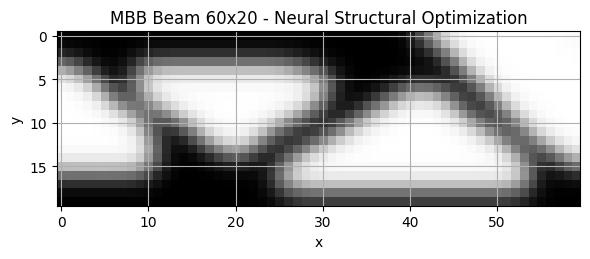

In [10]:
from scipy.ndimage import gaussian_filter

pygranso_structure = best_trial[1]

# Plot the two structures together
fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))

# pygranso
ax1.imshow(pygranso_structure, cmap='Greys')
ax1.grid()
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('MBB Beam 60x20 - Neural Structural Optimization')
fig.tight_layout()

In [9]:
# import imageio
# with imageio.get_writer('~/Desktop/topological_density_volume.gif', mode='I') as writer:
#     for x in designs:
#         writer.append_data(
#             1.0 - x.detach().numpy()
#         )